## Seinfeld - sentiment
**Program:** 01_sfeld_eda.ipynb <br>
**Created by:** Chris Chan<br>
**Date:** Feb 16, 2021<br>
**Purpose:** bring in data, count vectorize, etc. <br>
**Key Features:** 

**Key sites:**<br>
https://letstalkdata.com/2013/06/web-scraping-and-corpus-analysis-with-python-a-seinfeld-case-study/


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF

In [2]:
import glob
import os
from collections import defaultdict
import re
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

In [3]:
import nltk
import os
import spacy
import re
import string
import pickle
from itertools import cycle
import matplotlib.pyplot as plt
from nltk import stem
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
from nltk.tokenize import word_tokenize, sent_tokenize, MWETokenizer
from gensim import corpora, models, similarities, matutils
from sklearn.decomposition import TruncatedSVD, NMF
from corextopic import corextopic, vis_topic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import scattertext as st

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

**We read through all the docments and build a list-of-list of words:**

In [4]:
df = pd.read_csv('/Users/chrischan/Documents/02_Class/Metis/bootcamp/githubrepo/Metis_proj4/data/seinfeld_scripts_clean2.csv')

In [5]:
df.head()

character                                               text  episodeno  \
0     JERRY  Do you know what this is all about? Do you kno...          1   
1     JERRY  (pointing at Georges shirt) See, to me, that b...          1   
2    GEORGE                                   Are you through?          1   
3     JERRY             You do of course try on, when you buy?          1   
4    GEORGE  Yes, it was purple, I liked it, I dont actuall...          1   

     seid  season  
0  S01E01       1  
1  S01E01       1  
2  S01E01       1  
3  S01E01       1  
4  S01E01       1

In [6]:
for text in df["text"][0:10]:
    print(text)

Do you know what this is all about? Do you know, why were here? To be out, this is out and out is one of the single most enjoyable experiences of life. People did you ever hear people talking about We should go out? This is what theyre talking about this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.
(pointing at Georges shirt) See, 

## Data Cleaning

In [7]:
breaks = lambda x: re.sub("\n", " ", x)
alphanumeric = lambda x: re.sub("\w*\d\w*", "", x)
punc_lower = lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x.lower())

In [8]:
df["textmod"] = df["text"].map(breaks).map(alphanumeric).map(punc_lower)
df["character"] = df["character"].str.lower()

In [9]:
df

character                                               text  \
0           jerry  Do you know what this is all about? Do you kno...   
1           jerry  (pointing at Georges shirt) See, to me, that b...   
2          george                                   Are you through?   
3           jerry             You do of course try on, when you buy?   
4          george  Yes, it was purple, I liked it, I dont actuall...   
...           ...                                                ...   
54593       jerry    Grand theft auto - don't steal any of my jokes.   
54594  prisoner 3                      You suck - I'm gonna cut you.   
54595       jerry  Hey, I don't come down to where you work, and ...   
54596       guard   Alright, Seinfeld, that's it. Let's go. Come on.   
54597       jerry  Alright, hey, you've been great! See you in th...   

       episodeno    seid  season  \
0              1  S01E01       1   
1              1  S01E01       1   
2              1  S01E01       1   
3              1  S01E01       1   
4              1  S01E01       1   
...          ...     ...     ...   
54593         23  S09E23       9   
54594         23  S09E23       9   
54595         23  S09E23       9   
54596         23  S09E23       9   
54597         23  S09E23       9   

                                                 textmod  
0      do you know what this is all about do you know...  
1      pointing at georges shirt see to me that butto...  
2                                        are you through  
3                   you do of course try on when you buy  
4      yes it was purple i liked it i dont actually r...  
...                                                  ...  
54593       grand theft auto  dont steal any of my jokes  
54594                         you suck  im gonna cut you  
54595  hey i dont come down to where you work and kno...  
54596          alright seinfeld thats it lets go come on  
54597  alright hey youve been great see you in the ca...  

[54598 rows x 6 columns]

**Attach char to each line if/when summarizing to episode**

In [10]:
df["episodetext"] = df['character']+": "+df["textmod"] 
df.head()

character                                               text  episodeno  \
0     jerry  Do you know what this is all about? Do you kno...          1   
1     jerry  (pointing at Georges shirt) See, to me, that b...          1   
2    george                                   Are you through?          1   
3     jerry             You do of course try on, when you buy?          1   
4    george  Yes, it was purple, I liked it, I dont actuall...          1   

     seid  season                                            textmod  \
0  S01E01       1  do you know what this is all about do you know...   
1  S01E01       1  pointing at georges shirt see to me that butto...   
2  S01E01       1                                    are you through   
3  S01E01       1               you do of course try on when you buy   
4  S01E01       1  yes it was purple i liked it i dont actually r...   

                                         episodetext  
0  jerry: do you know what this is all about do y...  
1  jerry: pointing at georges shirt see to me tha...  
2                            george: are you through  
3        jerry: you do of course try on when you buy  
4  george: yes it was purple i liked it i dont ac...

In [11]:
def tprint(data,var,nobs):
    for text in data[var][0:nobs]:
        print(text)

In [12]:
tprint(df,"episodetext",10)
# for text in df["episodetext"][0:10]:
#     print(text)

jerry: do you know what this is all about do you know why were here to be out this is out and out is one of the single most enjoyable experiences of life people did you ever hear people talking about we should go out this is what theyre talking about this whole thing were all out now no one is home not one person here is home were all out there are people tryin to find us they dont know where we are on an imaginary phone did you ring i cant find him where did he go he didnt tell me where he was going he must have gone out you wanna go out you get ready you pick out the clothes right you take the shower you get all ready get the cash get your friends the car the spot the reservation then youre standing around whatta you do you go we gotta be getting back once youre out you wanna get back you wanna go to sleep you wanna get up you wanna go out again tomorrow right where ever you are in life its my feeling youve gotta go
jerry: pointing at georges shirt see to me that button is in the wor

**Stop Words**

Since we want to look at episode level we can include names as stopwords

In [13]:
from sklearn.feature_extraction import text 
#chars = ['seinfeld','jerry','elaine','george','kramer','newman','morty','helen','frank','peterman','puddy','steinbrenner']
my_stop_words = nltk.corpus.stopwords.words('english')
#my_stop_words.extend(chars) #text.ENGLISH_STOP_WORDS.union(chars)
#my_stop_words.extend(ch_list4)

In [14]:
my_stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [15]:
df.head()
#tprint(df,"textmod2",10)

character                                               text  episodeno  \
0     jerry  Do you know what this is all about? Do you kno...          1   
1     jerry  (pointing at Georges shirt) See, to me, that b...          1   
2    george                                   Are you through?          1   
3     jerry             You do of course try on, when you buy?          1   
4    george  Yes, it was purple, I liked it, I dont actuall...          1   

     seid  season                                            textmod  \
0  S01E01       1  do you know what this is all about do you know...   
1  S01E01       1  pointing at georges shirt see to me that butto...   
2  S01E01       1                                    are you through   
3  S01E01       1               you do of course try on when you buy   
4  S01E01       1  yes it was purple i liked it i dont actually r...   

                                         episodetext  
0  jerry: do you know what this is all about do y...  
1  jerry: pointing at georges shirt see to me tha...  
2                            george: are you through  
3        jerry: you do of course try on when you buy  
4  george: yes it was purple i liked it i dont ac...

## Lemmatize

In [16]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
spacy_lemmatize = lambda x: " ".join([token.lemma_ for token in nlp(x)])

In [17]:
df["lemmatized"] = df["textmod"].apply(spacy_lemmatize)
df

character                                               text  \
0           jerry  Do you know what this is all about? Do you kno...   
1           jerry  (pointing at Georges shirt) See, to me, that b...   
2          george                                   Are you through?   
3           jerry             You do of course try on, when you buy?   
4          george  Yes, it was purple, I liked it, I dont actuall...   
...           ...                                                ...   
54593       jerry    Grand theft auto - don't steal any of my jokes.   
54594  prisoner 3                      You suck - I'm gonna cut you.   
54595       jerry  Hey, I don't come down to where you work, and ...   
54596       guard   Alright, Seinfeld, that's it. Let's go. Come on.   
54597       jerry  Alright, hey, you've been great! See you in th...   

       episodeno    seid  season  \
0              1  S01E01       1   
1              1  S01E01       1   
2              1  S01E01       1   
3              1  S01E01       1   
4              1  S01E01       1   
...          ...     ...     ...   
54593         23  S09E23       9   
54594         23  S09E23       9   
54595         23  S09E23       9   
54596         23  S09E23       9   
54597         23  S09E23       9   

                                                 textmod  \
0      do you know what this is all about do you know...   
1      pointing at georges shirt see to me that butto...   
2                                        are you through   
3                   you do of course try on when you buy   
4      yes it was purple i liked it i dont actually r...   
...                                                  ...   
54593       grand theft auto  dont steal any of my jokes   
54594                         you suck  im gonna cut you   
54595  hey i dont come down to where you work and kno...   
54596          alright seinfeld thats it lets go come on   
54597  alright hey youve been great see you in the ca...   

                                             episodetext  \
0      jerry: do you know what this is all about do y...   
1      jerry: pointing at georges shirt see to me tha...   
2                                george: are you through   
3            jerry: you do of course try on when you buy   
4      george: yes it was purple i liked it i dont ac...   
...                                                  ...   
54593  jerry: grand theft auto  dont steal any of my ...   
54594             prisoner 3: you suck  im gonna cut you   
54595  jerry: hey i dont come down to where you work ...   
54596   guard: alright seinfeld thats it lets go come on   
54597  jerry: alright hey youve been great see you in...   

                                              lemmatized  
0      do you know what this be all about do you know...  
1      point at george shirt see to I that button be ...  
2                                         be you through  
3                   you do of course try on when you buy  
4      yes it be purple I like it I do nt actually re...  
...                                                  ...  
54593      grand theft auto   do nt steal any of my joke  
54594                      you suck   I m gon na cut you  
54595  hey I do nt come down to where you work and kn...  
54596          alright seinfeld that s it let go come on  
54597  alright hey you ve be great see you in the caf...  

[54598 rows x 8 columns]

## Different DFs by Character Relationships

In [18]:
# main 4 chars
df_main = df.loc[df["character"].isin(['george','jerry','kramer','elaine'])]

# George only
df_grg = df.loc[df["character"].isin(['george'])]

# George and Frank
df_grg_dad = df.loc[df["character"].isin(['george','frank'])]

# George and Jerry
df_grg_jer = df.loc[df["character"].isin(['george','jerry'])]

# George and Elaine
df_grg_ela = df.loc[df["character"].isin(['george','elaine'])]

### Doc: Character, episode Level

Create 2 separate ds: 1 with speaker and 1 without speaker

**1. with speaker**

### Choose your character group

In [19]:
def chargrpspk(data):

    df_sp = data.copy()

    ## Doc: Episode Level
    df_sp = df_sp.drop(['text','textmod','episodeno','lemmatized','season'],axis=1)
    # concatenate the string 
    df_sp['episodetext'] = df_sp.groupby(['character','seid'])['episodetext'].transform(lambda x : ' '.join(x)) 

    # drop duplicate data 
    df_sp = df_sp.drop_duplicates()

    # show the dataframe 
    print(df_sp) 
    
    return df_sp

**2. without speaker and removing pronouns**

In [20]:
def chargrpnospk(data):
    df_nosp = data.copy()

    ## Doc: Episode Level
    df_nosp = df_nosp.drop(['text','textmod','episodeno','episodetext','season'],axis=1)
    # concatenate the string 
    df_nosp['lemmatized'] = df_nosp.groupby(['character','seid'])['lemmatized'].transform(lambda x : ' '.join(x)) 

    # drop duplicate data 
    df_nosp = df_nosp.drop_duplicates()

    #df_nosp=pd.DataFrame(df_nosp)
    # show the dataframe 
    #print(df_nosp) 
    
    return df_nosp

### Start with the main characters

In [21]:
df_nosp=chargrpnospk(df_main)

In [22]:
data = df_nosp["lemmatized"]

In [23]:
data

0        do you know what this be all about do you know...
2        be you through yes it be purple I like it I do...
144      do you handle any of that commercial real esta...
215      coccoon ii the return I guess they do nt like ...
557      so I move into the centre lane now I get ahead...
                               ...                        
53573    you know my friend bob saccamano make a fortun...
53885    I ca nt eat this without catsup would it kill ...
53886    I know what you mean its like go out with some...
53912    hey jojo no thank you so what be you do come o...
53914    all right thank for the ride kramer oh I forge...
Name: lemmatized, Length: 687, dtype: object

**Stop words**

**ignore for now**

In [24]:
stopadd=['alright', 'okay', 'shes', 'hi', 'ha', 'hello', 'ah', 'ha','hello', 'ah', 'huh', 'ok', 'wanna', 
         'told', 'still','uh','ya', 'mr','dyou', 'um','uhm','whatre', 'cmon', 'ho', 'em','yea','hu',
        'bo','indicating','ykonw','seinfeld', 'yeah','im','gonna','ive', 'theyre', 'said','gotta','lets','say','cars']
my_stop_words.extend(stopadd)

In [ ]:
stopadd2 = ['know','oh','well','dont','like','get','hey','right','youre','thats','got','go','think','see','going',
'one','really','cant','want','hes','good','back','ill','look','come','tell','could','yes','would','didnt',
'take','little','something','whats','time','mean','never','thing','theres','way','make','maybe','people',
'anything','call','give','sure','big']

my_stop_words.extend(stopadd2)

In [ ]:
stopadd=['nt', 'na', 'gon na', 'gon', 'ca', 'ca nt','ta',  'chunnel']
my_stop_words.extend(stopadd)

In [ ]:
stopadd = ['whos','wheres','always','youve','everything','door','isnt','feel','coming','five','please','ask','find','enters','room','happened','sorry','god','nice','ever','thought','talking','looking','hands','doesnt','looks','better','believe','saw','kind',
          'whatever', 'whenever', 'whered', 'wheres','aah', 'able', 'absolutely', 'accept', 'ahh','answer', 'answering', 'answers','anyway', 'anywhere', 'cause', 'certain', 'certainly', 'chair','changed'] 
stopadd2 = ['four','pause','costanza','hundred','thousand','front','side','behind','ago','ten,','six','twenty','high','set','mine',
          'test','sue','number','hard','mrs','goin','anybody','la','eh','wednesday','saturday','de','anymore','enter','become','ten','key','cosmo']

my_stop_words.extend(stopadd)


In [ ]:
stopadd=['leave','thank','hear','happen','wha','sit','place','name','move','try','use','walk','yknow','paper','someone',
         'laugh','start','stop','hand']
my_stop_words.extend(stopadd)

In [ ]:
my_stop_words.extend(stopadd2)


## Sentiment ANalysis (all chars)

**using textblob**

In [32]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_nosp['polarity'] = df_nosp['lemmatized'].apply(pol)
df_nosp['subjectivity'] = df_nosp['lemmatized'].apply(sub)
df_nosp

character    seid                                         lemmatized  \
0         jerry  S01E01  do you know what this be all about do you know...   
2        george  S01E01  be you through yes it be purple I like it I do...   
144      kramer  S01E01  do you handle any of that commercial real esta...   
215      elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557       jerry  S01E02  so I move into the centre lane now I get ahead...   
...         ...     ...                                                ...   
53573    kramer  S09E20  you know my friend bob saccamano make a fortun...   
53885    george  S09E23  I ca nt eat this without catsup would it kill ...   
53886     jerry  S09E23  I know what you mean its like go out with some...   
53912    kramer  S09E23  hey jojo no thank you so what be you do come o...   
53914    elaine  S09E23  all right thank for the ride kramer oh I forge...   

       polarity  subjectivity  
0      0.046940      0.551080  
2      0.154769      0.529920  
144   -0.060000      0.360000  
215    0.163866      0.504062  
557    0.048546      0.515032  
...         ...           ...  
53573  0.116431      0.577812  
53885  0.032359      0.480758  
53886  0.086727      0.540103  
53912  0.274076      0.536864  
53914  0.146847      0.577408  

[687 rows x 5 columns]

**using vader**

In [33]:
df_test = df_nosp.copy()

In [37]:
#Add VADER metrics to dataframe
sid=SentimentIntensityAnalyzer()

df_nosp['compound'] = [sid.polarity_scores(v)['compound'] for v in df_nosp['lemmatized']]
df_nosp['neg'] = [sid.polarity_scores(v)['neg'] for v in df_nosp['lemmatized']]
df_nosp['neu'] = [sid.polarity_scores(v)['neu'] for v in df_nosp['lemmatized']]
df_nosp['pos'] = [sid.polarity_scores(v)['pos'] for v in df_nosp['lemmatized']]

In [36]:
df_nosp

character    seid                                         lemmatized  \
0         jerry  S01E01  do you know what this be all about do you know...   
2        george  S01E01  be you through yes it be purple I like it I do...   
144      kramer  S01E01  do you handle any of that commercial real esta...   
215      elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557       jerry  S01E02  so I move into the centre lane now I get ahead...   
...         ...     ...                                                ...   
53573    kramer  S09E20  you know my friend bob saccamano make a fortun...   
53885    george  S09E23  I ca nt eat this without catsup would it kill ...   
53886     jerry  S09E23  I know what you mean its like go out with some...   
53912    kramer  S09E23  hey jojo no thank you so what be you do come o...   
53914    elaine  S09E23  all right thank for the ride kramer oh I forge...   

       polarity  subjectivity  compound    neg    neu    pos  
0      0.046940      0.551080    0.9998  0.091  0.754  0.156  
2      0.154769      0.529920    0.9912  0.091  0.774  0.135  
144   -0.060000      0.360000    0.0997  0.073  0.827  0.099  
215    0.163866      0.504062    0.9196  0.125  0.719  0.156  
557    0.048546      0.515032    0.9670  0.100  0.790  0.110  
...         ...           ...       ...    ...    ...    ...  
53573  0.116431      0.577812    0.9902  0.088  0.769  0.144  
53885  0.032359      0.480758   -0.9563  0.119  0.775  0.106  
53886  0.086727      0.540103    0.9456  0.133  0.707  0.160  
53912  0.274076      0.536864    0.9870  0.096  0.731  0.172  
53914  0.146847      0.577408    0.9903  0.095  0.747  0.158  

[687 rows x 9 columns]

In [38]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
df_sent = df_nosp.copy()
df_sent = df_nosp.drop(['lemmatized','subjectivity','compound','neg','neu','pos'],axis=1)

In [156]:
df_sent_wide = df_sent.pivot("seid","character","polarity")
df_sent_wide

character    elaine    george     jerry    kramer
seid                                             
S01E01     0.163866  0.154769  0.046940 -0.060000
S01E02     0.254266  0.150283  0.048546  0.010314
S01E03     0.112500  0.000486  0.005509  0.264286
S01E04    -0.038718  0.080470  0.060459  0.167450
S02E01    -0.012385  0.153553 -0.002739  0.193679
...             ...       ...       ...       ...
S09E17    -0.033570 -0.120168  0.016665  0.117899
S09E18    -0.051521  0.194698  0.052201  0.091611
S09E19     0.106930  0.148031  0.198028  0.038968
S09E20     0.083163  0.036885  0.018374  0.116431
S09E23     0.146847  0.032359  0.086727  0.274076

[173 rows x 4 columns]

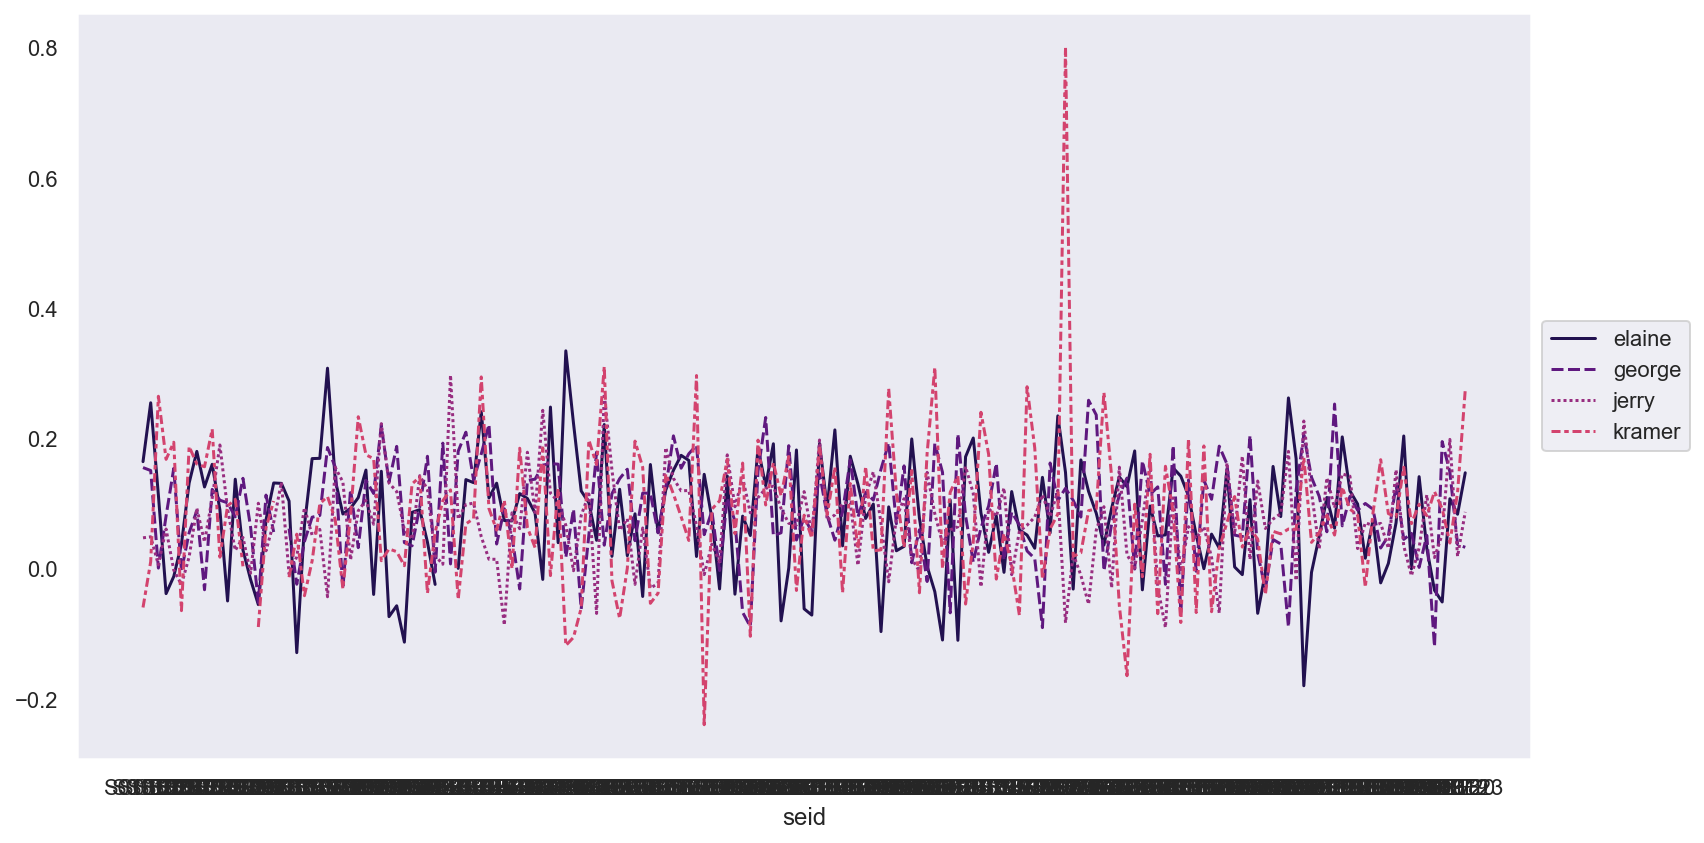

In [55]:
import seaborn as sns
%matplotlib inline
#%config InlineBackend.figure_formats = ['retina']

sns.set(rc={'figure.figsize':(12,6)})
#sns.color_palette("vlag", as_cmap=True)

fig=plt.figure()
ax = plt.subplot()

sns.set_palette("magma")
sns.lineplot(data=df_sent_wide)

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)

plt.tight_layout()
plt.savefig('line_sent_episode.svg')
plt.show()

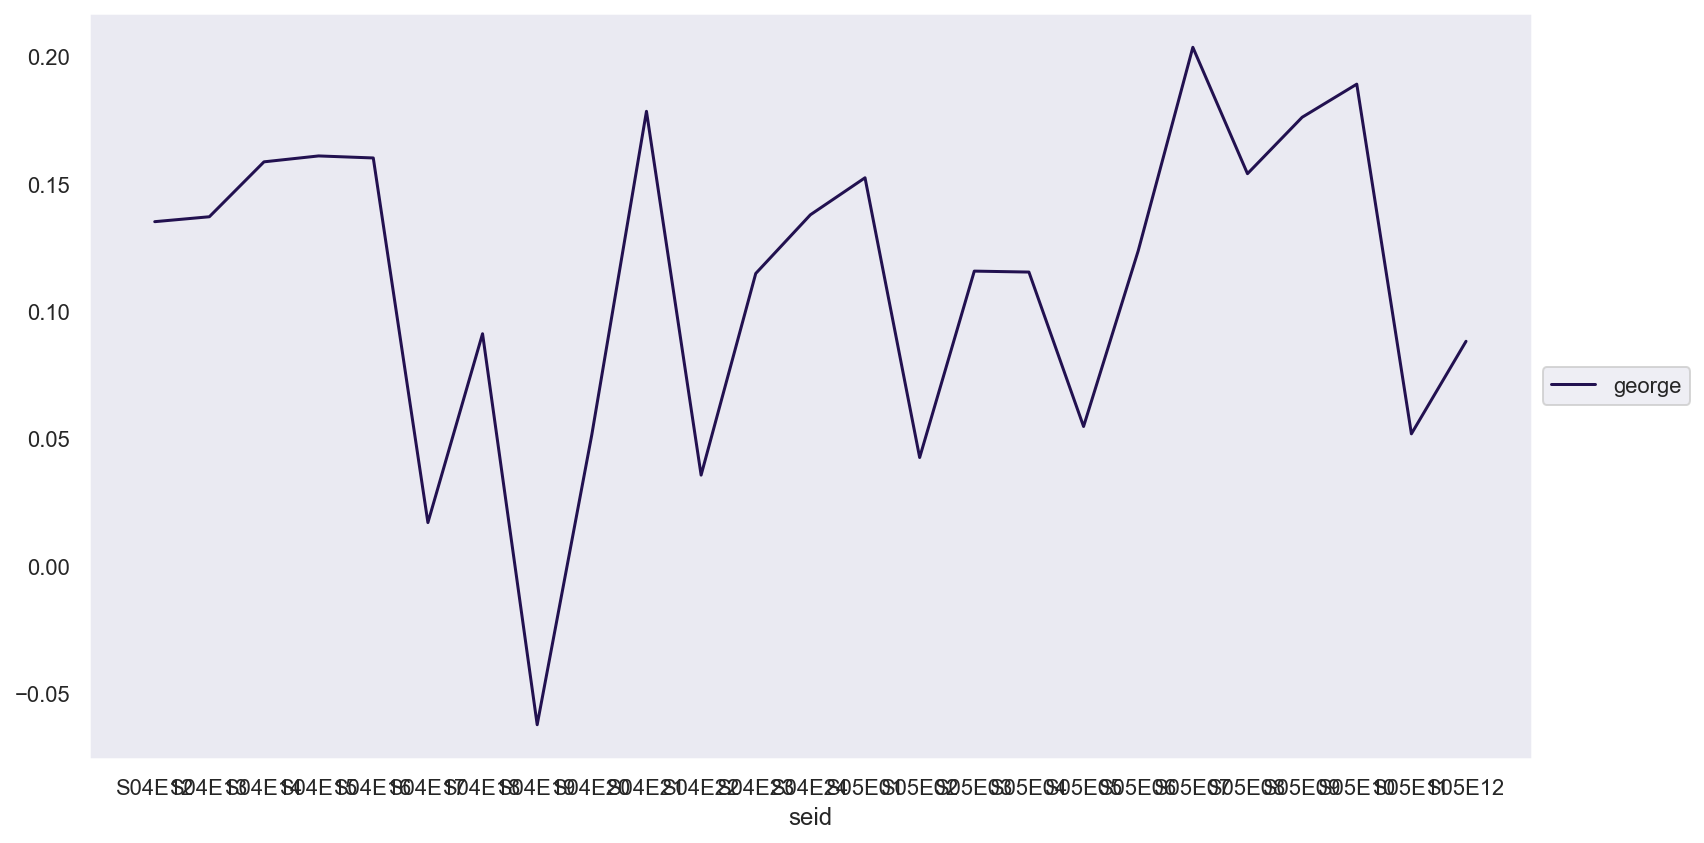

In [80]:
import seaborn as sns
%matplotlib inline
#%config InlineBackend.figure_formats = ['retina']

sns.set(rc={'figure.figsize':(12,6)})
#sns.color_palette("vlag", as_cmap=True)

fig=plt.figure()
ax = plt.subplot()

sns.set_palette("magma")
sns.lineplot(data=df_sent_wide[50:75][['george']])

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)

plt.tight_layout()
plt.savefig('line_sent_episode.svg')
plt.show()

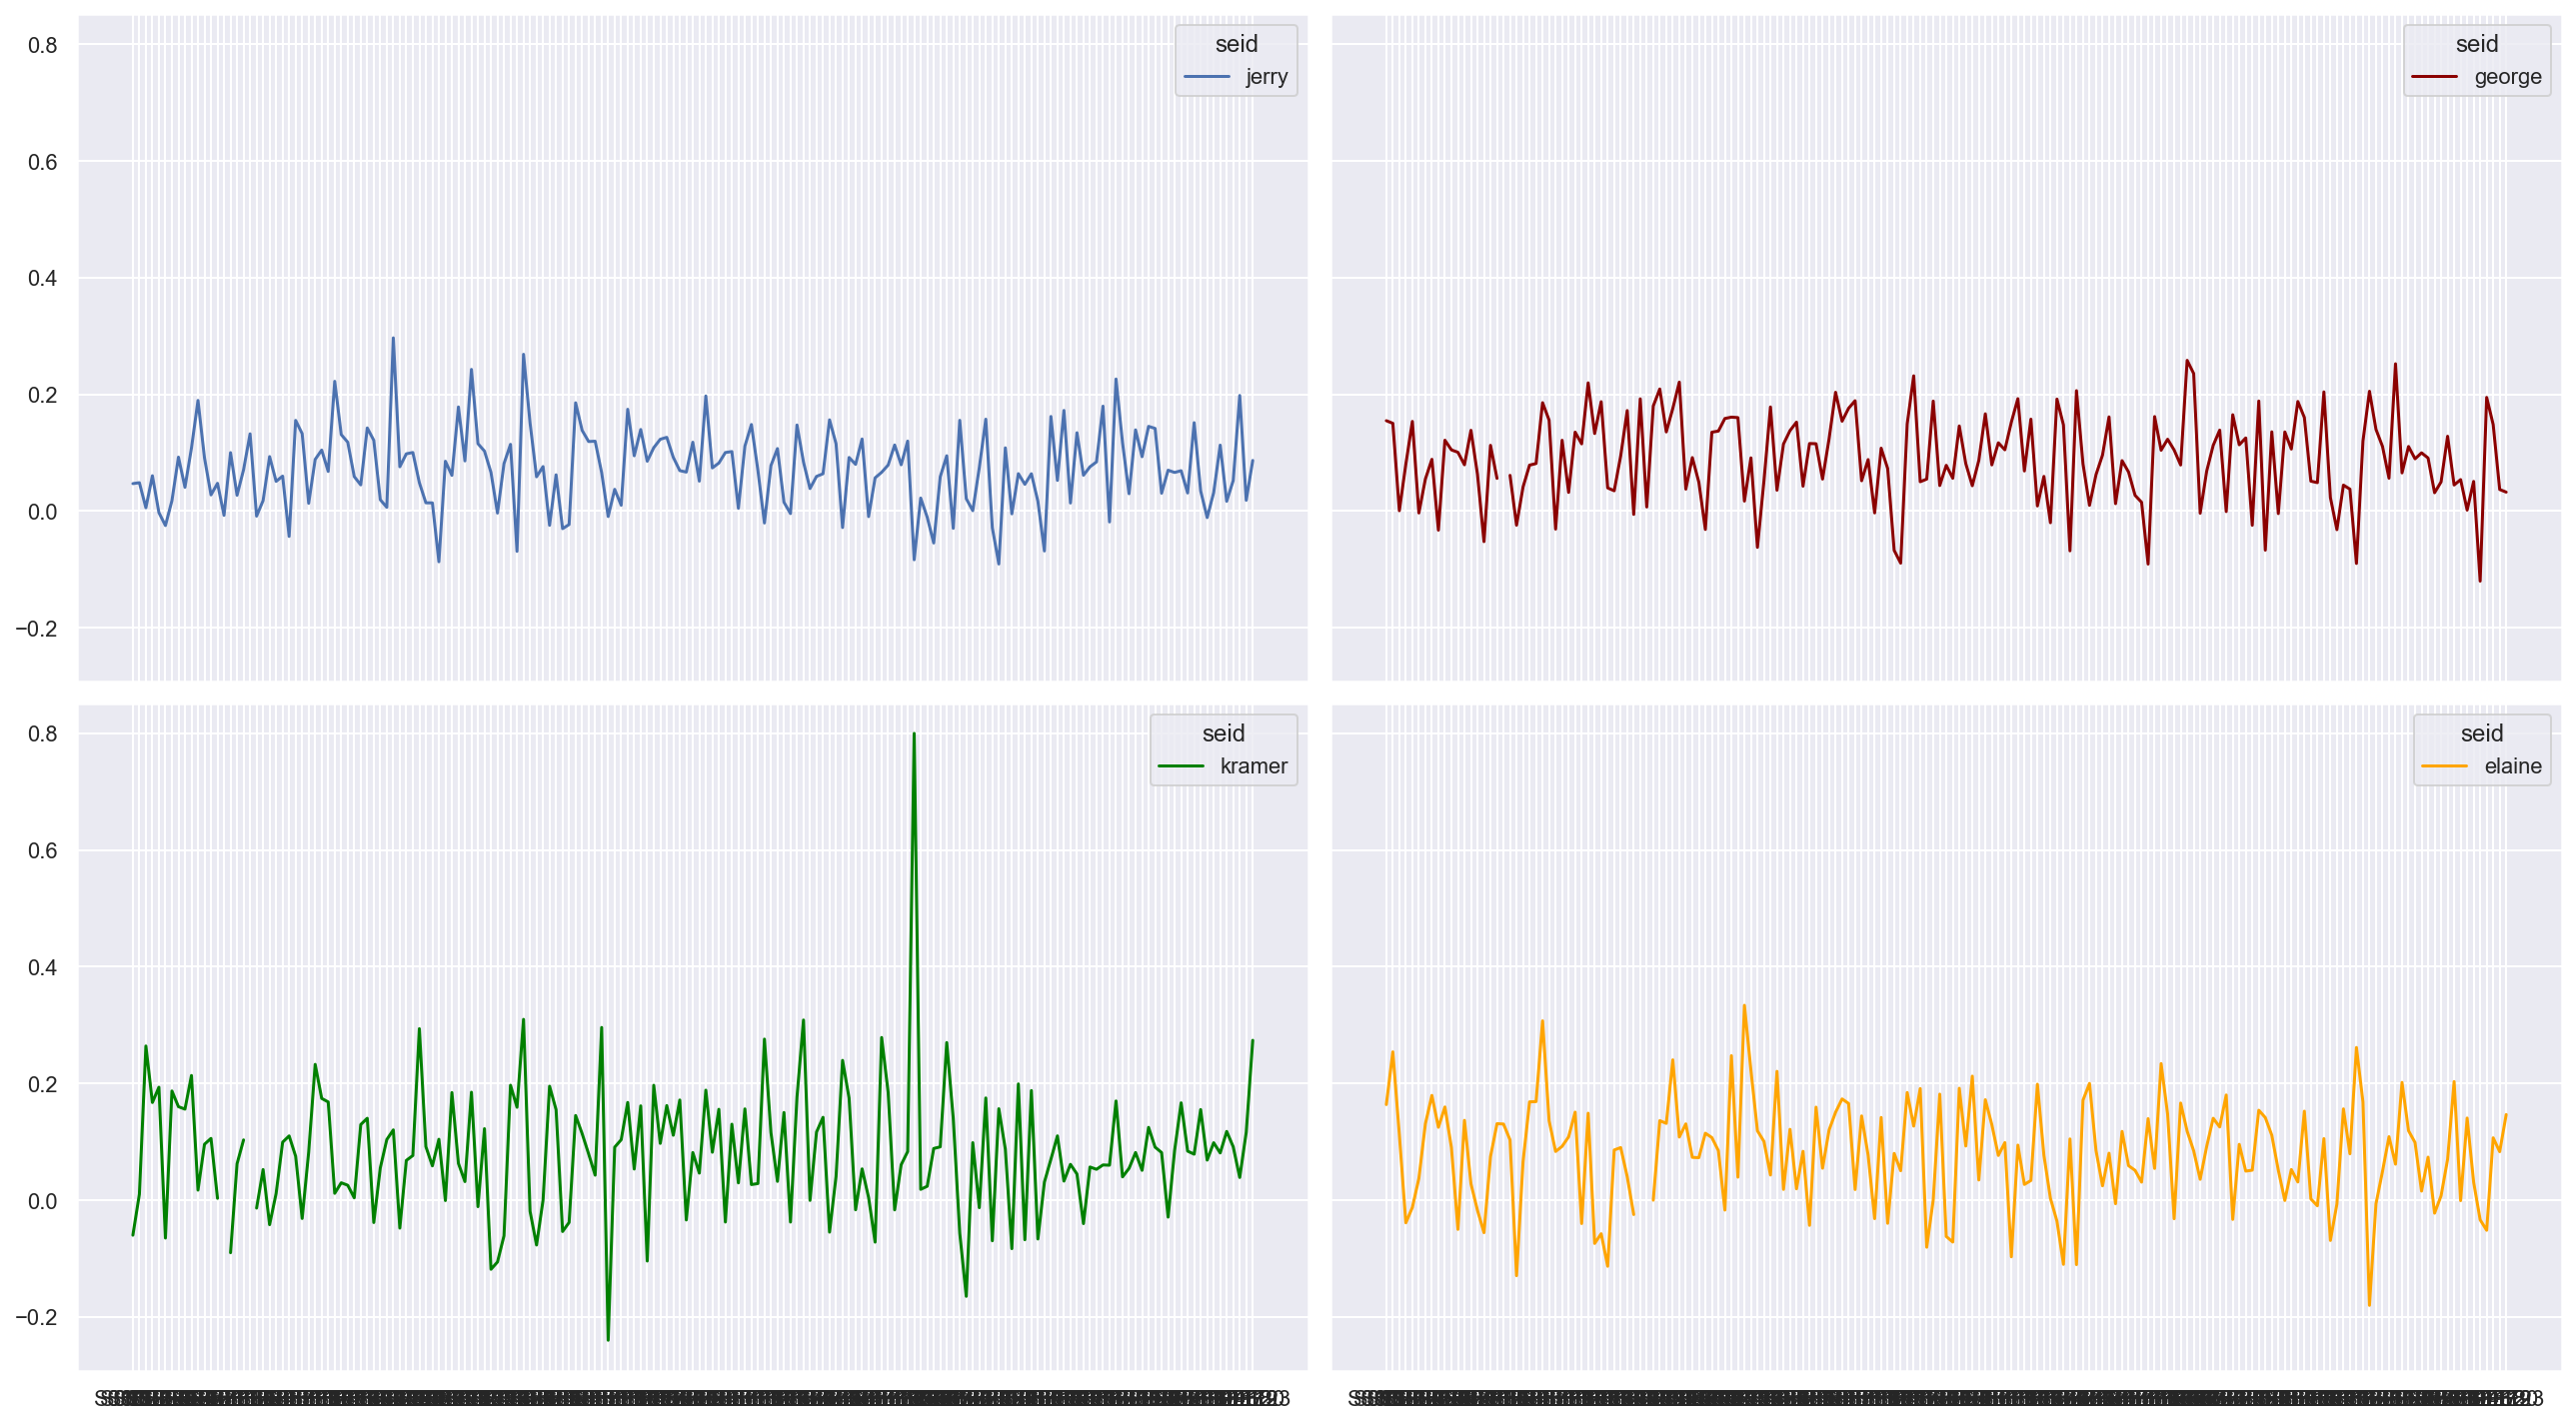

In [751]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(18, 10), facecolor='white', sharex=True, sharey=True)

#plt.figure(figsize = (6, 6), facecolor = 'white')
#fig.suptitle()

sns.lineplot(ax=axes[0, 0], data=df_sent_wide[['jerry']])
sns.lineplot(ax=axes[0, 1], data=df_sent_wide[['george']],palette=['darkred'])
sns.lineplot(ax=axes[1, 0], data=df_sent_wide[['kramer']],palette=['green'])
sns.lineplot(ax=axes[1, 1], data=df_sent_wide[['elaine']],palette=['orange'])


#sns.set(rc={'figure.figsize':(12,6)})
#sns.color_palette("vlag", as_cmap=True)

#fig=plt.figure()
#gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
#ax = plt.subplot()
#(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

# a=sns.lineplot(data=df_sent_wide[50:75][['jerry']])
# b=sns.lineplot(data=df_sent_wide[50:75][['george']])
# c=sns.lineplot(data=df_sent_wide[50:75][['kramer']])
# d=sns.lineplot(data=df_sent_wide[50:75][['elaine']])

#fig.suptitle('Sharing x per column, y per row')

# ax1.plot(a)
# ax2.plot(b)
# ax3.plot(c)
# ax4.plot(d)

# for ax in axs.flat:
#     ax.label_outer()

#sns.set_palette("magma")
#sns.lineplot(data=df_sent_wide[50:75][['george']])

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.grid(False)

plt.tight_layout()
plt.savefig("line_sent_episode.png")
plt.show()

**Add season to distinguish season by colors**

In [157]:
df_sent_wide['season'] = df_sent_wide.index.astype(str).str[0:3]
df_sent_wide

character    elaine    george     jerry    kramer season
seid                                                    
S01E01     0.163866  0.154769  0.046940 -0.060000    S01
S01E02     0.254266  0.150283  0.048546  0.010314    S01
S01E03     0.112500  0.000486  0.005509  0.264286    S01
S01E04    -0.038718  0.080470  0.060459  0.167450    S01
S02E01    -0.012385  0.153553 -0.002739  0.193679    S02
...             ...       ...       ...       ...    ...
S09E17    -0.033570 -0.120168  0.016665  0.117899    S09
S09E18    -0.051521  0.194698  0.052201  0.091611    S09
S09E19     0.106930  0.148031  0.198028  0.038968    S09
S09E20     0.083163  0.036885  0.018374  0.116431    S09
S09E23     0.146847  0.032359  0.086727  0.274076    S09

[173 rows x 5 columns]

In [205]:
df_sent_wide.rename_axis("seid",inplace=True,axis="index")
df_sent_wide

seid      elaine    george     jerry    kramer season
seid                                                 
S01E01  0.163866  0.154769  0.046940 -0.060000    S01
S01E02  0.254266  0.150283  0.048546  0.010314    S01
S01E03  0.112500  0.000486  0.005509  0.264286    S01
S01E04 -0.038718  0.080470  0.060459  0.167450    S01
S02E01 -0.012385  0.153553 -0.002739  0.193679    S02
...          ...       ...       ...       ...    ...
S09E17 -0.033570 -0.120168  0.016665  0.117899    S09
S09E18 -0.051521  0.194698  0.052201  0.091611    S09
S09E19  0.106930  0.148031  0.198028  0.038968    S09
S09E20  0.083163  0.036885  0.018374  0.116431    S09
S09E23  0.146847  0.032359  0.086727  0.274076    S09

[173 rows x 5 columns]

In [206]:
df_sent_wide.rename_axis(None, inplace=True)
df_sent_wide.iloc[:1]

seid      elaine    george    jerry  kramer season
S01E01  0.163866  0.154769  0.04694   -0.06    S01

In [207]:
df_sent_wide.columns

Index(['elaine', 'george', 'jerry', 'kramer', 'season'], dtype='object', name='seid')

In [162]:
df_sent_wide.reset_index(level=0, drop=True)

seid    elaine    george     jerry    kramer season
0     0.163866  0.154769  0.046940 -0.060000    S01
1     0.254266  0.150283  0.048546  0.010314    S01
2     0.112500  0.000486  0.005509  0.264286    S01
3    -0.038718  0.080470  0.060459  0.167450    S01
4    -0.012385  0.153553 -0.002739  0.193679    S02
..         ...       ...       ...       ...    ...
168  -0.033570 -0.120168  0.016665  0.117899    S09
169  -0.051521  0.194698  0.052201  0.091611    S09
170   0.106930  0.148031  0.198028  0.038968    S09
171   0.083163  0.036885  0.018374  0.116431    S09
172   0.146847  0.032359  0.086727  0.274076    S09

[173 rows x 5 columns]

In [153]:
df_sent_wide.set_axis(['elaine', 'george','jerry','kramer','season'], axis='columns', inplace=True)

In [210]:
df_sent_wide.index

Index(['S01E01', 'S01E02', 'S01E03', 'S01E04', 'S02E01', 'S02E02', 'S02E03',
       'S02E04', 'S02E05', 'S02E06',
       ...
       'S09E12', 'S09E13', 'S09E14', 'S09E15', 'S09E16', 'S09E17', 'S09E18',
       'S09E19', 'S09E20', 'S09E23'],
      dtype='object', length=173)

In [216]:
sein=defaultdict(dict)
df_sent_wide_test = dict(zip(df_sent_wide.season, df_sent_wide.index))

In [217]:
df_sent_wide_test

{'S01': 'S01E04',
 'S02': 'S02E12',
 'S03': 'S03E23',
 'S04': 'S04E24',
 'S05': 'S05E22',
 'S06': 'S06E24',
 'S07': 'S07E24',
 'S08': 'S08E22',
 'S09': 'S09E23'}

**for colors by season on graph**

In [ ]:
length = sum([len(hp[book]) for book in hp])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [hp_df.loc[book].loc[hp[book][chapter][0]][emotion] for book in hp for chapter in hp[book]]

    plt.figure(figsize=(15, 10))
    for book in book_indices:
        plt.plot(x[book_indices[book][0]: book_indices[book][1]],
                 y[book_indices[book][0]: book_indices[book][1]],
                 label=book)
    plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label='Moving Average')
    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.title('{} Sentiment of the Harry Potter series'.format(emotion.title()), fontsize=20)
    plt.xlabel('Chapter', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

**gropu by season and graph by season**

In [117]:
df_sent_wide['season'] = df_sent_wide.index.astype(str).str[0:3]
#df_sent_wide = df_sent_wide.drop(['seid'],axis=1)  

# mean of scores per season
df_sent_wide_mean=df_sent_wide.groupby('season').mean()
df_sent_wide_mean

character    elaine    george     jerry    kramer
season                                           
S01        0.122978  0.096502  0.040363  0.095512
S02        0.062738  0.067953  0.056606  0.088949
S03        0.071716  0.090679  0.079085  0.065674
S04        0.120533  0.107591  0.087721  0.072151
S05        0.083261  0.093935  0.079502  0.082750
S06        0.061560  0.094579  0.077175  0.098477
S07        0.091365  0.088068  0.053364  0.100620
S08        0.062164  0.083353  0.067292  0.055380
S09        0.066885  0.079366  0.077284  0.093042

In [119]:
df_sent_wide_mean.columns

Index(['elaine', 'george', 'jerry', 'kramer'], dtype='object', name='character')

In [127]:
df_sent_wide_mean.columns

Index(['elaine', 'george', 'jerry', 'kramer'], dtype='object', name='character')

In [130]:
df_sent_wide_mean.rename_axis("season",inplace=True,axis="columns")
df_sent_wide_mean

season    elaine    george     jerry    kramer
season                                        
S01     0.122978  0.096502  0.040363  0.095512
S02     0.062738  0.067953  0.056606  0.088949
S03     0.071716  0.090679  0.079085  0.065674
S04     0.120533  0.107591  0.087721  0.072151
S05     0.083261  0.093935  0.079502  0.082750
S06     0.061560  0.094579  0.077175  0.098477
S07     0.091365  0.088068  0.053364  0.100620
S08     0.062164  0.083353  0.067292  0.055380
S09     0.066885  0.079366  0.077284  0.093042

In [131]:
df_sent_wide_mean.rename_axis(None, inplace=True)
df_sent_wide_mean

season    elaine    george     jerry    kramer
S01     0.122978  0.096502  0.040363  0.095512
S02     0.062738  0.067953  0.056606  0.088949
S03     0.071716  0.090679  0.079085  0.065674
S04     0.120533  0.107591  0.087721  0.072151
S05     0.083261  0.093935  0.079502  0.082750
S06     0.061560  0.094579  0.077175  0.098477
S07     0.091365  0.088068  0.053364  0.100620
S08     0.062164  0.083353  0.067292  0.055380
S09     0.066885  0.079366  0.077284  0.093042

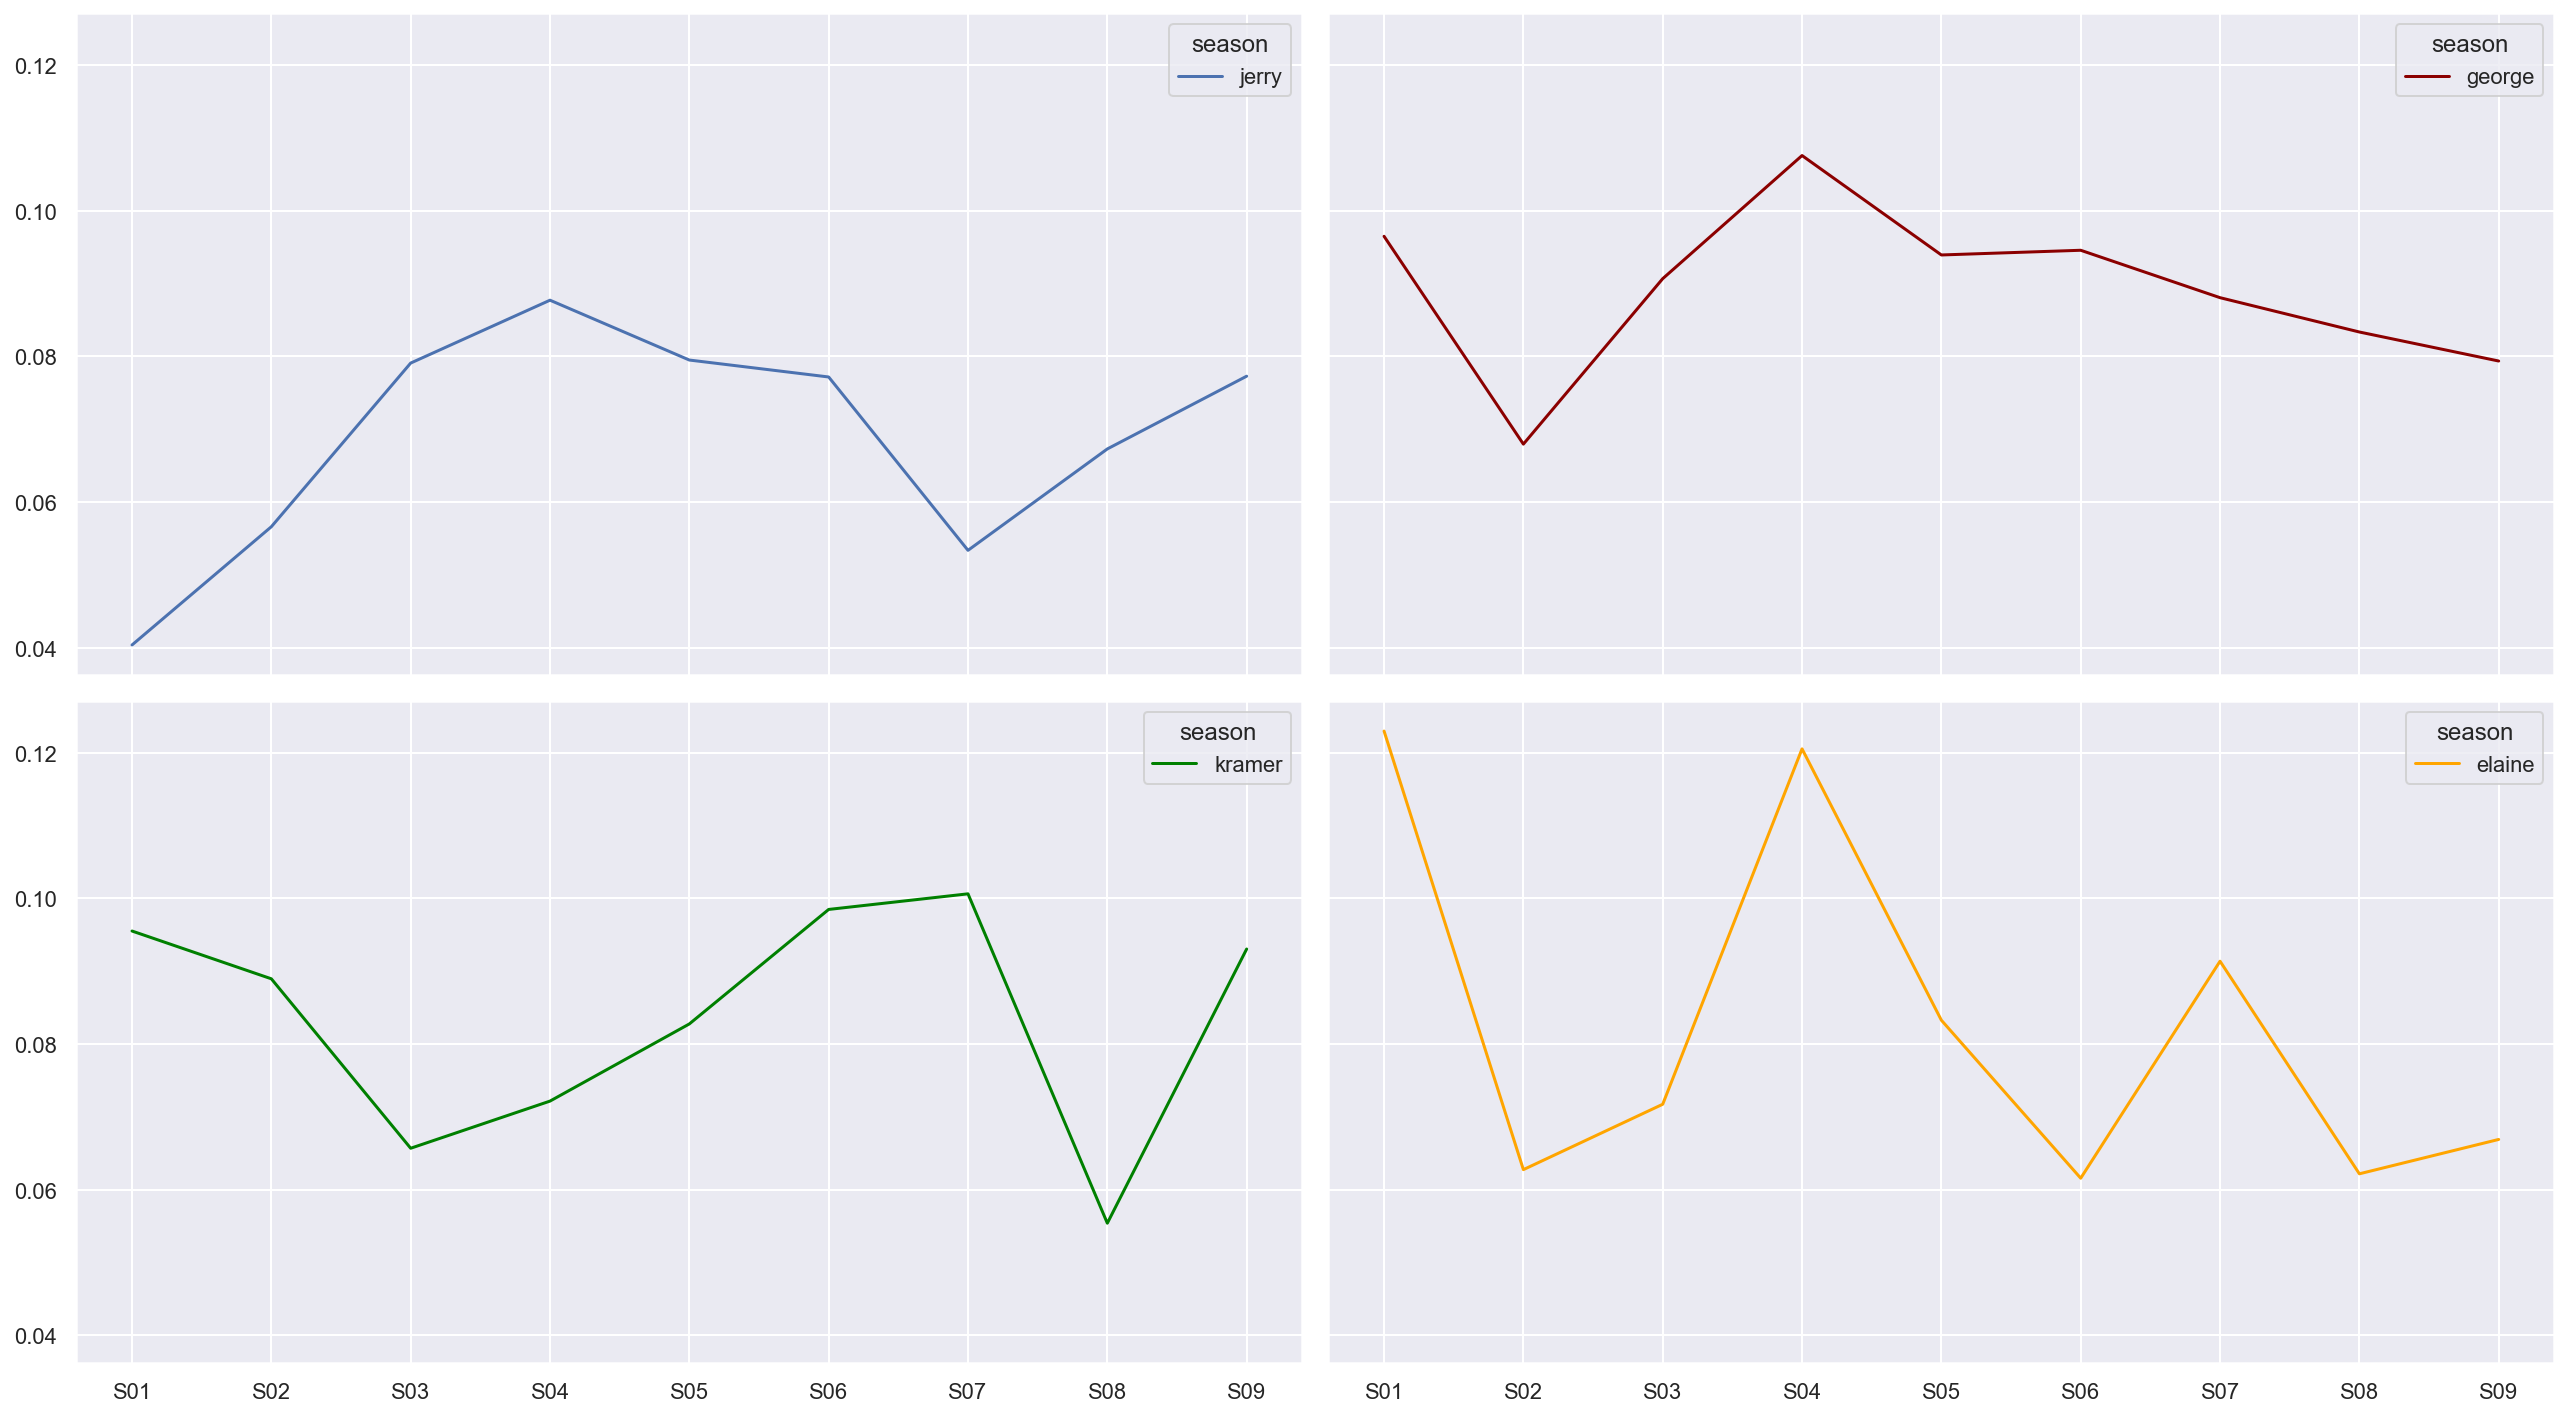

In [750]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(18, 10), facecolor='white',sharex=True ,sharey=True)
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

#fig.suptitle()

#sns.lmplot('cycle_number', 'value', data=df, hue='variable', ci=None, order=2, truncate=True)
sns.lineplot(ax=axes[0, 0], data=df_sent_wide_mean[['jerry']])
sns.lineplot(ax=axes[0, 1], data=df_sent_wide_mean[['george']],palette=['darkred'])
sns.lineplot(ax=axes[1, 0], data=df_sent_wide_mean[['kramer']],palette=['green'])
sns.lineplot(ax=axes[1, 1], data=df_sent_wide_mean[['elaine']],palette=['orange'])
sns.set(rc={'figure.figsize':(12,6)})

#sns.set_palette("magma")
#sns.lineplot(data=df_sent_wide[50:75][['george']])

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)

plt.tight_layout()
plt.savefig('line_sent_season.svg')
plt.show()

## Get positve and negative episodes

In [754]:
char=['george']
df_grg_pos = df_nosp[df_nosp["character"].isin(char)].sort_values("polarity").groupby("character").tail(40)
df_grg_neg = df_nosp[df_nosp["character"].isin(char)].sort_values("polarity").groupby("character").head(40)

#df_sent_wide1 = df_nosp.sort_values("polarity").groupby("character").tail(10)
df_grg_neg.head()

character    seid                                         lemmatized  \
52607    george  S09E17  I read somewhere that this brentanos be the pl...   
36251    george  S07E12  how cause I m an idiot I be go to but then I f...   
46400    george  S08E20  so you re on the speed dial what number wha yo...   
23837    george  S05E17  can I come upstairs please elaine push the but...   
32372    george  S06E24  where be you well you know if you be sit right...   

       polarity  subjectivity  compound    neg    neu    pos  
52607 -0.120168      0.475488    0.5950  0.096  0.790  0.114  
36251 -0.090934      0.437752    0.9613  0.092  0.778  0.129  
46400 -0.089887      0.543401    0.9068  0.130  0.709  0.161  
23837 -0.089356      0.526400   -0.6936  0.091  0.829  0.079  
32372 -0.068254      0.392857   -0.5151  0.085  0.838  0.077

## What are some words used per groups of episodes

## Word Cloud George

In [256]:
# pos_eps = ['S04E07','S05E20','S07E19','S09E04','S07E18' 'S04E07','S05E20' 'S07E19', 'S09E04','S07E18'] 
# neg_eps = ['S09E17','S07E12','S08E20','S05E17','S06E24','S05E16','S08E06','S04E19','S02E12','S02E05']
# char=['george']

# selecting rows based on condition 
# df_grg_pos = df_nosp[(df_nosp['seid'].isin(pos_eps)) & df_nosp['character'].isin(char)] 
# df_grg_neg = df_nosp[(df_nosp['seid'].isin(neg_eps)) & df_nosp['character'].isin(char)] 

**apply only basic stopwords**

In [761]:
base_stop_words = nltk.corpus.stopwords.words('english')

In [765]:
base_add = ['think','need','move','happen','even','ta','na','oh','hey','ca','nt','mr',
            'uh','yeah','gon','thing','come','take','know','make','bubble','ya','go','let','ill','goback','huh']
base_stop_words.extend(base_add)

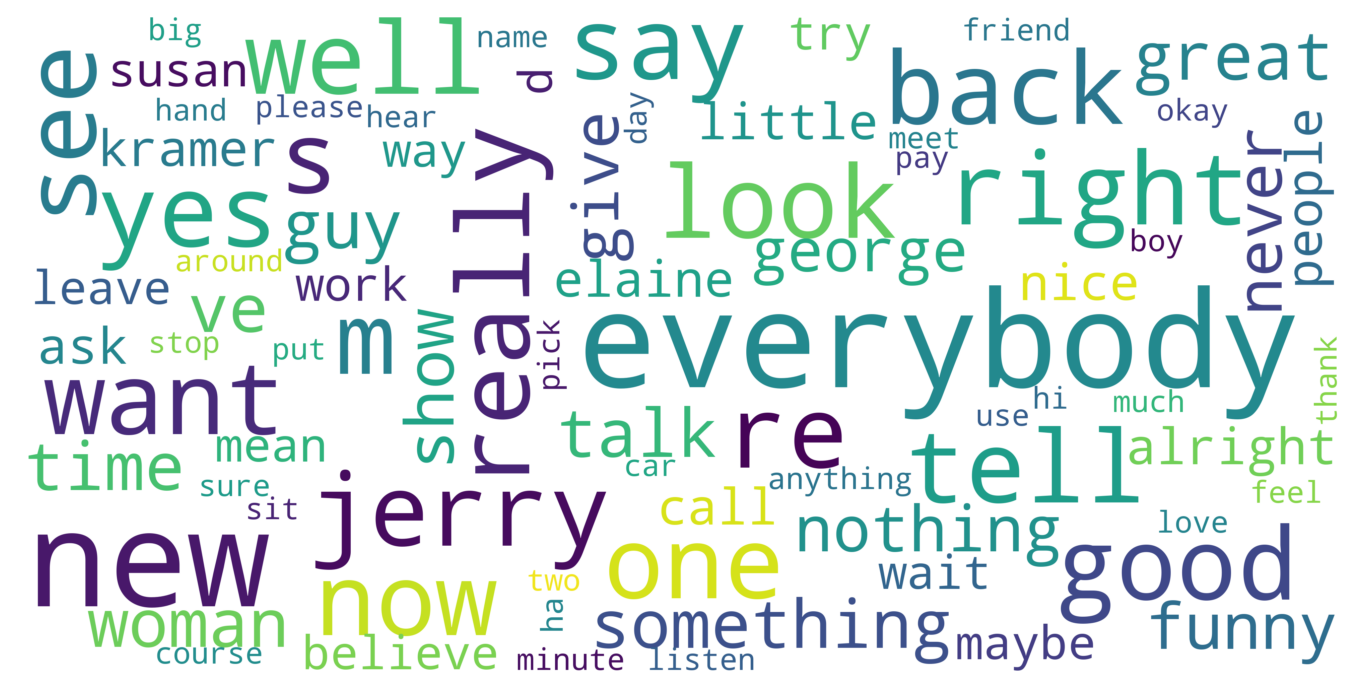

<Figure size 432x288 with 0 Axes>

In [770]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

#def wcloud(data):
df_cloud = df_grg_pos.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloud['lemmatized']=df_grg_pos['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_add]))

split_title = [x.split(" ") for x in df_cloud['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


wordcloud = WordCloud(background_color='white', max_words=80, max_font_size=40, scale=10,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_pos_costanza.png')
plt.show()

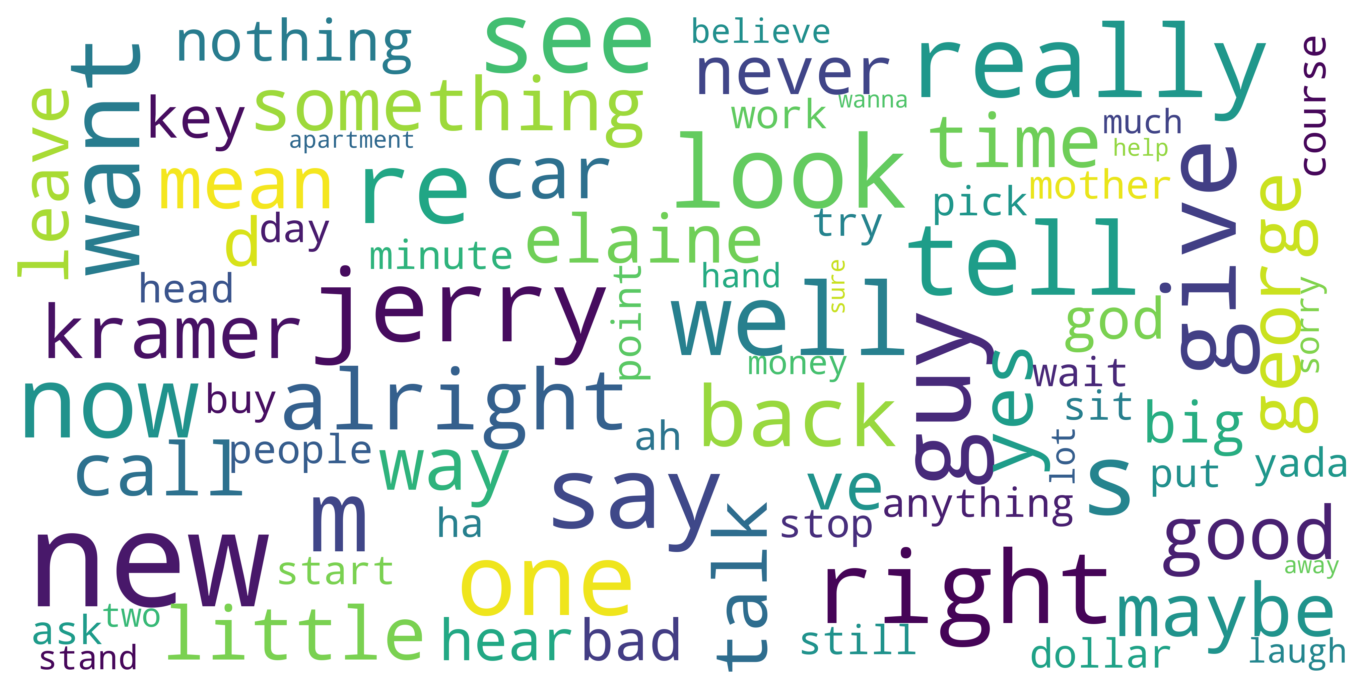

<Figure size 432x288 with 0 Axes>

In [769]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

#def wcloud(data):
df_cloud = df_grg_neg.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloud['lemmatized']=df_grg_neg['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_add]))

split_title = [x.split(" ") for x in df_cloud['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


wordcloud = WordCloud(background_color='white', max_words=80, max_font_size=40, scale=10,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_neg_costanza.png')
plt.show()

## Emotion Analysis

In [291]:
df_nosp

character    seid                                         lemmatized  \
0         jerry  S01E01  do you know what this be all about do you know...   
2        george  S01E01  be you through yes it be purple I like it I do...   
144      kramer  S01E01  do you handle any of that commercial real esta...   
215      elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557       jerry  S01E02  so I move into the centre lane now I get ahead...   
...         ...     ...                                                ...   
53573    kramer  S09E20  you know my friend bob saccamano make a fortun...   
53885    george  S09E23  I ca nt eat this without catsup would it kill ...   
53886     jerry  S09E23  I know what you mean its like go out with some...   
53912    kramer  S09E23  hey jojo no thank you so what be you do come o...   
53914    elaine  S09E23  all right thank for the ride kramer oh I forge...   

       polarity  subjectivity  compound    neg    neu    pos  
0      0.046940      0.551080    0.9998  0.091  0.754  0.156  
2      0.154769      0.529920    0.9912  0.091  0.774  0.135  
144   -0.060000      0.360000    0.0997  0.073  0.827  0.099  
215    0.163866      0.504062    0.9196  0.125  0.719  0.156  
557    0.048546      0.515032    0.9670  0.100  0.790  0.110  
...         ...           ...       ...    ...    ...    ...  
53573  0.116431      0.577812    0.9902  0.088  0.769  0.144  
53885  0.032359      0.480758   -0.9563  0.119  0.775  0.106  
53886  0.086727      0.540103    0.9456  0.133  0.707  0.160  
53912  0.274076      0.536864    0.9870  0.096  0.731  0.172  
53914  0.146847      0.577408    0.9903  0.095  0.747  0.158  

[687 rows x 9 columns]

In [297]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

import time
import pandas as pd
import requests

from tqdm import tqdm

def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns to the
    DataFrame for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions
    INPUT: DataFrame, string
    OUTPUT: the original DataFrame with ten new columns
    '''

    df_emo = df.copy()

    filepath = ('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=df.index, columns=emotions)

    stemmer = SnowballStemmer("english")

    
    book = ''
    chapter = ''
    
    with tqdm(total=len(list(df_emo.iterrows()))) as pbar:
        for i, row in df_emo.iterrows():
            pbar.update(1)
#             if row['book'] != book:
#                 print(row['book'])
#                 book = row['book']
#             if row['chapter_title'] != chapter:
#                 print('   ', row['chapter_title'])
#                 chapter = row['chapter_title']
#                 chap = row['chapter_title']
            document = word_tokenize(df_emo.loc[i][column])
            for word in document:
                word = stemmer.stem(word.lower())
                emo_score = emolex_words[emolex_words.word == word]
                if not emo_score.empty:
                    for emotion in list(emotions):
                        emo_df.at[i, emotion] += emo_score[emotion]

    df_emo = pd.concat([df_emo, emo_df], axis=1)

    return df_emo

In [423]:
df_emo2 = text_emotion(df_nosp, 'lemmatized')

100%|██████████| 687/687 [11:17<00:00,  1.01it/s]


In [1280]:
df_emo_all = df_emo2.copy()
df_emo_all.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


character    seid                                         lemmatized  \
0       jerry  S01E01  do you know what this be all about do you know...   
2      george  S01E01  be you through yes it be purple I like it I do...   
144    kramer  S01E01  do you handle any of that commercial real esta...   
215    elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557     jerry  S01E02  so I move into the centre lane now I get ahead...   

     polarity  subjectivity  compound    neg    neu    pos     anger  \
0    0.046940      0.551080    0.9998  0.091  0.754  0.156  0.007510   
2    0.154769      0.529920    0.9912  0.091  0.774  0.135  0.009662   
144 -0.060000      0.360000    0.0997  0.073  0.827  0.099  0.000000   
215  0.163866      0.504062    0.9196  0.125  0.719  0.156  0.015228   
557  0.048546      0.515032    0.9670  0.100  0.790  0.110  0.014110   

     anticipation   disgust      fear       joy  negative  positive   sadness  \
0        0.017442  0.004360  0.010417  0.012597  0.016957  0.024467  0.008721   
2        0.033816  0.009662  0.015459  0.015459  0.024155  0.027053  0.013527   
144      0.017544  0.000000  0.017544  0.000000  0.000000  0.087719  0.000000   
215      0.038071  0.012690  0.007614  0.027919  0.022843  0.038071  0.007614   
557      0.013497  0.007975  0.017791  0.009202  0.033129  0.022086  0.022699   

     surprise     trust  word_count  
0    0.009205  0.014777        4128  
2    0.013527  0.019324        1035  
144  0.000000  0.070175          57  
215  0.030457  0.027919         394  
557  0.007362  0.012883        1630

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


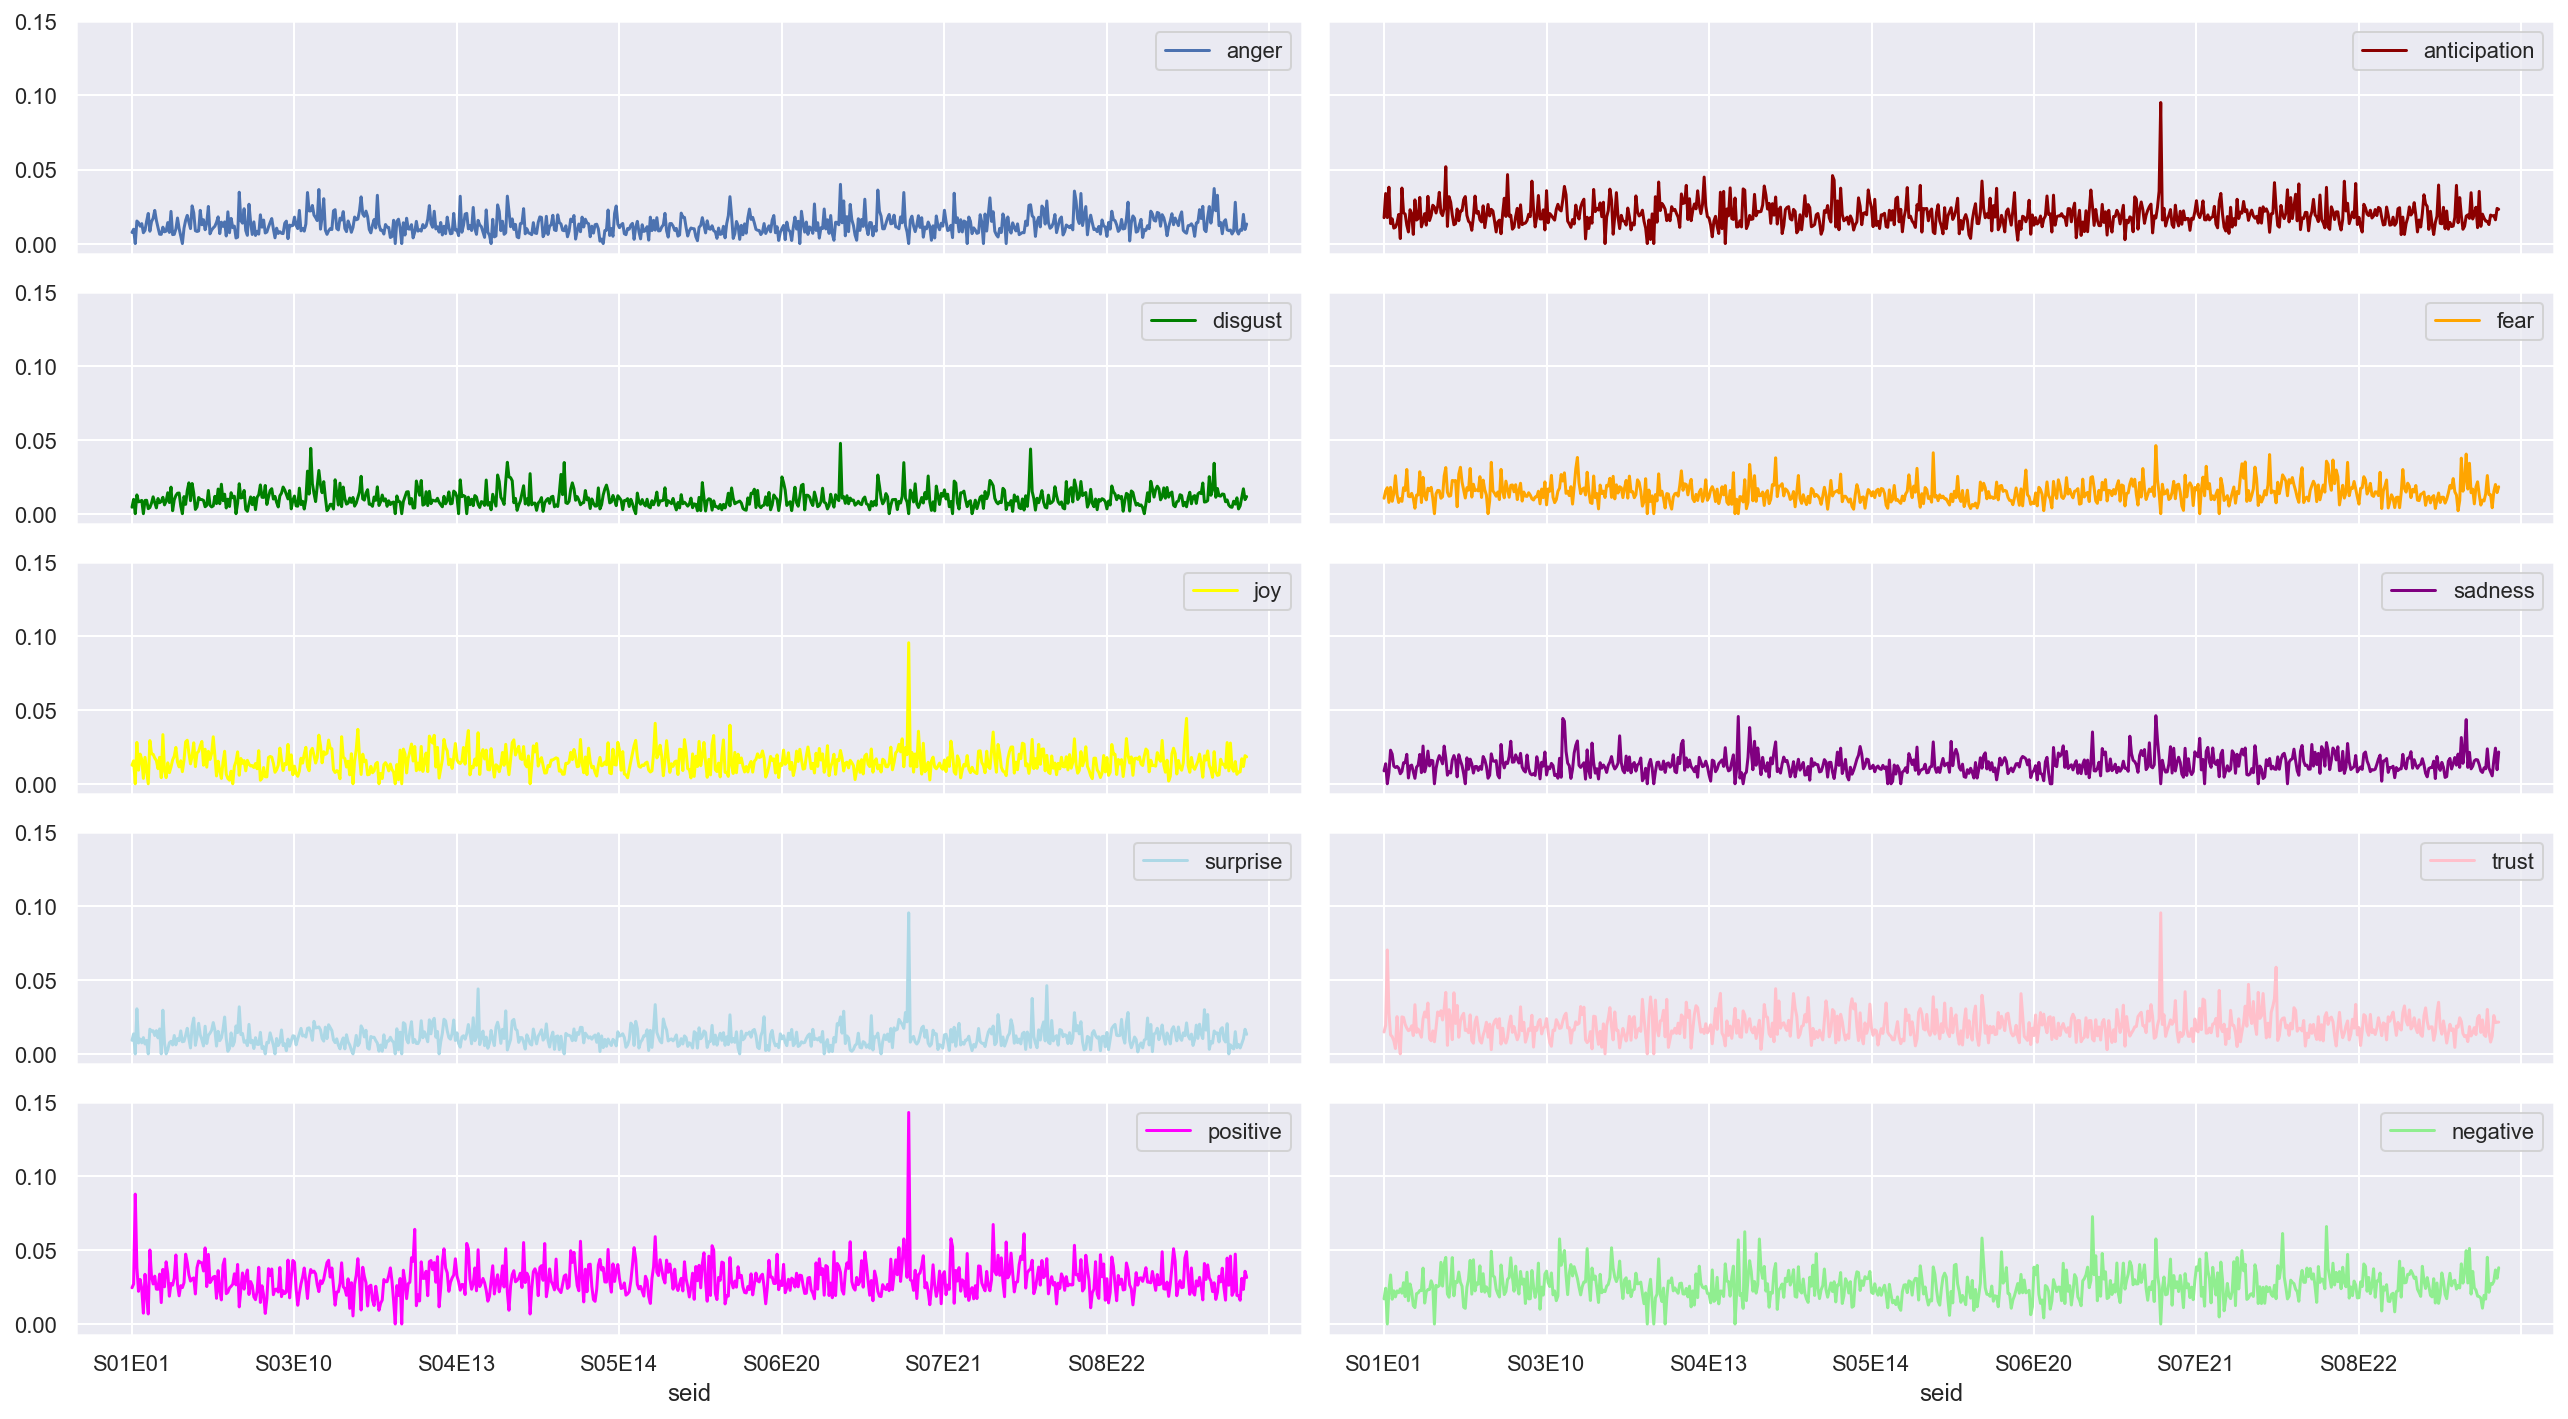

In [1281]:
#fig, axes = plt.subplots(2, 2, figsize=(18, 10))
%matplotlib inline

fig, axes = plt.subplots(5,2, figsize=(18, 10), facecolor='white',sharex=True ,sharey=True)

#['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

# df_emo_all.plot(x ='seid', y='', kind = 'line')
# sns.set(rc={'figure.figsize':(30,10)})
# sns.set_palette("magma")
# plt.tight_layout()
# plt.savefig('line_sent_season.svg')
# ax.grid(False)
# plt.show()

df_emo_all.plot(ax=axes[0,0], x ='seid', y='anger', kind = 'line')
df_emo_all.plot(ax=axes[0,1], x ='seid', y='anticipation', kind = 'line',color=['darkred'])
df_emo_all.plot(ax=axes[1,0], x ='seid', y='disgust', kind = 'line',color=['green'])
df_emo_all.plot(ax=axes[1,1], x ='seid', y='fear', kind = 'line',color=['orange'])
df_emo_all.plot(ax=axes[2,0], x ='seid', y='joy', kind = 'line',color=['yellow'])
df_emo_all.plot(ax=axes[2,1], x ='seid', y='sadness', kind = 'line',color=['purple'])
df_emo_all.plot(ax=axes[3,0], x ='seid', y='surprise', kind = 'line',color=['lightblue'])
df_emo_all.plot(ax=axes[3,1], x ='seid', y='trust', kind = 'line',color=['pink'])
df_emo_all.plot(ax=axes[4,0], x ='seid', y='positive', kind = 'line',color=['magenta'])
df_emo_all.plot(ax=axes[4,1], x ='seid', y='negative', kind = 'line',color=['lightgreen'])

sns.set(rc={'figure.figsize':(40,20)})
#sns.set_palette("magma")

# sns.lineplot(ax=axes[0, 0], data=df_sent_wide_mean[['jerry']])
# sns.lineplot(ax=axes[0, 1], data=df_sent_wide_mean[['george']])
# sns.lineplot(ax=axes[1, 0], data=df_sent_wide_mean[['kramer']])
# sns.lineplot(ax=axes[1, 1], data=df_sent_wide_mean[['elaine']])
# sns.set(rc={'figure.figsize':(12,6)})


#sns.lineplot(data=df_sent_wide[50:75][['george']])

# ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3, fancybox=True, shadow=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)

plt.tight_layout()
plt.savefig('line_sent_season.svg')
ax.grid(False)
plt.show()


In [779]:
from nltk import tokenize
#df_emo3 = df_emo2.copy()
df_emo_all['word_count'] = df_emo_all['lemmatized'].apply(tokenize.word_tokenize).apply(len)

In [780]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust']

In [781]:
for emotion in emotions:
    df_emo_all[emotion] = df_emo_all[emotion] / df_emo_all['word_count']

In [782]:
df_emo_all.head()

character    seid                                         lemmatized  \
0       jerry  S01E01  do you know what this be all about do you know...   
2      george  S01E01  be you through yes it be purple I like it I do...   
144    kramer  S01E01  do you handle any of that commercial real esta...   
215    elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557     jerry  S01E02  so I move into the centre lane now I get ahead...   

     polarity  subjectivity  compound    neg    neu    pos     anger  \
0    0.046940      0.551080    0.9998  0.091  0.754  0.156  0.000002   
2    0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009   
144 -0.060000      0.360000    0.0997  0.073  0.827  0.099  0.000000   
215  0.163866      0.504062    0.9196  0.125  0.719  0.156  0.000039   
557  0.048546      0.515032    0.9670  0.100  0.790  0.110  0.000009   

     anticipation   disgust      fear       joy  negative  positive   sadness  \
0        0.000004  0.000001  0.000003  0.000003  0.000004  0.000006  0.000002   
2        0.000033  0.000009  0.000015  0.000015  0.000023  0.000026  0.000013   
144      0.000308  0.000000  0.000308  0.000000  0.000000  0.001539  0.000000   
215      0.000097  0.000032  0.000019  0.000071  0.000058  0.000097  0.000019   
557      0.000008  0.000005  0.000011  0.000006  0.000020  0.000014  0.000014   

     surprise     trust  word_count  
0    0.000002  0.000004        4128  
2    0.000013  0.000019        1035  
144  0.000000  0.001231          57  
215  0.000077  0.000071         394  
557  0.000005  0.000008        1630

## George only

In [786]:
char=['george']
df_sent_grg = df_emo_all[df_emo_all['character'].isin(char)]
df_sent_grg.head()

character    seid                                         lemmatized  \
2       george  S01E01  be you through yes it be purple I like it I do...   
567     george  S01E02  from the intercom yeah to jerry ready hey elai...   
838     george  S01E03  I have to say something chuckle I have to say ...   
1080    george  S01E04  I never hear he say anything really funny you ...   
1309    george  S02E01  she ca nt kill I right people break up all the...   

      polarity  subjectivity  compound    neg    neu    pos     anger  \
2     0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009   
567   0.150283      0.543423    0.9805  0.126  0.706  0.168  0.000020   
838   0.000486      0.676512   -0.0115  0.074  0.850  0.077  0.000023   
1080  0.080470      0.498217    0.9337  0.091  0.805  0.104  0.000024   
1309  0.153553      0.532973    0.7676  0.132  0.735  0.133  0.000007   

      anticipation   disgust      fear       joy  negative  positive  \
2         0.000033  0.000009  0.000015  0.000015  0.000023  0.000026   
567       0.000016  0.000013  0.000020  0.000025  0.000034  0.000036   
838       0.000030  0.000014  0.000011  0.000014  0.000032  0.000030   
1080      0.000028  0.000016  0.000022  0.000028  0.000026  0.000038   
1309      0.000021  0.000008  0.000014  0.000019  0.000023  0.000036   

       sadness  surprise     trust  word_count  
2     0.000013  0.000013  0.000019        1035  
567   0.000018  0.000011  0.000013         669  
838   0.000016  0.000014  0.000014         662  
1080  0.000020  0.000022  0.000028         703  
1309  0.000013  0.000018  0.000020         949

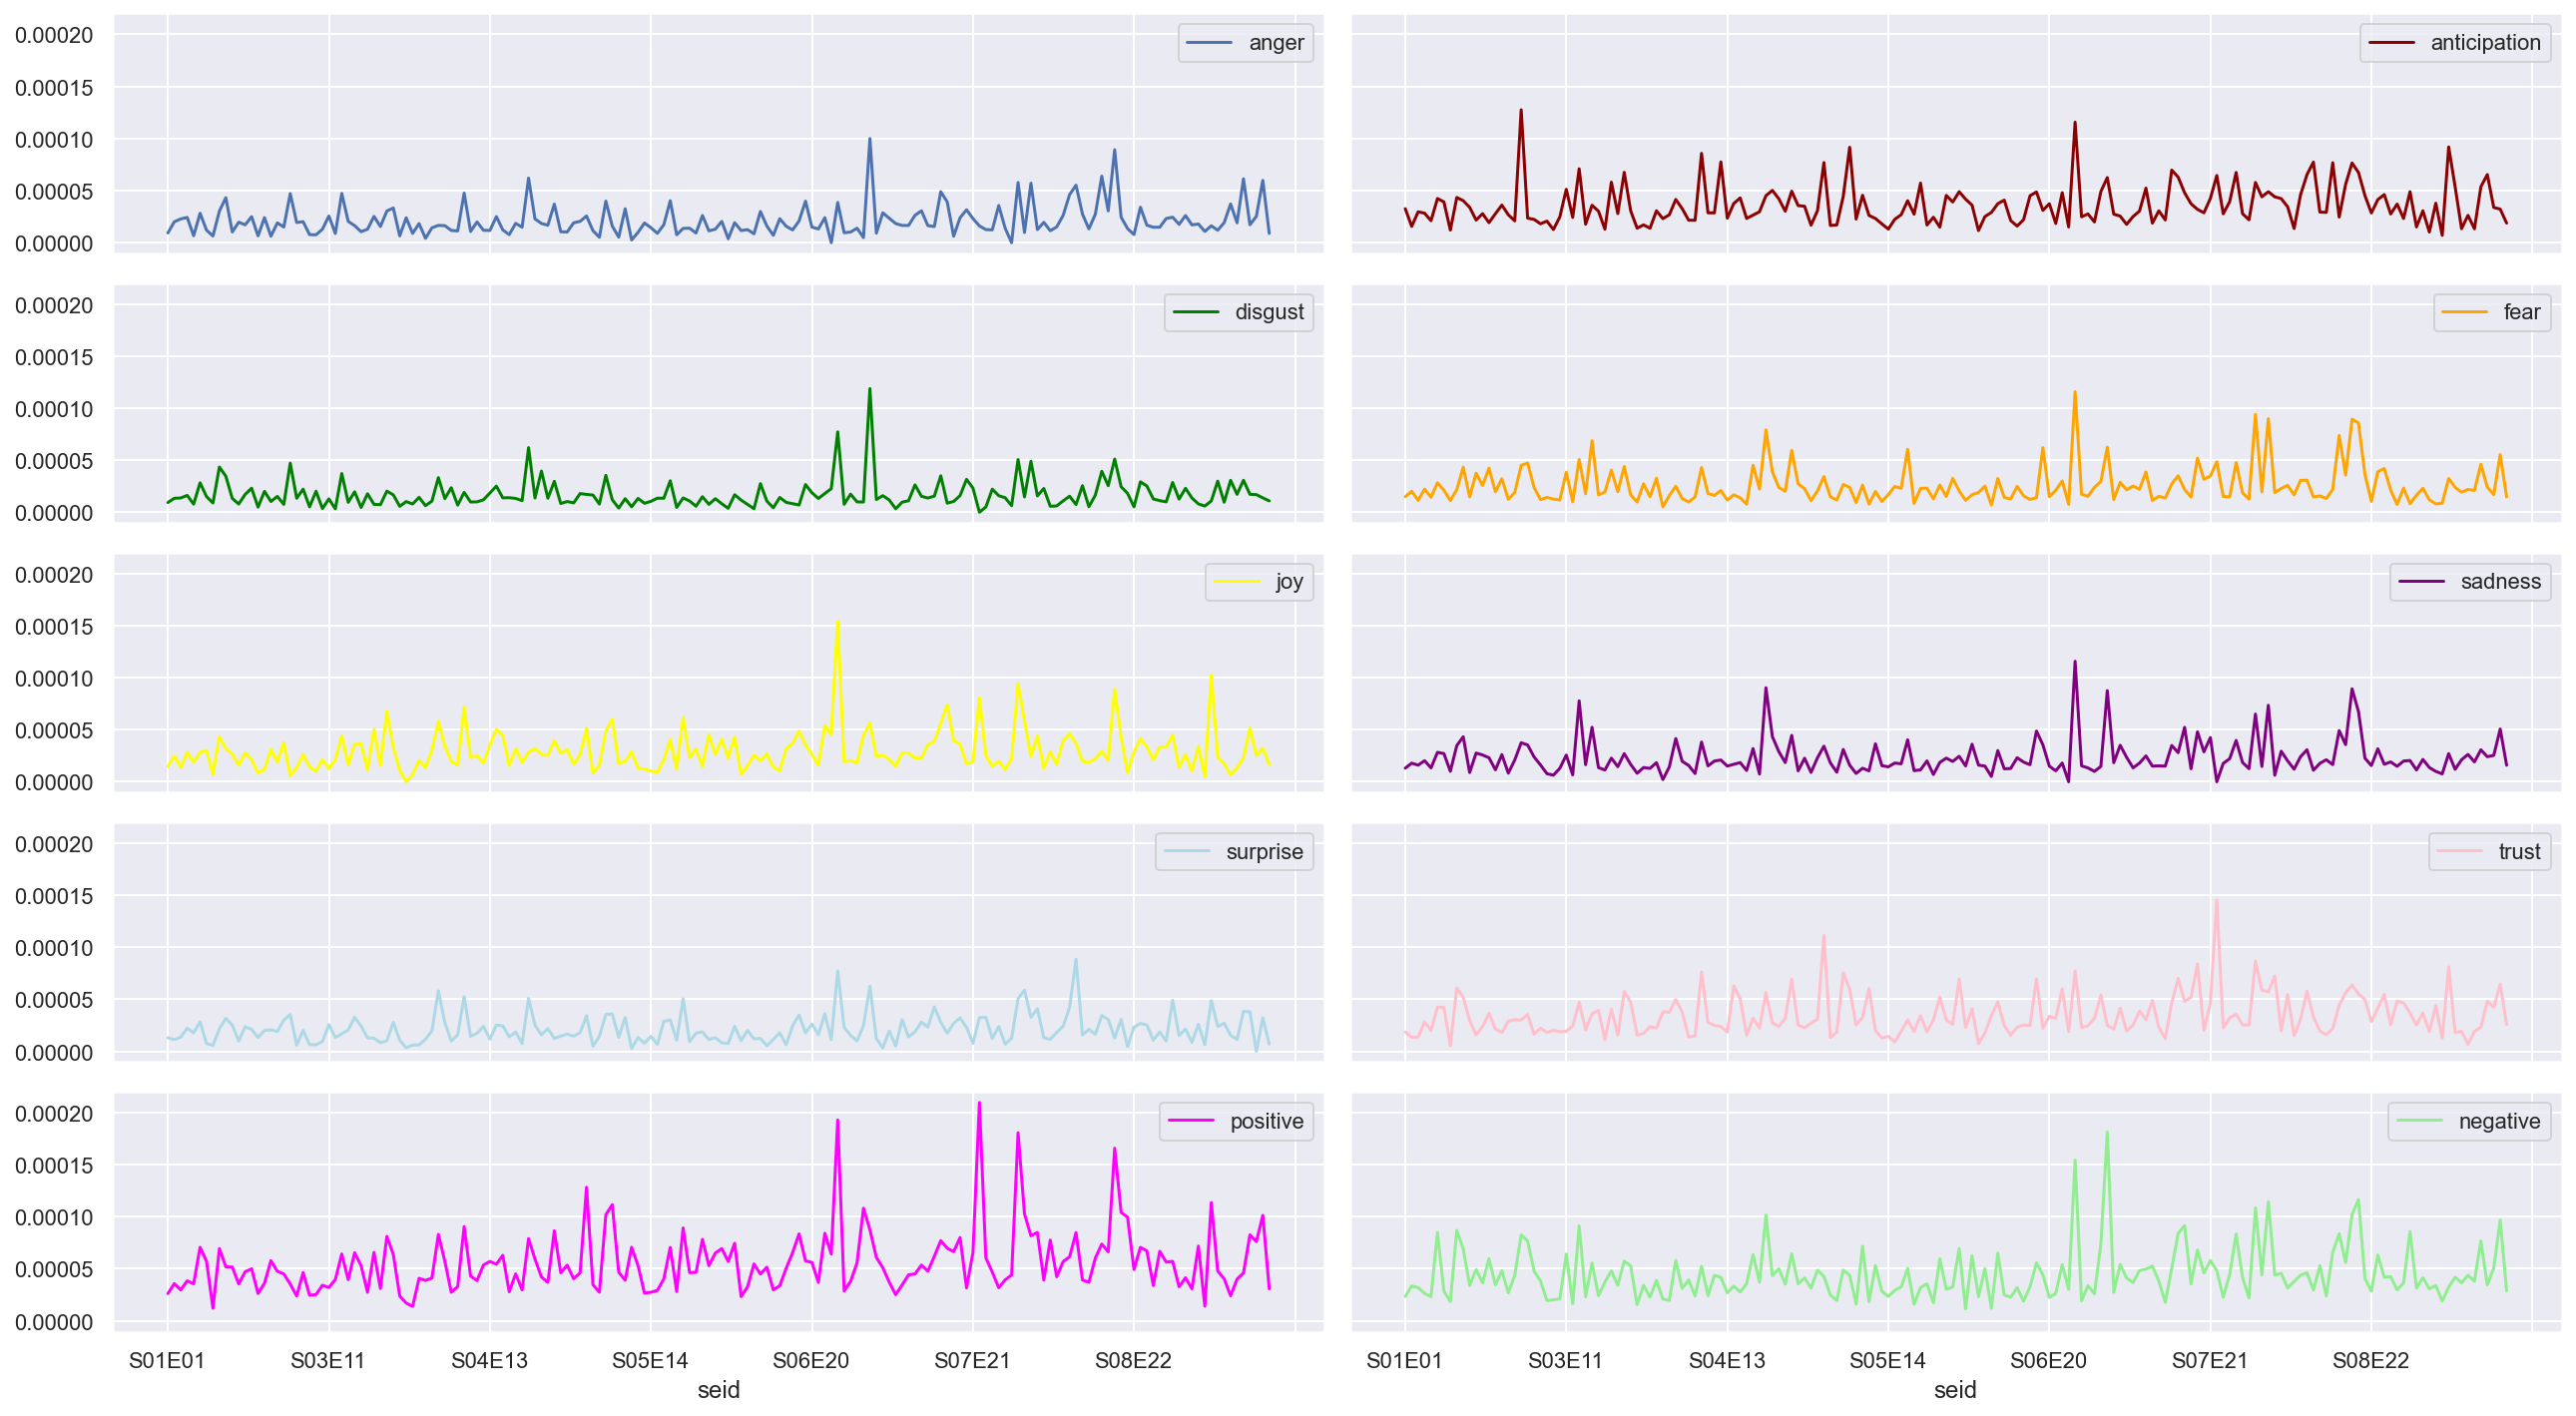

In [787]:
#fig, axes = plt.subplots(2, 2, figsize=(18, 10))
%matplotlib inline

fig, axes = plt.subplots(5,2, figsize=(18, 10), facecolor='white',sharex=True ,sharey=True)

df_sent_grg.plot(ax=axes[0,0], x ='seid', y='anger', kind = 'line')
df_sent_grg.plot(ax=axes[0,1], x ='seid', y='anticipation', kind = 'line',color=['darkred'])
df_sent_grg.plot(ax=axes[1,0], x ='seid', y='disgust', kind = 'line',color=['green'])
df_sent_grg.plot(ax=axes[1,1], x ='seid', y='fear', kind = 'line',color=['orange'])
df_sent_grg.plot(ax=axes[2,0], x ='seid', y='joy', kind = 'line',color=['yellow'])
df_sent_grg.plot(ax=axes[2,1], x ='seid', y='sadness', kind = 'line',color=['purple'])
df_sent_grg.plot(ax=axes[3,0], x ='seid', y='surprise', kind = 'line',color=['lightblue'])
df_sent_grg.plot(ax=axes[3,1], x ='seid', y='trust', kind = 'line',color=['pink'])
df_sent_grg.plot(ax=axes[4,0], x ='seid', y='positive', kind = 'line',color=['magenta'])
df_sent_grg.plot(ax=axes[4,1], x ='seid', y='negative', kind = 'line',color=['lightgreen'])

sns.set(rc={'figure.figsize':(40,20)})
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)

plt.tight_layout()
plt.savefig('line_sent_george.svg')
ax.grid(False)
plt.show()

## George positive and negative using stanford scores

In [788]:
char=['george']
df_sent_grg_pos = df_sent_grg[df_sent_grg["character"].isin(char)].sort_values("positive").groupby("character").tail(40)
df_sent_grg_neg = df_sent_grg[df_sent_grg["character"].isin(char)].sort_values("negative").groupby("character").tail(40)

#df_sent_wide1 = df_nosp.sort_values("polarity").groupby("character").tail(10)
df_sent_grg_neg.head()

character    seid                                         lemmatized  \
34628    george  S07E07  yeah I well grab some too you sure my code no ...   
8466     george  S03E15  its george yeah right give I two buck ill do i...   
30539    george  S06E18  I hope so I ca nt take he live with I much lon...   
45813    george  S08E18  oh boy I be up to four in the morning watch th...   
9916     george  S03E20  boy what a story I m speechless speechless I h...   

       polarity  subjectivity  compound    neg    neu    pos     anger  \
34628  0.012576      0.558235    0.9708  0.093  0.760  0.147  0.000029   
8466   0.115057      0.551631    0.9364  0.102  0.775  0.123  0.000016   
30539  0.157415      0.483249    0.9108  0.093  0.769  0.138  0.000021   
45813  0.044402      0.588552    0.9354  0.093  0.769  0.138  0.000031   
9916   0.034683      0.556454    0.9938  0.106  0.685  0.209  0.000030   

       anticipation   disgust      fear       joy  negative  positive  \
34628      0.000026  0.000016  0.000029  0.000026  0.000054  0.000051   
8466       0.000036  0.000020  0.000069  0.000036  0.000056  0.000065   
30539      0.000049  0.000007  0.000014  0.000049  0.000056  0.000084   
45813      0.000056  0.000025  0.000036  0.000020  0.000056  0.000066   
9916       0.000068  0.000020  0.000044  0.000068  0.000057  0.000081   

        sadness  surprise     trust  word_count  
34628  0.000035  0.000003  0.000041         560  
8466   0.000052  0.000033  0.000036         553  
30539  0.000049  0.000035  0.000070         379  
45813  0.000036  0.000031  0.000056         443  
9916   0.000027  0.000010  0.000057         544

## What are some words used per groups of episodes

## Word Cloud George

**apply only basic stopwords**

In [761]:
base_stop_words = nltk.corpus.stopwords.words('english')

In [765]:
base_add = ['think','need','move','happen','even','ta','na','oh','hey','ca','nt','mr',
            'uh','yeah','gon','thing','come','take','know','make','bubble','ya','go','let','ill','goback','huh']
base_stop_words.extend(base_add)

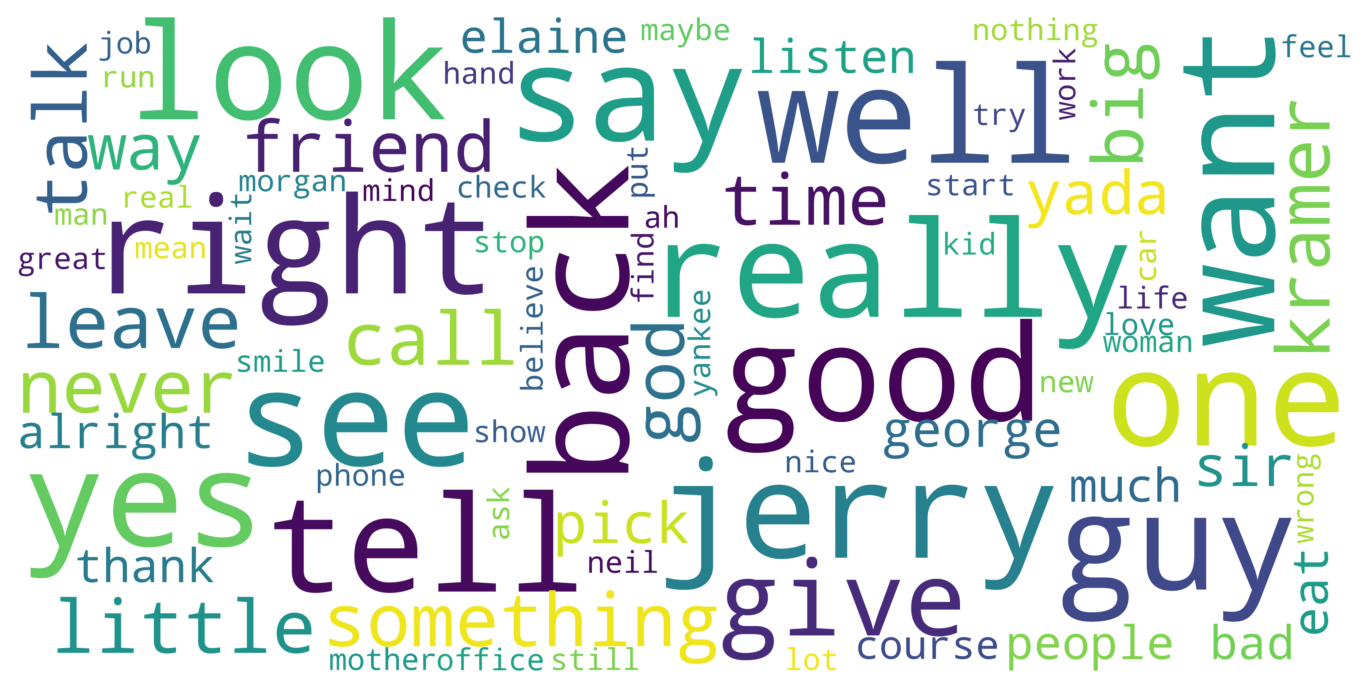

<Figure size 2880x1440 with 0 Axes>

In [790]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

#def wcloud(data):
df_cloud = df_sent_grg_pos.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloud['lemmatized']=df_sent_grg_pos['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_stop_words]))

split_title = [x.split(" ") for x in df_cloud['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


wordcloud = WordCloud(background_color='white', max_words=80, max_font_size=40, scale=10,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_pos_costanza.png')
plt.show()

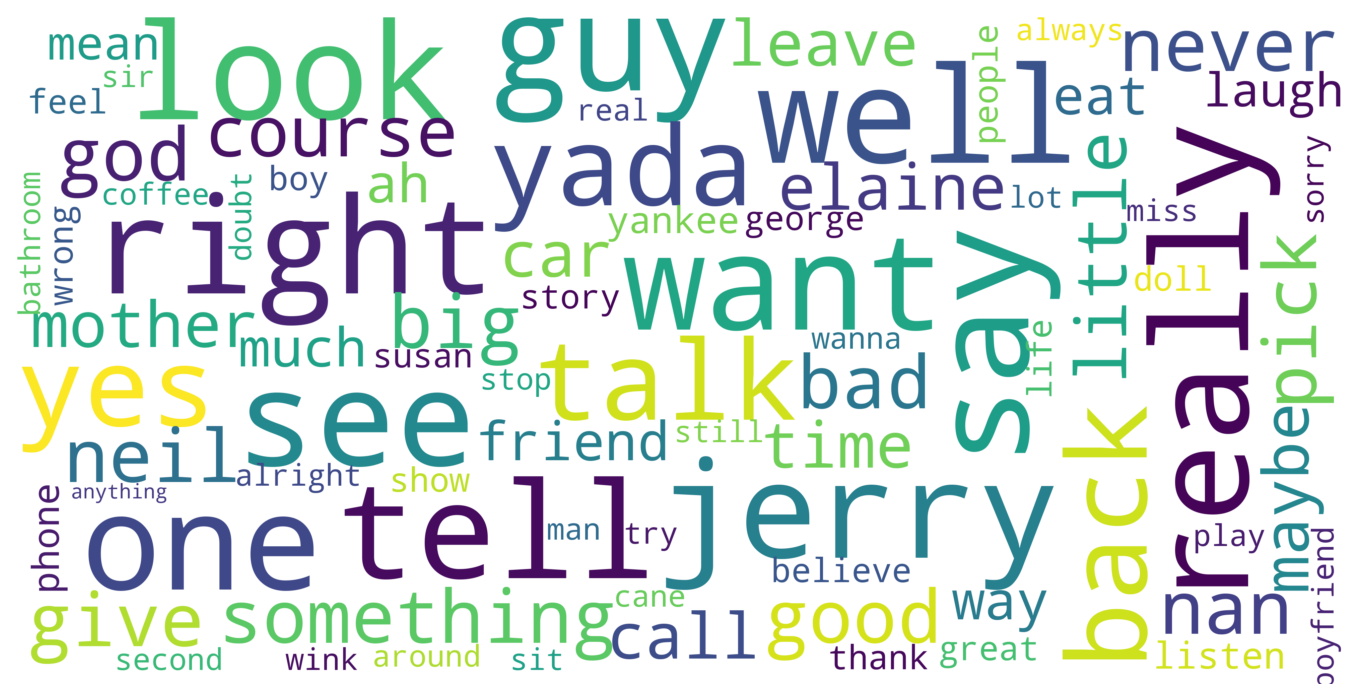

<Figure size 2880x1440 with 0 Axes>

In [791]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# remove stopwords 

#def wcloud(data):
df_cloud = df_sent_grg_neg.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloud['lemmatized']=df_sent_grg_pos['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_stop_words]))

split_title = [x.split(" ") for x in df_cloud['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


wordcloud = WordCloud(background_color='white', max_words=80, max_font_size=40, scale=10,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_pos_costanza.png')
plt.show()

## Attempting color graphs

In [433]:
df_emo_all['season'] = df_emo_all['seid'].astype(str).str[0:3]
df_emo_all['season_num'] = df_emo_all['seid'].astype(str).str[1:3].astype(int)
df_emo_all['episode'] = df_emo_all['seid'].astype(str).str[4:].astype(int)
df_emo_all

character    seid                                         lemmatized  \
0         jerry  S01E01  do you know what this be all about do you know...   
2        george  S01E01  be you through yes it be purple I like it I do...   
144      kramer  S01E01  do you handle any of that commercial real esta...   
215      elaine  S01E01  coccoon ii the return I guess they do nt like ...   
557       jerry  S01E02  so I move into the centre lane now I get ahead...   
...         ...     ...                                                ...   
53573    kramer  S09E20  you know my friend bob saccamano make a fortun...   
53885    george  S09E23  I ca nt eat this without catsup would it kill ...   
53886     jerry  S09E23  I know what you mean its like go out with some...   
53912    kramer  S09E23  hey jojo no thank you so what be you do come o...   
53914    elaine  S09E23  all right thank for the ride kramer oh I forge...   

       polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
0      0.046940      0.551080    0.9998  0.091  0.754  0.156  0.000002  ...   
2      0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009  ...   
144   -0.060000      0.360000    0.0997  0.073  0.827  0.099  0.000000  ...   
215    0.163866      0.504062    0.9196  0.125  0.719  0.156  0.000039  ...   
557    0.048546      0.515032    0.9670  0.100  0.790  0.110  0.000009  ...   
...         ...           ...       ...    ...    ...    ...       ...  ...   
53573  0.116431      0.577812    0.9902  0.088  0.769  0.144  0.000013  ...   
53885  0.032359      0.480758   -0.9563  0.119  0.775  0.106  0.000009  ...   
53886  0.086727      0.540103    0.9456  0.133  0.707  0.160  0.000014  ...   
53912  0.274076      0.536864    0.9870  0.096  0.731  0.172  0.000023  ...   
53914  0.146847      0.577408    0.9903  0.095  0.747  0.158  0.000022  ...   

            joy  negative  positive   sadness  surprise     trust  word_count  \
0      0.000003  0.000004  0.000006  0.000002  0.000002  0.000004        4128   
2      0.000015  0.000023  0.000026  0.000013  0.000013  0.000019        1035   
144    0.000000  0.000000  0.001539  0.000000  0.000000  0.001231          57   
215    0.000071  0.000058  0.000097  0.000019  0.000077  0.000071         394   
557    0.000006  0.000020  0.000014  0.000014  0.000005  0.000008        1630   
...         ...       ...       ...       ...       ...       ...         ...   
53573  0.000011  0.000036  0.000021  0.000007  0.000005  0.000016         748   
53885  0.000017  0.000029  0.000031  0.000016  0.000007  0.000026        1005   
53886  0.000009  0.000027  0.000017  0.000018  0.000007  0.000015        1370   
53912  0.000045  0.000073  0.000085  0.000023  0.000039  0.000051         421   
53914  0.000030  0.000063  0.000052  0.000036  0.000022  0.000036         605   

       season  season_num  episode  
0         S01           1        1  
2         S01           1        1  
144       S01           1        1  
215       S01           1        1  
557       S01           1        2  
...       ...         ...      ...  
53573     S09           9       20  
53885     S09           9       23  
53886     S09           9       23  
53912     S09           9       23  
53914     S09           9       23  

[687 rows x 23 columns]

In [723]:
df_emo_all.reset_index(level=0)

season character                                         lemmatized  \
seid                                                                         
S01E01    S01     jerry  do you know what this be all about do you know...   
S01E01    S01    george  be you through yes it be purple I like it I do...   
S01E01    S01    kramer  do you handle any of that commercial real esta...   
S01E01    S01    elaine  coccoon ii the return I guess they do nt like ...   
S01E02    S01     jerry  so I move into the centre lane now I get ahead...   
...       ...       ...                                                ...   
S09E20    S09    kramer  you know my friend bob saccamano make a fortun...   
S09E23    S09    george  I ca nt eat this without catsup would it kill ...   
S09E23    S09     jerry  I know what you mean its like go out with some...   
S09E23    S09    kramer  hey jojo no thank you so what be you do come o...   
S09E23    S09    elaine  all right thank for the ride kramer oh I forge...   

        polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
seid                                                                     ...   
S01E01  0.046940      0.551080    0.9998  0.091  0.754  0.156  0.000002  ...   
S01E01  0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009  ...   
S01E01 -0.060000      0.360000    0.0997  0.073  0.827  0.099  0.000000  ...   
S01E01  0.163866      0.504062    0.9196  0.125  0.719  0.156  0.000039  ...   
S01E02  0.048546      0.515032    0.9670  0.100  0.790  0.110  0.000009  ...   
...          ...           ...       ...    ...    ...    ...       ...  ...   
S09E20  0.116431      0.577812    0.9902  0.088  0.769  0.144  0.000013  ...   
S09E23  0.032359      0.480758   -0.9563  0.119  0.775  0.106  0.000009  ...   
S09E23  0.086727      0.540103    0.9456  0.133  0.707  0.160  0.000014  ...   
S09E23  0.274076      0.536864    0.9870  0.096  0.731  0.172  0.000023  ...   
S09E23  0.146847      0.577408    0.9903  0.095  0.747  0.158  0.000022  ...   

            fear       joy  negative  positive   sadness  surprise     trust  \
seid                                                                           
S01E01  0.000003  0.000003  0.000004  0.000006  0.000002  0.000002  0.000004   
S01E01  0.000015  0.000015  0.000023  0.000026  0.000013  0.000013  0.000019   
S01E01  0.000308  0.000000  0.000000  0.001539  0.000000  0.000000  0.001231   
S01E01  0.000019  0.000071  0.000058  0.000097  0.000019  0.000077  0.000071   
S01E02  0.000011  0.000006  0.000020  0.000014  0.000014  0.000005  0.000008   
...          ...       ...       ...       ...       ...       ...       ...   
S09E20  0.000005  0.000011  0.000036  0.000021  0.000007  0.000005  0.000016   
S09E23  0.000015  0.000017  0.000029  0.000031  0.000016  0.000007  0.000026   
S09E23  0.000014  0.000009  0.000027  0.000017  0.000018  0.000007  0.000015   
S09E23  0.000034  0.000045  0.000073  0.000085  0.000023  0.000039  0.000051   
S09E23  0.000030  0.000030  0.000063  0.000052  0.000036  0.000022  0.000036   

        word_count  season_num  episode  
seid                                     
S01E01        4128           1        1  
S01E01        1035           1        1  
S01E01          57           1        1  
S01E01         394           1        1  
S01E02        1630           1        2  
...            ...         ...      ...  
S09E20         748           9       20  
S09E23        1005           9       23  
S09E23        1370           9       23  
S09E23         421           9       23  
S09E23         605           9       23  

[687 rows x 22 columns]

In [724]:
df_emo_all.columns

Index(['character', 'lemmatized', 'polarity', 'subjectivity', 'compound',
       'neg', 'neu', 'pos', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'negative', 'positive', 'sadness', 'surprise', 'trust', 'word_count',
       'season_num', 'episode'],
      dtype='object')

In [435]:
df_emo_dict = df_emo_all.drop(['character','lemmatized','polarity','subjectivity','compound','neg','neu','pos','anger',
                               'season_num','episode',
                            'anticipation','disgust','fear','joy','negative','positive','sadness','surprise','trust','word_count'],axis=1)


In [436]:
col_ord = ['season','seid']
df_emo_dict = df_emo_dict[col_ord]
df_emo_dict=df_emo_dict.drop_duplicates(subset=['seid'])
df_emo_dict

season    seid
0        S01  S01E01
557      S01  S01E02
837      S01  S01E03
1078     S01  S01E04
1308     S02  S02E01
...      ...     ...
52607    S09  S09E17
52910    S09  S09E18
53206    S09  S09E19
53569    S09  S09E20
53885    S09  S09E23

[173 rows x 2 columns]

In [437]:
season_all = df_emo_dict['season'].tolist
episodes_all = df_emo_dict['seid'].tolist
#df_emo_dict

In [455]:
episodes_all

<bound method IndexOpsMixin.tolist of 0        S01E01
557      S01E02
837      S01E03
1078     S01E04
1308     S02E01
          ...  
52607    S09E17
52910    S09E18
53206    S09E19
53569    S09E20
53885    S09E23
Name: seid, Length: 173, dtype: object>

In [713]:
seasons = {'S01','S02','S03','S04','S05','S06','S07','S08','S09'}
seasons

{'S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09'}

{book 1 title: {
            'Chapter 1': (chapter title, chapter text),
            'Chapter 2': (chapter title, chapter text),
            'Chapter 3': (chapter title, chapter text),
            ...
            }
'book 2 title': {
            'Chapter 1': (chapter title, chapter text),
            ...
          }
 ...
}

In [714]:
SE1EP1=tuple([1,0])

In [715]:
#seasons = ['emp1','emp2','emp3']

episodes = [
    
         {'S01E01':   (SE1EP1 ) ,
            'S01E02': (SE1EP1 ) ,
            'S01E03': (SE1EP1 ) ,
            'S01E04': (SE1EP1 ) },
         
           {'S02E01': (SE1EP1 ) ,
            'S02E02': (SE1EP1 ) ,
            'S02E03': (SE1EP1 ) ,
            'S02E04': (SE1EP1 ) ,
            'S02E05': (SE1EP1 ) ,
            'S02E06': (SE1EP1 ) ,
            'S02E07': (SE1EP1 ) ,
            'S02E08': (SE1EP1 ) ,
            'S02E09': (SE1EP1 ) ,
            'S02E10': (SE1EP1 ) ,
            'S02E11': (SE1EP1 ) ,
            'S02E12': (SE1EP1 ) },
          
            {'S03E01': (SE1EP1 ) ,
            'S03E02': (SE1EP1 ) ,
          'S03E03': (SE1EP1 ) ,
          'S03E04': (SE1EP1 ) ,
          'S03E05': (SE1EP1 ) ,
          'S03E06': (SE1EP1 ) ,
          'S03E07': (SE1EP1 ) ,
          'S03E08': (SE1EP1 ) ,
          'S03E09': (SE1EP1 ) ,
          'S03E10': (SE1EP1 ) ,
          'S03E11': (SE1EP1 ) ,
          'S03E12': (SE1EP1 ) ,
          'S03E13': (SE1EP1 ) ,
          'S03E14': (SE1EP1 ) ,
          'S03E15': (SE1EP1 ) ,
          'S03E16': (SE1EP1 ) ,
          'S03E17': (SE1EP1 ) ,
          'S03E18': (SE1EP1 ) ,
          'S03E19': (SE1EP1 ) ,
          'S03E20': (SE1EP1 ) ,
          'S03E21': (SE1EP1 ) ,
          'S03E22': (SE1EP1 ) ,
          'S03E23': (SE1EP1 ) },
           
                
          {'S04E01': (SE1EP1 ) ,
          'S04E02': (SE1EP1 ) ,
          'S04E03': (SE1EP1 ) ,
          'S04E04': (SE1EP1 ) ,
          'S04E05': (SE1EP1 ) ,
          'S04E06': (SE1EP1 ) ,
          'S04E07': (SE1EP1 ) ,
          'S04E08': (SE1EP1 ) ,
          'S04E09': (SE1EP1 ) ,
          'S04E10': (SE1EP1 ) ,
          'S04E11': (SE1EP1) ,
          'S04E12': (SE1EP1 ) ,
          'S04E13': (SE1EP1 ) ,
          'S04E14': (SE1EP1 ) ,
          'S04E15': (SE1EP1 ) ,
          'S04E16': (SE1EP1 ) ,
          'S04E17': (SE1EP1 ) ,
          'S04E18': (SE1EP1 ) ,
          'S04E19': (SE1EP1 ) ,
          'S04E20': (SE1EP1 ) ,
          'S04E21': (SE1EP1 ) ,
          'S04E22': (SE1EP1 ) ,
          'S04E23': (SE1EP1 ) ,
          'S04E24': (SE1EP1 ) },
          
         
            {'S05E01': (SE1EP1 ) ,
            'S05E02': (SE1EP1 ) ,
          'S05E03': (SE1EP1 ) ,
          'S05E04': (SE1EP1 ) ,
          'S05E05': (SE1EP1 ) ,
          'S05E06': (SE1EP1 ) ,
          'S05E07': (SE1EP1 ) ,
          'S05E08': (SE1EP1 ) ,
          'S05E09': (SE1EP1 ) ,
          'S05E10': (SE1EP1 ) ,
          'S05E11': (SE1EP1 ) ,
          'S05E12': (SE1EP1 ) ,
          'S05E13': (SE1EP1 ) ,
          'S05E14': (SE1EP1 ) ,
          'S05E15': (SE1EP1 ) ,
          'S05E16': (SE1EP1 ) ,
          'S05E17': (SE1EP1) ,
          'S05E18': (SE1EP1 ) ,
          'S05E19': (SE1EP1 ) ,
          'S05E20': (SE1EP1 ) ,
          'S05E21': (SE1EP1 ) ,
          'S05E22': (SE1EP1 ) },
          
         
          {'S06E01': (SE1EP1 ) ,
          'S06E02': (SE1EP1 ) ,
          'S06E03': (SE1EP1 ) ,
          'S06E04': (SE1EP1 ) ,
          'S06E05': (SE1EP1 ) ,
          'S06E06': (SE1EP1) ,
          'S06E07': (SE1EP1 ) ,
          'S06E08': (SE1EP1 ) ,
          'S06E09': (SE1EP1 ) ,
          'S06E10': (SE1EP1 ) ,
          'S06E11': (SE1EP1 ) ,
          'S06E12': (SE1EP1 ) ,
          'S06E13': (SE1EP1 ) ,
          'S06E14': (SE1EP1 ) ,
          'S06E15': (SE1EP1 ) ,
          'S06E16': (SE1EP1 ) ,
          'S06E17': (SE1EP1 ) ,
          'S06E18': (SE1EP1 ) ,
          'S06E19': (SE1EP1 ) ,
          'S06E20': (SE1EP1 ) ,
          'S06E21': (SE1EP1 ) ,
          'S06E22': (SE1EP1 ) ,
          'S06E23': (SE1EP1 ) ,
          'S06E24': (SE1EP1 ) } ,
          
         
          {'S07E01': (SE1EP1 ) ,
          'S07E02': (SE1EP1 ) ,
          'S07E03': (SE1EP1 ) ,
          'S07E04': (SE1EP1 ) ,
          'S07E05': (SE1EP1 ) ,
          'S07E06': (SE1EP1 ) ,
          'S07E07': (SE1EP1 ) ,
          'S07E08': (SE1EP1 ) ,
          'S07E09': (SE1EP1) ,
          'S07E10': (SE1EP1) ,
          'S07E11': (SE1EP1 ) ,
          'S07E12': (SE1EP1 ) ,
          'S07E13': (SE1EP1 ) ,
          'S07E14': (SE1EP1 ) ,
          'S07E15': (SE1EP1 ) ,
          'S07E16': (SE1EP1 ) ,
          'S07E17': (SE1EP1 ) ,
          'S07E18': (SE1EP1 ) ,
          'S07E19': (SE1EP1 ) ,
          'S07E20': (SE1EP1 ) ,
          'S07E21': (SE1EP1 ) ,
          'S07E22': (SE1EP1 ) ,
          'S07E23': (SE1EP1 ) ,
          'S07E24': (SE1EP1 ) } ,
          
         
             {'S08E01': (SE1EP1 ) ,
            'S08E02': (SE1EP1) ,
          'S08E03': (SE1EP1 ) ,
          'S08E04': (SE1EP1 ) ,
          'S08E05': (SE1EP1 ) ,
          'S08E06': (SE1EP1 ) ,
          'S08E07': (SE1EP1 ) ,
          'S08E08': (SE1EP1 ) ,
          'S08E09': (SE1EP1 ) ,
          'S08E10': (SE1EP1 ) ,
          'S08E11': (SE1EP1 ) ,
          'S08E12': (SE1EP1 ) ,
          'S08E13': (SE1EP1 ) ,
          'S08E14': (SE1EP1 ) ,
          'S08E15': (SE1EP1 ) ,
          'S08E16': (SE1EP1 ) ,
          'S08E17': (SE1EP1 ) ,
          'S08E18': (SE1EP1 ) ,
          'S08E19': (SE1EP1 ) ,
          'S08E20': (SE1EP1) ,
          'S08E21': (SE1EP1) ,
          'S08E22': (SE1EP1 )}   ,    
          
         
          {'S09E01': (SE1EP1 ) ,
          'S09E02': (SE1EP1 ) ,
          'S09E03': (SE1EP1 ) ,
          'S09E04': (SE1EP1 ) ,
          'S09E05': (SE1EP1 ) ,
          'S09E06': (SE1EP1 ) ,
          'S09E07': (SE1EP1) ,
          'S09E08': (SE1EP1 ) ,
          'S09E09': (SE1EP1 ) ,
          'S09E10': (SE1EP1 ) ,
          'S09E11': (SE1EP1 ) ,
          'S09E12': (SE1EP1 ) ,
          'S09E13': (SE1EP1) ,
          'S09E14': (SE1EP1 ) ,
          'S09E15': (SE1EP1 ) ,
          'S09E16': (SE1EP1 ) ,
          'S09E17': (SE1EP1 ) ,
          'S09E18': (SE1EP1 ) ,
          'S09E19': (SE1EP1 ) ,
          'S09E20': (SE1EP1 ) ,
#           'S09E21': ('SE1 EP1' ) ,
#           'S09E22': ('SE1 EP1' ) ,
          'S09E23': (SE1EP1 ) }
    ]

In [716]:
dd=defaultdict(dict)
dd = dict(zip(seasons, episodes))
dd = dict(dd)

In [717]:
dd


{'S08': {'S01E01': (1, 0),
  'S01E02': (1, 0),
  'S01E03': (1, 0),
  'S01E04': (1, 0)},
 'S03': {'S02E01': (1, 0),
  'S02E02': (1, 0),
  'S02E03': (1, 0),
  'S02E04': (1, 0),
  'S02E05': (1, 0),
  'S02E06': (1, 0),
  'S02E07': (1, 0),
  'S02E08': (1, 0),
  'S02E09': (1, 0),
  'S02E10': (1, 0),
  'S02E11': (1, 0),
  'S02E12': (1, 0)},
 'S06': {'S03E01': (1, 0),
  'S03E02': (1, 0),
  'S03E03': (1, 0),
  'S03E04': (1, 0),
  'S03E05': (1, 0),
  'S03E06': (1, 0),
  'S03E07': (1, 0),
  'S03E08': (1, 0),
  'S03E09': (1, 0),
  'S03E10': (1, 0),
  'S03E11': (1, 0),
  'S03E12': (1, 0),
  'S03E13': (1, 0),
  'S03E14': (1, 0),
  'S03E15': (1, 0),
  'S03E16': (1, 0),
  'S03E17': (1, 0),
  'S03E18': (1, 0),
  'S03E19': (1, 0),
  'S03E20': (1, 0),
  'S03E21': (1, 0),
  'S03E22': (1, 0),
  'S03E23': (1, 0)},
 'S04': {'S04E01': (1, 0),
  'S04E02': (1, 0),
  'S04E03': (1, 0),
  'S04E04': (1, 0),
  'S04E05': (1, 0),
  'S04E06': (1, 0),
  'S04E07': (1, 0),
  'S04E08': (1, 0),
  'S04E09': (1, 0),
  'S04E10

In [ ]:
# df_dict = {}
# for lst in df_emo_dict.values:
#     leaf = df_dict
#     for path in lst[:-2]:
#         leaf = leaf.setdefault(path, {})
#     leaf.setdefault(lst[-2], list()).append(lst[-1])
    
#     #leaf[lst[-2]] = lst[-1]
# df_dict

In [ ]:
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*(CHAPTER [A-Z-]+\s*)|(EPILOGUE)\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

In [694]:
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

In [443]:
df_emo_all.set_index(['season', 'seid'],inplace=True)
df_emo_all.head()

character                                         lemmatized  \
season seid                                                                  
S01    S01E01     jerry  do you know what this be all about do you know...   
       S01E01    george  be you through yes it be purple I like it I do...   
       S01E01    kramer  do you handle any of that commercial real esta...   
       S01E01    elaine  coccoon ii the return I guess they do nt like ...   
       S01E02     jerry  so I move into the centre lane now I get ahead...   

               polarity  subjectivity  compound    neg    neu    pos  \
season seid                                                            
S01    S01E01  0.046940      0.551080    0.9998  0.091  0.754  0.156   
       S01E01  0.154769      0.529920    0.9912  0.091  0.774  0.135   
       S01E01 -0.060000      0.360000    0.0997  0.073  0.827  0.099   
       S01E01  0.163866      0.504062    0.9196  0.125  0.719  0.156   
       S01E02  0.048546      0.515032    0.9670  0.100  0.790  0.110   

                  anger  anticipation  ...      fear       joy  negative  \
season seid                            ...                                 
S01    S01E01  0.000002      0.000004  ...  0.000003  0.000003  0.000004   
       S01E01  0.000009      0.000033  ...  0.000015  0.000015  0.000023   
       S01E01  0.000000      0.000308  ...  0.000308  0.000000  0.000000   
       S01E01  0.000039      0.000097  ...  0.000019  0.000071  0.000058   
       S01E02  0.000009      0.000008  ...  0.000011  0.000006  0.000020   

               positive   sadness  surprise     trust  word_count  season_num  \
season seid                                                                     
S01    S01E01  0.000006  0.000002  0.000002  0.000004        4128           1   
       S01E01  0.000026  0.000013  0.000013  0.000019        1035           1   
       S01E01  0.001539  0.000000  0.000000  0.001231          57           1   
       S01E01  0.000097  0.000019  0.000077  0.000071         394           1   
       S01E02  0.000014  0.000014  0.000005  0.000008        1630           1   

               episode  
season seid             
S01    S01E01        1  
       S01E01        1  
       S01E01        1  
       S01E01        1  
       S01E02        2  

[5 rows x 21 columns]

In [372]:
show_indices = {}
idx = 0
for season_all in dd:
    start = idx
    for episode_all in dd[season_all]:
        idx += 1
    show_indices[season_all] = (start, idx)

show_indices

{'S01': (0, 4),
 'S02': (4, 16),
 'S03': (16, 39),
 'S04': (39, 63),
 'S05': (63, 84),
 'S06': (84, 106),
 'S07': (106, 130),
 'S08': (130, 152),
 'S09': (152, 173)}

In [521]:
charlist = ['george'] 
  
# selecting rows based on condition 
df_emo_char = df_emo_all[df_emo_all['character'].isin(charlist)]
df_emo_char.head()

character                                         lemmatized  \
season seid                                                                  
S01    S01E01    george  be you through yes it be purple I like it I do...   
       S01E02    george  from the intercom yeah to jerry ready hey elai...   
       S01E03    george  I have to say something chuckle I have to say ...   
       S01E04    george  I never hear he say anything really funny you ...   
S02    S02E01    george  she ca nt kill I right people break up all the...   

               polarity  subjectivity  compound    neg    neu    pos  \
season seid                                                            
S01    S01E01  0.154769      0.529920    0.9912  0.091  0.774  0.135   
       S01E02  0.150283      0.543423    0.9805  0.126  0.706  0.168   
       S01E03  0.000486      0.676512   -0.0115  0.074  0.850  0.077   
       S01E04  0.080470      0.498217    0.9337  0.091  0.805  0.104   
S02    S02E01  0.153553      0.532973    0.7676  0.132  0.735  0.133   

                  anger  anticipation  ...      fear       joy  negative  \
season seid                            ...                                 
S01    S01E01  0.000009      0.000033  ...  0.000015  0.000015  0.000023   
       S01E02  0.000020      0.000016  ...  0.000020  0.000025  0.000034   
       S01E03  0.000023      0.000030  ...  0.000011  0.000014  0.000032   
       S01E04  0.000024      0.000028  ...  0.000022  0.000028  0.000026   
S02    S02E01  0.000007      0.000021  ...  0.000014  0.000019  0.000023   

               positive   sadness  surprise     trust  word_count  season_num  \
season seid                                                                     
S01    S01E01  0.000026  0.000013  0.000013  0.000019        1035           1   
       S01E02  0.000036  0.000018  0.000011  0.000013         669           1   
       S01E03  0.000030  0.000016  0.000014  0.000014         662           1   
       S01E04  0.000038  0.000020  0.000022  0.000028         703           1   
S02    S02E01  0.000036  0.000013  0.000018  0.000020         949           2   

               episode  
season seid             
S01    S01E01        1  
       S01E02        2  
       S01E03        3  
       S01E04        4  
S02    S02E01        1  

[5 rows x 21 columns]

In [652]:
testingsz=(0,1)

In [682]:
seasons_test = ['S01'] # list
episodes_test = [    # list
           {'E01': testingsz ,
            'E02':testingsz ,
            'E03': testingsz ,
            'E04': testingsz}
]

#dd_test=defaultdict(dict)
dd=dict()
dd_test = dict(zip(seasons_test, episodes_test))
dd_test = dict(dd_test)

In [683]:
dd_test

{'S01': {'E01': (0, 1), 'E02': (0, 1), 'E03': (0, 1), 'E04': (0, 1)}}

In [712]:
length = sum([len(dd[seasons]) for seasons in dd])
x = np.linspace(0, length - 1, num=length)

for emotion in emotions:
    y = [df_emo_char.loc[seasons].loc[dd[seasons][seid][0]][emotion]  for seasons in dd for seid in dd[seasons] ]
    #y = [df_emo2.loc[season].loc[df_dict[season][seid][0]][emotion] for season in df_dict for seid in df_dict[season]]

    print(df_emo_char.loc[seasons].loc[dd[seasons]] )
    plt.figure(figsize=(15, 10))
    for seasons in show_indices:
        
        plt.plot(x[show_indices[seasons][0]: show_indices[seasons][1]],
                 y[show_indices[seasons][0]: show_indices[seasons][1]],
                 label=seasons)
        
        
    #plt.plot(movingaverage(y, 10), color='k', linewidth=3, linestyle=':', label='Moving Average')
    plt.legend(loc='best', fontsize=15, bbox_to_anchor=(1.05, 1))
    plt.title('{} Sentiment of the Seinfeld series'.format(emotion.title()), fontsize=20)
    plt.xlabel('Episodes', fontsize=15)
    plt.ylabel('Average Sentiment', fontsize=15)
    plt.show()

KeyError: 1

In [377]:
df_dict[episode]

KeyError: 'S09E23'

## For tomorrow
**assing topics to datafor george positive and negative
Then you can overlay the topic with the characteristic

. maybe colors of graph
. get presentioant ready
. maybe relationshp chart

## Topic Modeling

In [805]:
def lsa(doc_word, feature_names, num_topics):
    model = TruncatedSVD(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-21:-1]]))

def nmf(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-75:-1]]))

def lda(doc_word, feature_names, id2word, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)
        

def corex(doc_word, feature_names, num_topics):
    words = list(np.asarray(feature_names))
    model = corextopic.Corex(n_hidden=num_topics, words=words, seed=1, max_iter=200)
    model.fit(doc_word, words=words, docs=data) # where data = df["Lemmatized"]
    topics = model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_ = zip(*topic)
        print('{}: '.format(n) + ','.join(topic_words))

In [806]:
def vectorize_2(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words,  min_df=min_df , max_df=max_df) #ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    
    return doc_word, feature_names, id2word

## NMF with min/max df

In [842]:
my_stop_words = nltk.corpus.stopwords.words('english')
stopadd=['alright', 'okay', 'shes', 'hi', 'ha', 'hello', 'ah', 'ha',
         'hello', 'ah', 'huh', 'ok', 'wanna', 'told', 'still','uh',
         'ya', 'mr','dyou', 'um','uhm','whatre', 'cmon', 'ho', 'em','yea','hu',
        'bo','indicating','ykonw','seinfeld', 'yeah','im','gonna',
        'ive', 'theyre', 'said','gotta','lets','say','cars','gon','na','ill','want','look','ta',
        'let','would','come','eh','around','put','ii','make','take','two','way']
my_stop_words.extend(stopadd)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [843]:
data_grg = df_sent_grg["lemmatized"]
#data_pos = df_sent_grg_pos["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [871]:
doc_word, feature_names, id2word= vectorize_2(data_grg,.03,.55)
nmf(doc_word, feature_names, 5)


Topic  0
hand, kramer, parent, leave, big, move, point, thank, happen, mean, maybe, walk, life, salad, much, even, laugh, apartment, eat, stop, need, play, door, man, kid, face, sorry, sit, check, father, hear, work, turn, table, god, dinner, hold, arm, use, dad, year, lunch, mother, find, please, ever, nice, money, wear, job, buy, kind, break, fine, mind, try, room, another, chuckle, anymore, clothe, shirt, shake, whole, place, pick, raise, head, heh, plan, live, may, help, people

Topic  1
car, bar, first, space, candy, move, dollar, park, big, people, maybe, pull, lot, even, pay, parking, walk, great, front, head, spot, door, sorry, start, leave, buy, kramer, need, help, turn, mean, hat, away, window, day, wait, stop, try, drive, name, nobody, anything, hear, sure, stand, coat, believe, kid, please, open, run, hospital, twenty, pick, wrong, might, change, excuse, fine, another, minute, doubt, ask, store, susan, father, chair, heh, bother, nice, listen, fall, much, elaine

Topic  2


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [868]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_grg, 0.03,.65)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.010*"elaine" + 0.010*"kramer" + 0.010*"something" + 0.009*"talk" + 0.008*"call" + 0.008*"woman" + 0.008*"happen" + 0.008*"time" + 0.007*"little" + 0.007*"even" + 0.007*"give" + 0.007*"george" + 0.007*"anything" + 0.007*"people" + 0.007*"show" + 0.007*"never" + 0.007*"stop" + 0.007*"need" + 0.007*"great" + 0.006*"mean" + 0.006*"yes" + 0.006*"day" + 0.006*"try" + 0.006*"nothing" + 0.006*"leave" + 0.005*"maybe" + 0.005*"buy" + 0.005*"ask" + 0.005*"nice" + 0.005*"name" + 0.005*"big" + 0.005*"start" + 0.005*"hear" + 0.005*"care" + 0.005*"laugh" + 0.005*"sorry" + 0.005*"friend" + 0.005*"point" + 0.005*"believe" + 0.005*"excuse" + 0.004*"live" + 0.004*"funny" + 0.004*"meet" + 0.004*"lot" + 0.004*"minute" + 0.004*"phone" + 0.004*"wait" + 0.004*"first" + 0.004*"always" + 0.004*"guy"

Topic  1
0.012*"call" + 0.010*"yes" + 0.009*"something" + 0.009*"george" + 0.008*"guy" + 0.008*"big" + 0.008*"little" + 0.008*"try" + 0.008*"wait" + 0.007*"give" + 0.007*"talk" + 0.007*"happen" + 0.006*

In [869]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Nouns only

In [877]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [878]:
df_nouns = df_sent_grg.copy()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [879]:
df_nouns.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(172, 20)

In [880]:
df_nouns = pd.DataFrame(df_sent_grg['lemmatized'].apply(nouns))
df_nouns

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lemmatized
2      yes button microphone uh time orange indicator...
567    intercom yeah hey airport actresswaitress some...
838    something chuckle something everything somethi...
1080   anything sense humor sun krypton way sun earth...
1309   people time look face i love choice tell right...
...                                                  ...
52607  brentanos place girl york head act answer buck...
52948  mario pizza remember slice grape soda hey frog...
53206  voice jerry george nickname nothing get zip ni...
53569  man ballpark food food movie hindenburg story ...
53885  catsup thing s everything anything thing excus...

[172 rows x 1 columns]

## Convert Nouns DF to Data for modeling


In [881]:
data_nouns = df_nouns["lemmatized"]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## NMF with min/max df

In [940]:
my_stop_words = nltk.corpus.stopwords.words('english')
stopadd=['alright', 'okay', 'shes', 'hi', 'ha', 'hello', 'ah', 'ha',
         'hello', 'ah', 'huh', 'ok', 'wanna', 'told', 'still','uh',
         'ya', 'mr','dyou', 'um','uhm','whatre', 'cmon', 'ho', 'em','yea','hu',
        'bo','indicating','ykonw','seinfeld', 'yeah','im','gonna',
        'ive', 'theyre', 'said','gotta','lets','say','cars','gon','na','ill','want','look','ta',
        'let','would','come','eh','around','put','ii','make','take','two','way','call','man','anything','day','right','minute',
        'oh','everything','boy','yes','try','hour','someone','line','well','matter','word','give','one','point','room','course','people']
my_stop_words.extend(stopadd)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [946]:
doc_word, feature_names, id2word= vectorize_2(data_nouns,.05,.50)
nmf(doc_word, feature_names, 6)


Topic  0
george, door, world, elaine, name, susan, bar, movie, today, lot, relationship, girl, head, talk, jacket, coat, phone, exit, face, friend, get, stuff, table, dollar, book, gesture, heh, answer, problem, costanza, window, hang, anybody, work, nt, hell, arm, glass, shoe, fly, please, pick, change, idea, shop, fault, difference, place, week, figure, chair, question, floor, laugh, air, sense, thank, notice, side, bathroom, enter, seat, excuse, secretary, eye, year, bite, club, sorry, part, walk, god, mouth, weekend

Topic  1
car, bar, lot, dollar, spot, front, park, phone, window, store, coat, kramer, head, help, wait, please, father, hell, door, city, hat, back, party, woman, walk, name, friend, heh, sorry, deal, question, nobody, cause, move, somebody, mirror, machine, talk, turn, start, kid, bit, fine, business, pay, job, house, floor, week, face, twenty, excuse, notice, life, get, chair, kind, drive, street, finger, baby, listen, buck, shout, fall, anybody, mother, yankee, se

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


## LDA with min/max df

In [845]:
from gensim.corpora.dictionary import Dictionary

def vectorize_vis(data, min_df,max_df):
    vec = CountVectorizer(stop_words=my_stop_words, min_df=min_df, max_df=max_df) #, ngram_range=(1, 3)
    doc_word = vec.fit_transform(data)
    feature_names = vec.get_feature_names()
    id2word = dict((v, k) for k, v in vec.vocabulary_.items())
    dictionary = Dictionary([feature_names])
    
    return doc_word, feature_names, id2word, dictionary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [846]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def lda_vis(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)    
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    vis_data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis_data

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1005]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_nouns, 0.03,.85)

vis_data = lda_vis(doc_word, feature_names, id2word, dictionary, 4)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.047*"jerry" + 0.026*"time" + 0.023*"something" + 0.021*"hey" + 0.021*"thing" + 0.020*"george" + 0.013*"nothing" + 0.012*"work" + 0.010*"woman" + 0.010*"guy" + 0.009*"bathroom" + 0.009*"night" + 0.009*"job" + 0.008*"elaine" + 0.008*"phone" + 0.008*"name" + 0.008*"lot" + 0.008*"kramer" + 0.008*"parent" + 0.007*"week" + 0.007*"hand" + 0.007*"plane" + 0.007*"car" + 0.007*"place" + 0.007*"get" + 0.006*"movie" + 0.006*"deal" + 0.006*"show" + 0.006*"sex" + 0.006*"house" + 0.006*"morning" + 0.006*"hell" + 0.006*"mother" + 0.006*"life" + 0.006*"door" + 0.006*"head" + 0.005*"ticket" + 0.005*"friend" + 0.005*"thank" + 0.005*"wait" + 0.005*"finger" + 0.005*"money" + 0.005*"problem" + 0.005*"tomorrow" + 0.005*"year" + 0.005*"nt" + 0.004*"today" + 0.004*"office" + 0.004*"world" + 0.004*"game"

Topic  1
0.028*"thing" + 0.026*"woman" + 0.025*"jerry" + 0.021*"something" + 0.020*"hey" + 0.019*"guy" + 0.015*"nothing" + 0.013*"george" + 0.013*"hand" + 0.012*"time" + 0.010*"god" + 0.010*"kind" 

In [1006]:
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA Doc_Topic Matrix

In [972]:
def lda_dt(doc_word, feature_names, id2word, dictionary, num_topics):
    corpus = matutils.Sparse2Corpus(doc_word.transpose())
    model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=5, random_state=42)
    topics = model.print_topics(num_words=50)
    for n, topic in topics:
        print("\nTopic ", n)
        print(topic)

    return model, corpus



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [975]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_nouns, 0.03,0.85)

lda_model, corpus = lda_dt(doc_word, feature_names, id2word, dictionary, 5)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic  0
0.049*"jerry" + 0.026*"time" + 0.024*"hey" + 0.023*"george" + 0.022*"something" + 0.019*"thing" + 0.012*"woman" + 0.011*"work" + 0.011*"nothing" + 0.011*"elaine" + 0.011*"name" + 0.010*"parent" + 0.009*"guy" + 0.009*"night" + 0.009*"bathroom" + 0.009*"kramer" + 0.009*"get" + 0.009*"deal" + 0.008*"sex" + 0.008*"hand" + 0.008*"week" + 0.007*"plane" + 0.007*"friend" + 0.007*"lot" + 0.007*"mother" + 0.006*"head" + 0.006*"place" + 0.006*"ticket" + 0.006*"door" + 0.006*"thank" + 0.006*"job" + 0.006*"today" + 0.006*"tomorrow" + 0.006*"house" + 0.005*"life" + 0.005*"finger" + 0.005*"money" + 0.005*"nt" + 0.005*"world" + 0.005*"show" + 0.005*"piece" + 0.005*"problem" + 0.005*"year" + 0.005*"conversation" + 0.005*"kid" + 0.005*"phone" + 0.005*"dinner" + 0.004*"hell" + 0.004*"anyone" + 0.004*"wait"

Topic  1
0.028*"thing" + 0.024*"jerry" + 0.021*"woman" + 0.020*"something" + 0.020*"hey" + 0.019*"guy" + 0.017*"nothing" + 0.013*"hand" + 0.013*"time" + 0.013*"george" + 0.011*"place" + 0.01

In [953]:
lda_corpus = lda_model[corpus]
lda_corpus

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [954]:
lda_docs = [doc for doc in lda_corpus]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [955]:
lda_docs[0:2]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 0.725924), (1, 0.26777515)], [(0, 0.21965271), (3, 0.7693699)]]

In [956]:
def topic_weights_to_matrix(topic_weights, doc_ids=None, topic_ids=None):
    topic_dicts = [dict(doc) for doc in topic_weights]
    doc_to_top_mat = pd.DataFrame(topic_dicts).fillna(0)
    if doc_ids:
        doc_to_top_mat.rename(index=lambda ind: doc_ids[ind], inplace=True)
    if topic_ids:
        doc_to_top_mat.rename(columns=lambda ind: topic_ids[ind], inplace=True)
    return doc_to_top_mat

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**THis gives us an idea of the weights per topic per episode**

In [957]:
doc_topic_matrix = topic_weights_to_matrix(lda_docs)
doc_topic_matrix

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0         1         3         2         4
0    0.725924  0.267775  0.000000  0.000000  0.000000
1    0.219653  0.000000  0.769370  0.000000  0.000000
2    0.000000  0.000000  0.987760  0.000000  0.000000
3    0.000000  0.000000  0.823047  0.077308  0.093600
4    0.000000  0.631214  0.238933  0.125185  0.000000
..        ...       ...       ...       ...       ...
167  0.978377  0.000000  0.000000  0.000000  0.000000
168  0.000000  0.000000  0.433870  0.000000  0.552106
169  0.518636  0.457699  0.000000  0.000000  0.000000
170  0.574160  0.000000  0.000000  0.408208  0.000000
171  0.535605  0.000000  0.000000  0.000000  0.459268

[172 rows x 5 columns]

In [958]:
doc_topic = doc_topic_matrix.values
doc_topic

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[0.72592402, 0.26777515, 0.        , 0.        , 0.        ],
       [0.21965271, 0.        , 0.7693699 , 0.        , 0.        ],
       [0.        , 0.        , 0.98775977, 0.        , 0.        ],
       [0.        , 0.        , 0.82304746, 0.07730804, 0.09359973],
       [0.        , 0.63121426, 0.23893327, 0.12518495, 0.        ],
       [0.94583547, 0.0134816 , 0.01351743, 0.01357914, 0.01358639],
       [0.        , 0.        , 0.        , 0.9879052 , 0.        ],
       [0.        , 0.        , 0.99333376, 0.        , 0.        ],
       [0.21338138, 0.        , 0.        , 0.77546972, 0.        ],
       [0.35311934, 0.63375783, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.98962587],
       [0.        , 0.        , 0.49775514, 0.49276257, 0.        ],
       [0.88442248, 0.10395747, 0.        , 0.        , 0.        ],
       [0.        , 0.98990583, 0.        , 0.        , 0.        ],
       [0.01797336, 0.        , 0.

## NMF Doc Topics for actual topics


## Doc_Topic Matrix

In [980]:
def nmf_dt(doc_word, feature_names, num_topics):
    model = NMF(num_topics)
    doc_topic = model.fit_transform(doc_word)
    for ix, topic in enumerate(model.components_):
        print("\nTopic ", ix)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-100:-1]]))
    return model, doc_topic

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1012]:
doc_word, feature_names, id2word, dictionary = vectorize_vis(data_nouns, 0.03,0.55)

nmf_model, doc_topic = nmf_dt(doc_word, feature_names, 4)



Topic  0
george, coffee, woman, elaine, door, phone, night, bathroom, friend, work, world, office, today, machine, hell, wait, lot, problem, thank, date, toe, apartment, face, anyone, year, home, stuff, susan, god, head, sex, talk, story, nothing, please, dollar, hair, tape, movie, laugh, table, get, book, tell, place, kramer, girl, love, question, relationship, message, costanza, bald, nt, window, shop, kind, tomorrow, chair, jacket, person, walk, game, money, mind, eye, excuse, exit, ball, anybody, mother, voice, coat, chance, move, cup, food, break, sort, ticket, somebody, vandelay, pick, oclock, floor, see, smile, hang, side, listen, morning, watch, week, test, glass, arm, fact, doctor, cousin

Topic  1
car, bar, candy, space, dollar, lot, spot, front, park, door, window, head, coat, parking, kramer, father, store, please, phone, name, help, back, wait, hell, hat, hospital, city, heh, move, party, kid, machine, bill, job, deal, sorry, walk, mirror, nobody, talk, turn, start, choco

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Bring topics to DF

In [1013]:
df_grg_top = pd.DataFrame(df_sent_grg)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1014]:
df_grg_top['season'] = df_sent_grg['seid'].astype(str).str[0:3]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1015]:
df_grg_top['topic']=doc_topic.argmax(axis=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1016]:
df_grg_top

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


character    seid                                         lemmatized  \
2        george  S01E01  be you through yes it be purple I like it I do...   
567      george  S01E02  from the intercom yeah to jerry ready hey elai...   
838      george  S01E03  I have to say something chuckle I have to say ...   
1080     george  S01E04  I never hear he say anything really funny you ...   
1309     george  S02E01  she ca nt kill I right people break up all the...   
...         ...     ...                                                ...   
52607    george  S09E17  I read somewhere that this brentanos be the pl...   
52948    george  S09E18  mario pizza just as she be hey mario remember ...   
53206    george  S09E19  what happen to your voice well jerry I be thin...   
53569    george  S09E20  man I m starve because ballpark food do nt cou...   
53885    george  S09E23  I ca nt eat this without catsup would it kill ...   

       polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
2      0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009  ...   
567    0.150283      0.543423    0.9805  0.126  0.706  0.168  0.000020  ...   
838    0.000486      0.676512   -0.0115  0.074  0.850  0.077  0.000023  ...   
1080   0.080470      0.498217    0.9337  0.091  0.805  0.104  0.000024  ...   
1309   0.153553      0.532973    0.7676  0.132  0.735  0.133  0.000007  ...   
...         ...           ...       ...    ...    ...    ...       ...  ...   
52607 -0.120168      0.475488    0.5950  0.096  0.790  0.114  0.000061  ...   
52948  0.194698      0.483692    0.9932  0.045  0.809  0.146  0.000017  ...   
53206  0.148031      0.412009    0.9806  0.072  0.758  0.170  0.000025  ...   
53569  0.036885      0.578442   -0.9430  0.128  0.766  0.106  0.000060  ...   
53885  0.032359      0.480758   -0.9563  0.119  0.775  0.106  0.000009  ...   

           fear       joy  negative  positive   sadness  surprise     trust  \
2      0.000015  0.000015  0.000023  0.000026  0.000013  0.000013  0.000019   
567    0.000020  0.000025  0.000034  0.000036  0.000018  0.000011  0.000013   
838    0.000011  0.000014  0.000032  0.000030  0.000016  0.000014  0.000014   
1080   0.000022  0.000028  0.000026  0.000038  0.000020  0.000022  0.000028   
1309   0.000014  0.000019  0.000023  0.000036  0.000013  0.000018  0.000020   
...         ...       ...       ...       ...       ...       ...       ...   
52607  0.000046  0.000023  0.000077  0.000046  0.000031  0.000038  0.000023   
52948  0.000024  0.000052  0.000034  0.000083  0.000024  0.000038  0.000048   
53206  0.000017  0.000025  0.000051  0.000076  0.000025  0.000000  0.000042   
53569  0.000055  0.000032  0.000097  0.000101  0.000051  0.000032  0.000064   
53885  0.000015  0.000017  0.000029  0.000031  0.000016  0.000007  0.000026   

       word_count  season  topic  
2            1035     S01      0  
567           669     S01      0  
838           662     S01      3  
1080          703     S01      0  
1309          949     S02      0  
...           ...     ...    ...  
52607         361     S09      3  
52948         539     S09      3  
53206         344     S09      0  
53569         466     S09      3  
53885        1005     S09      2  

[172 rows x 22 columns]

In [1037]:
def label_top(row):
    if row['topic'] == 0 :
        return '0: Dating, Relationships, Sex '
    elif row['topic'] == 1 :
        return '1: NY Outings'
    elif row['topic'] == 2 :
        return '2: Job, Occupation, Ideas'
    elif row['topic'] == 3 :
        return '3: Family, Food'
    
    return 'Other'

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1038]:
df_grg_top.apply(lambda row: label_top(row), axis=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2        0: Dating, Relationships, Sex 
567      0: Dating, Relationships, Sex 
838                     3: Family, Food
1080     0: Dating, Relationships, Sex 
1309     0: Dating, Relationships, Sex 
                      ...              
52607                   3: Family, Food
52948                   3: Family, Food
53206    0: Dating, Relationships, Sex 
53569                   3: Family, Food
53885         2: Job, Occupation, Ideas
Length: 172, dtype: object

In [1039]:
df_grg_top['topic_label'] = df_grg_top.apply(lambda row: label_top(row), axis=1)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1040]:
df_grg_top.to_csv('grg_nmf_topics.csv')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1043]:
df_grg_top.topic_label.value_counts()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0: Dating, Relationships, Sex     60
3: Family, Food                   54
2: Job, Occupation, Ideas         39
1: NY Outings                     19
Name: topic_label, dtype: int64

**NMF count topics by season**

In [1019]:
df_grg_top.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


character    seid                                         lemmatized  \
2       george  S01E01  be you through yes it be purple I like it I do...   
567     george  S01E02  from the intercom yeah to jerry ready hey elai...   
838     george  S01E03  I have to say something chuckle I have to say ...   
1080    george  S01E04  I never hear he say anything really funny you ...   
1309    george  S02E01  she ca nt kill I right people break up all the...   

      polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
2     0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009  ...   
567   0.150283      0.543423    0.9805  0.126  0.706  0.168  0.000020  ...   
838   0.000486      0.676512   -0.0115  0.074  0.850  0.077  0.000023  ...   
1080  0.080470      0.498217    0.9337  0.091  0.805  0.104  0.000024  ...   
1309  0.153553      0.532973    0.7676  0.132  0.735  0.133  0.000007  ...   

          fear       joy  negative  positive   sadness  surprise     trust  \
2     0.000015  0.000015  0.000023  0.000026  0.000013  0.000013  0.000019   
567   0.000020  0.000025  0.000034  0.000036  0.000018  0.000011  0.000013   
838   0.000011  0.000014  0.000032  0.000030  0.000016  0.000014  0.000014   
1080  0.000022  0.000028  0.000026  0.000038  0.000020  0.000022  0.000028   
1309  0.000014  0.000019  0.000023  0.000036  0.000013  0.000018  0.000020   

      word_count  season  topic  
2           1035     S01      0  
567          669     S01      0  
838          662     S01      3  
1080         703     S01      0  
1309         949     S02      0  

[5 rows x 22 columns]

In [1045]:
#drop_list = counter[counter['speaker'] == 'SEP'].index
#counter = counter.drop(drop_list)
df_grg_nmf = df_grg_top.copy()
df_grg_nmf = df_grg_top[['season','topic_label','lemmatized']]
df_grg_nmf = df_grg_nmf.groupby(['season','topic_label'], as_index = False).count()
df_grg_nmf
df_grg_nmf = df_grg_nmf.sort_values('topic_label', ascending= True)
df_grg_nmf.columns = ['season','topic_label','episode_count']
df_grg_nmf = df_grg_nmf.reset_index(drop = True)
df_grg_nmf.iloc[:20]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


season                     topic_label  episode_count
0     S01  0: Dating, Relationships, Sex               3
1     S05  0: Dating, Relationships, Sex               5
2     S07  0: Dating, Relationships, Sex               8
3     S04  0: Dating, Relationships, Sex               2
4     S08  0: Dating, Relationships, Sex               8
5     S06  0: Dating, Relationships, Sex              12
6     S09  0: Dating, Relationships, Sex               7
7     S02  0: Dating, Relationships, Sex               5
8     S03  0: Dating, Relationships, Sex              10
9     S03                   1: NY Outings              5
10    S06                   1: NY Outings              2
11    S04                   1: NY Outings              4
12    S07                   1: NY Outings              4
13    S09                   1: NY Outings              2
14    S05                   1: NY Outings              2
15    S08       2: Job, Occupation, Ideas              7
16    S06       2: Job, Occupation, Ideas              2
17    S07       2: Job, Occupation, Ideas              6
18    S05       2: Job, Occupation, Ideas              3
19    S09       2: Job, Occupation, Ideas              2

In [1046]:
df_grg_nmf_wide = df_grg_nmf.pivot("season","topic_label","episode_count")
df_grg_nmf_wide

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic_label  0: Dating, Relationships, Sex   1: NY Outings  \
season                                                       
S01                                     3.0            NaN   
S02                                     5.0            NaN   
S03                                    10.0            5.0   
S04                                     2.0            4.0   
S05                                     5.0            2.0   
S06                                    12.0            2.0   
S07                                     8.0            4.0   
S08                                     8.0            NaN   
S09                                     7.0            2.0   

topic_label  2: Job, Occupation, Ideas  3: Family, Food  
season                                                   
S01                                NaN              1.0  
S02                                3.0              4.0  
S03                                5.0              2.0  
S04                               11.0              7.0  
S05                                3.0             11.0  
S06                                2.0              6.0  
S07                                6.0              6.0  
S08                                7.0              7.0  
S09                                2.0             10.0

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


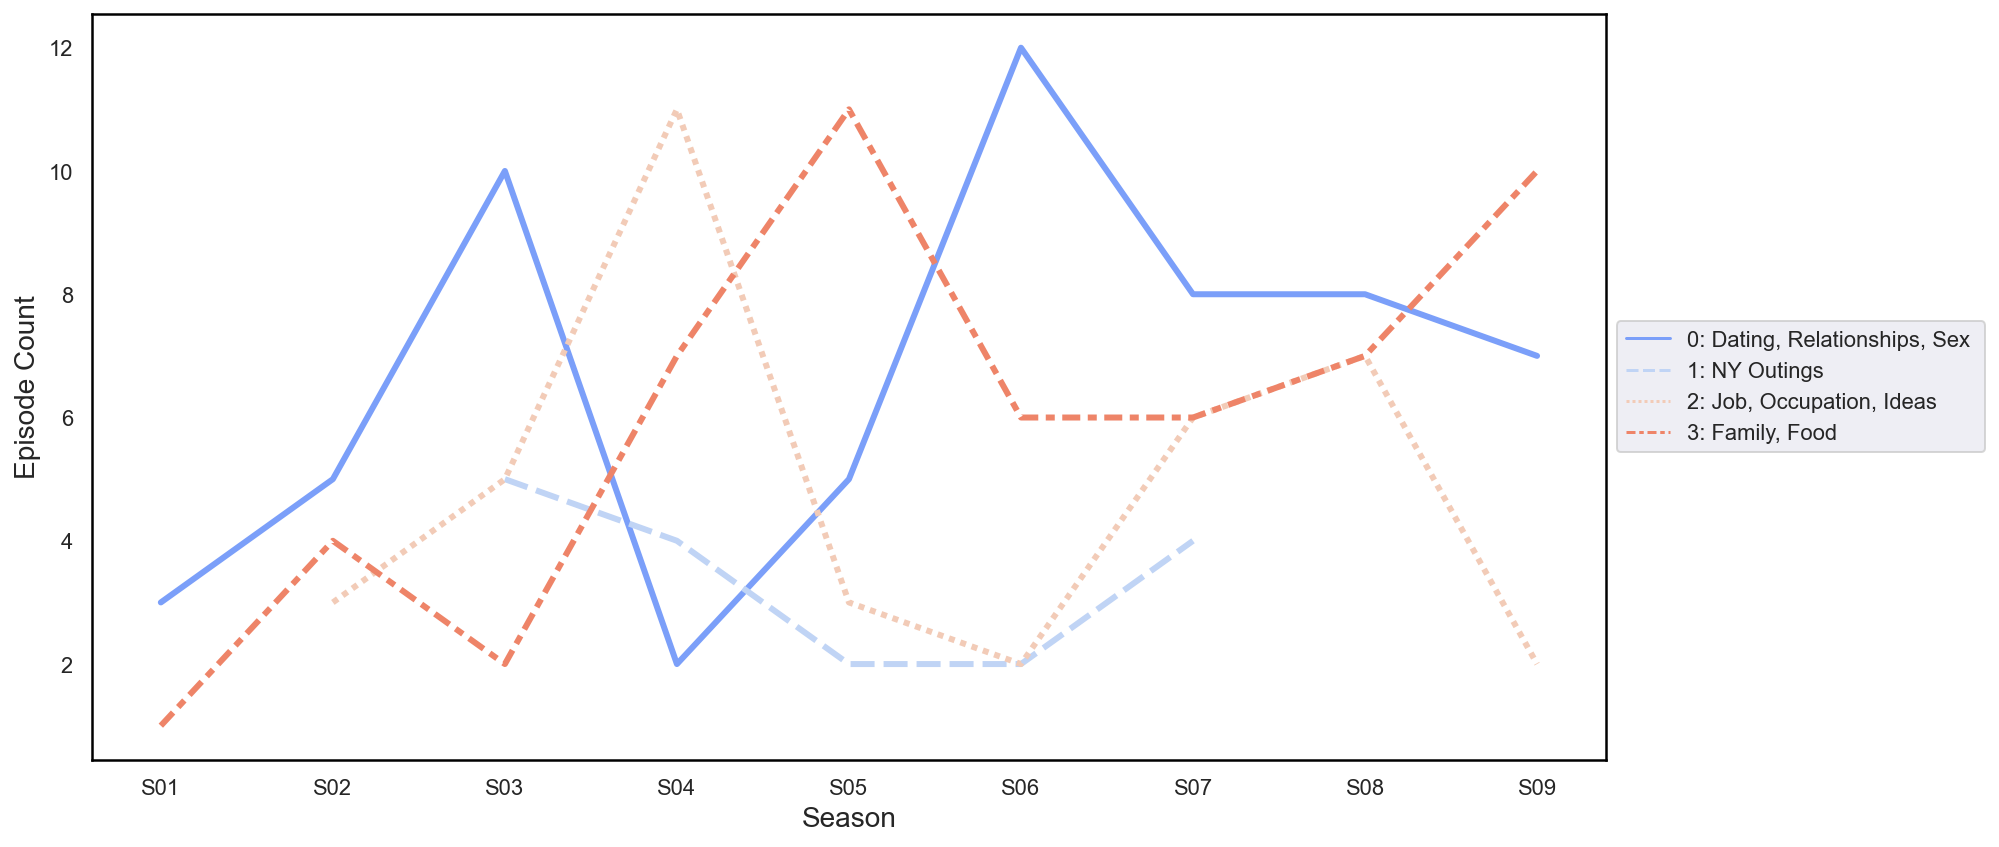

In [1372]:
%matplotlib inline
plt.figure(figsize = (14, 6),facecolor='white')


ax = sns.lineplot(data=df_grg_nmf_wide,palette=sns.color_palette('coolwarm', n_colors=4),linewidth=3)
#ax = sns.lineplot(data=df_wide,palette=sns.color_palette('coolwarm', n_colors=4),linewidth=3)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rc('axes',edgecolor='black')
#ax = plt.axes()
#ax.set_facecolor("orange")
# OR
ax.set(facecolor = "white")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.rc('axes',edgecolor='black')
plt.ylabel("Episode Count",fontsize=14)
plt.xlabel("Season",fontsize=14)
plt.tight_layout()
plt.savefig('line_topmod_grg_season.svg')
plt.show()

Use the above for topic modeling (df_nosp)

In [1048]:
df_grg_top.head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


character    seid                                         lemmatized  \
2       george  S01E01  be you through yes it be purple I like it I do...   
567     george  S01E02  from the intercom yeah to jerry ready hey elai...   
838     george  S01E03  I have to say something chuckle I have to say ...   
1080    george  S01E04  I never hear he say anything really funny you ...   
1309    george  S02E01  she ca nt kill I right people break up all the...   

      polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
2     0.154769      0.529920    0.9912  0.091  0.774  0.135  0.000009  ...   
567   0.150283      0.543423    0.9805  0.126  0.706  0.168  0.000020  ...   
838   0.000486      0.676512   -0.0115  0.074  0.850  0.077  0.000023  ...   
1080  0.080470      0.498217    0.9337  0.091  0.805  0.104  0.000024  ...   
1309  0.153553      0.532973    0.7676  0.132  0.735  0.133  0.000007  ...   

           joy  negative  positive   sadness  surprise     trust  word_count  \
2     0.000015  0.000023  0.000026  0.000013  0.000013  0.000019        1035   
567   0.000025  0.000034  0.000036  0.000018  0.000011  0.000013         669   
838   0.000014  0.000032  0.000030  0.000016  0.000014  0.000014         662   
1080  0.000028  0.000026  0.000038  0.000020  0.000022  0.000028         703   
1309  0.000019  0.000023  0.000036  0.000013  0.000018  0.000020         949   

      season  topic                     topic_label  
2        S01      0  0: Dating, Relationships, Sex   
567      S01      0  0: Dating, Relationships, Sex   
838      S01      3                 3: Family, Food  
1080     S01      0  0: Dating, Relationships, Sex   
1309     S02      0  0: Dating, Relationships, Sex   

[5 rows x 23 columns]

## Behavior episodes with topic model overlay

In [1093]:
df_grg_top.describe(percentiles=[.05,.10, .5, .90, .95])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


polarity  subjectivity    compound         neg         neu  \
count  172.000000    172.000000  172.000000  172.000000  172.000000   
mean     0.089802      0.524959    0.603806    0.089924    0.764878   
std      0.076422      0.061854    0.712031    0.033395    0.046487   
min     -0.120168      0.375029   -0.994500    0.033000    0.622000   
5%      -0.041658      0.427815   -0.972175    0.041550    0.684550   
10%     -0.004402      0.438669   -0.942220    0.050100    0.705000   
50%      0.090967      0.526130    0.980550    0.086500    0.768000   
90%      0.188341      0.609875    0.998260    0.131800    0.823900   
95%      0.204636      0.638147    0.998645    0.149350    0.833450   
max      0.258146      0.676512    0.999500    0.206000    0.885000   

             pos       anger  anticipation     disgust        fear  \
count  172.00000  172.000000    172.000000  172.000000  172.000000   
mean     0.14518    0.000021      0.000036    0.000017    0.000026   
std      0.04035    0.000015      0.000020    0.000014    0.000018   
min      0.05800    0.000000      0.000007    0.000000    0.000005   
5%       0.08555    0.000006      0.000014    0.000005    0.000009   
10%      0.09810    0.000008      0.000017    0.000006    0.000011   
50%      0.14100    0.000017      0.000030    0.000013    0.000021   
90%      0.19290    0.000040      0.000064    0.000031    0.000047   
95%      0.21550    0.000052      0.000077    0.000039    0.000062   
max      0.27500    0.000100      0.000128    0.000119    0.000116   

              joy    negative    positive     sadness    surprise       trust  \
count  172.000000  172.000000  172.000000  172.000000  172.000000  172.000000   
mean     0.000029    0.000045    0.000056    0.000023    0.000021    0.000035   
std      0.000020    0.000025    0.000030    0.000017    0.000014    0.000020   
min      0.000000    0.000011    0.000012    0.000000    0.000000    0.000006   
5%       0.000009    0.000018    0.000025    0.000008    0.000006    0.000013   
10%      0.000012    0.000021    0.000028    0.000009    0.000007    0.000016   
50%      0.000025    0.000038    0.000049    0.000018    0.000018    0.000029   
90%      0.000051    0.000077    0.000085    0.000042    0.000036    0.000060   
95%      0.000061    0.000091    0.000103    0.000052    0.000050    0.000071   
max      0.000154    0.000181    0.000210    0.000116    0.000088    0.000145   

        word_count       topic  
count   172.000000  172.000000  
mean    650.011628    1.505814  
std     210.832435    1.258873  
min     161.000000    0.000000  
5%      356.050000    0.000000  
10%     400.400000    0.000000  
50%     632.000000    2.000000  
90%     918.500000    3.000000  
95%     996.200000    3.000000  
max    1576.000000    3.000000

**ANGER**

In [1176]:
df_anger = df_grg_top[df_grg_top["anger"] > 0.000040]
#df_anger_opp = df_grg_top[df_grg_top["anger"] < 0.000008]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1177]:
df_anger.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(16, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


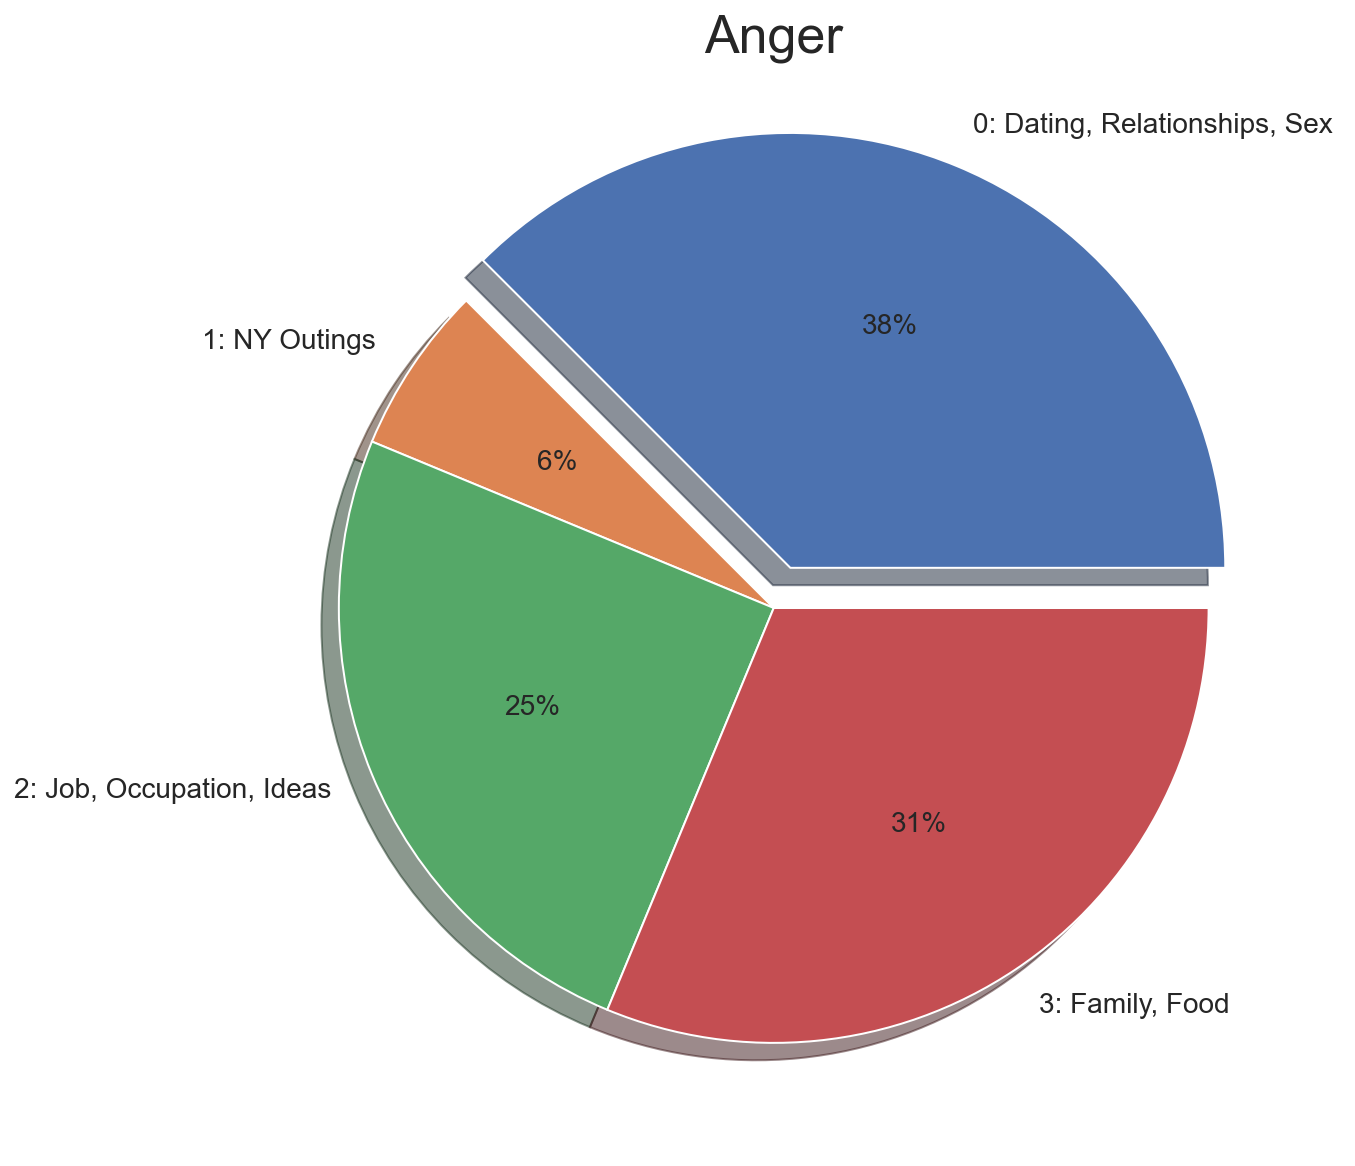

In [1305]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_anger.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0.1, 0, 0, 0)  ,textprops={'fontsize': 14} ,legend=None) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Anger",fontsize=26)
plt.savefig('pie_grg_anger.svg')
plt.show()

**DISGUST**

In [1200]:
df_disg = df_grg_top[df_grg_top["disgust"] > 0.000031]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1201]:
df_disg.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(16, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


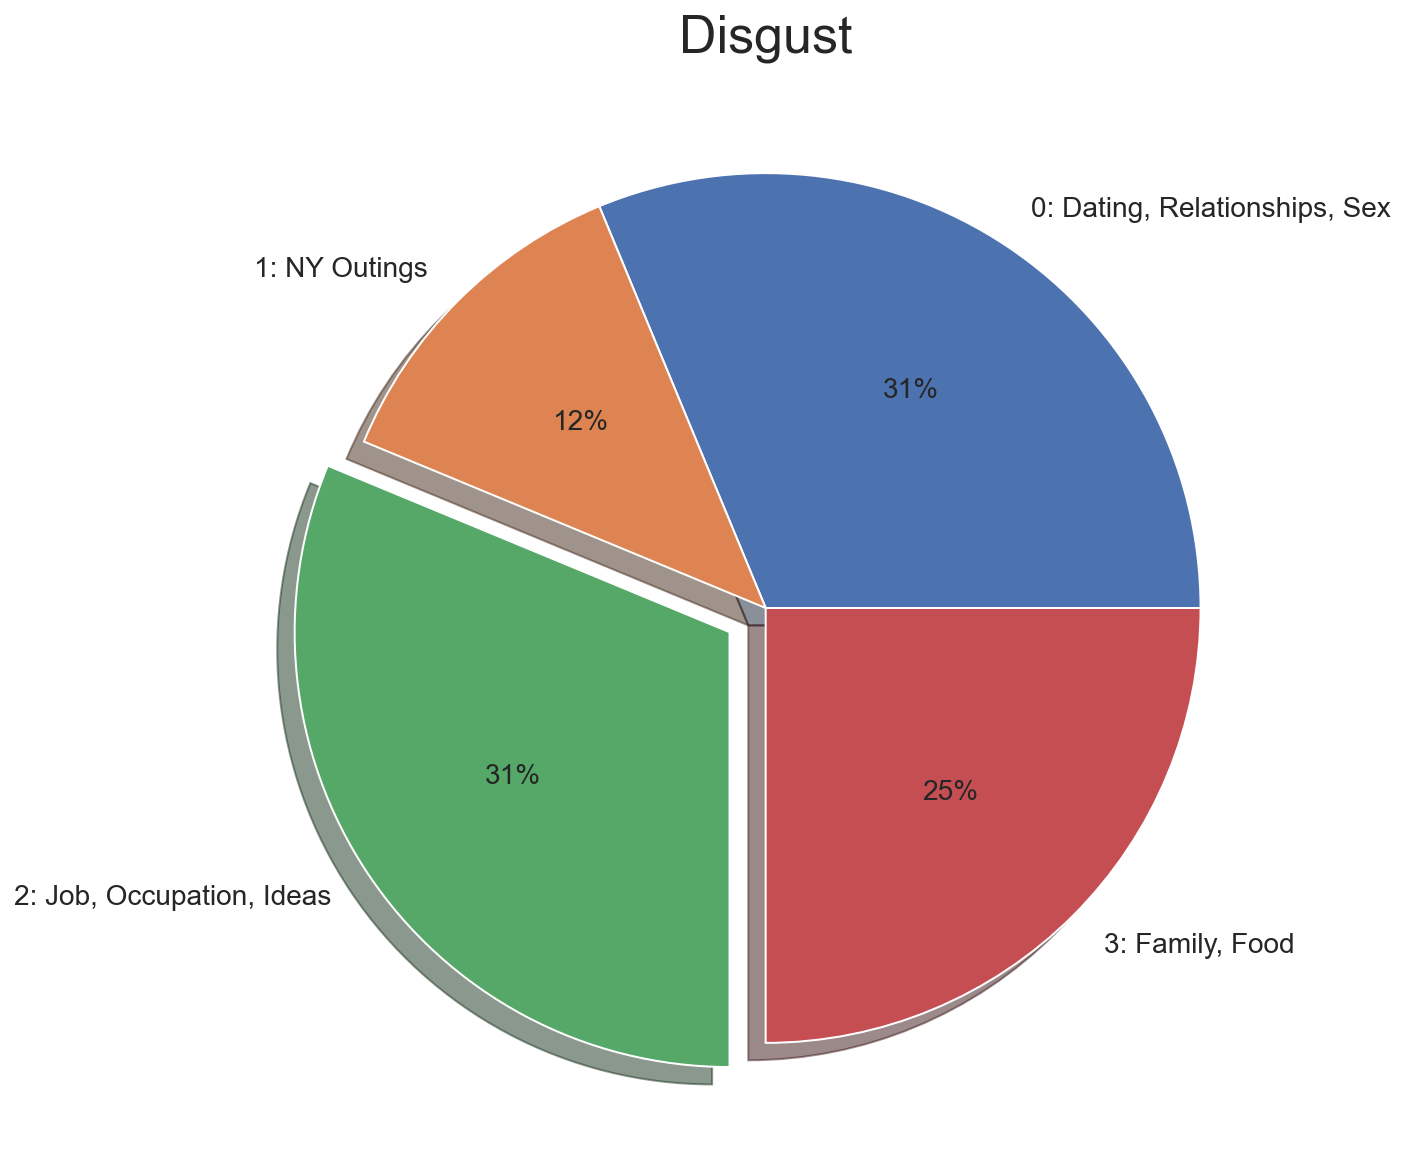

In [1373]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_disg.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0.1, 0)  ,textprops={'fontsize': 14} ,legend=None ) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Disgust",fontsize=26)
plt.savefig('pie_grg_disgust.svg')
plt.show()

**SURPRISE**

In [1205]:
df_surprise = df_grg_top[df_grg_top["surprise"] > 0.000036]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1206]:
df_surprise.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


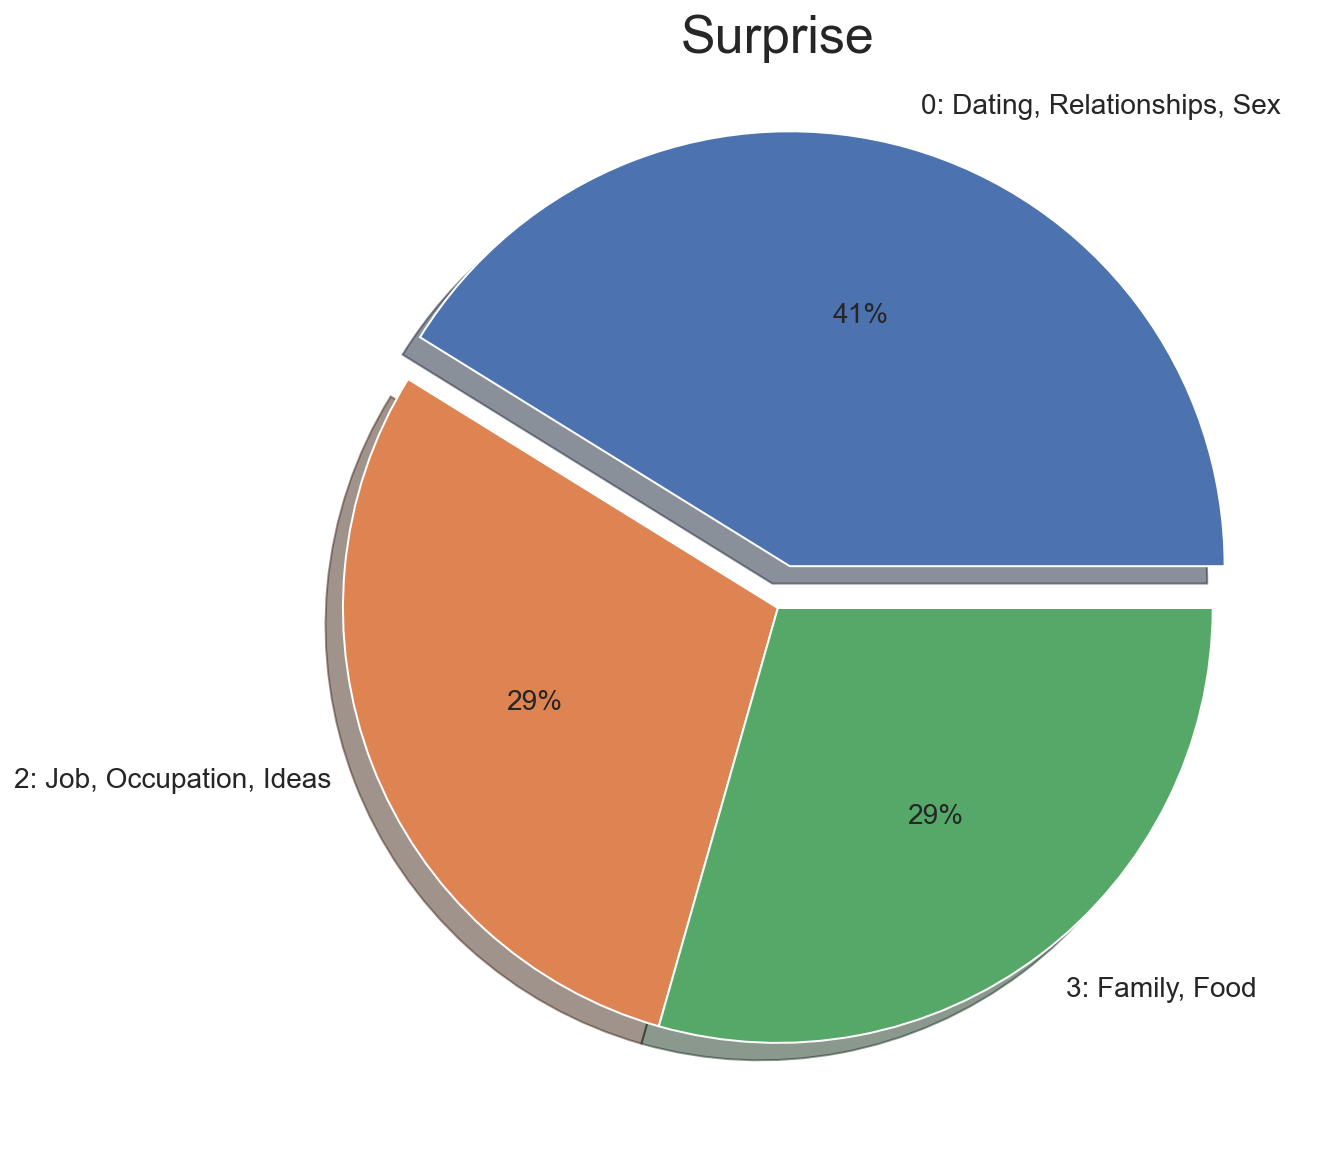

In [1374]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_surprise.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0.1, 0, 0)  ,textprops={'fontsize': 14} ,legend=None) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Surprise",fontsize=26)
plt.savefig('pie_grg_surprise.svg')
plt.show()

**JOY**

In [1223]:
df_joy = df_grg_top[df_grg_top["joy"] > 0.0000590]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1224]:
df_joy.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(10, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


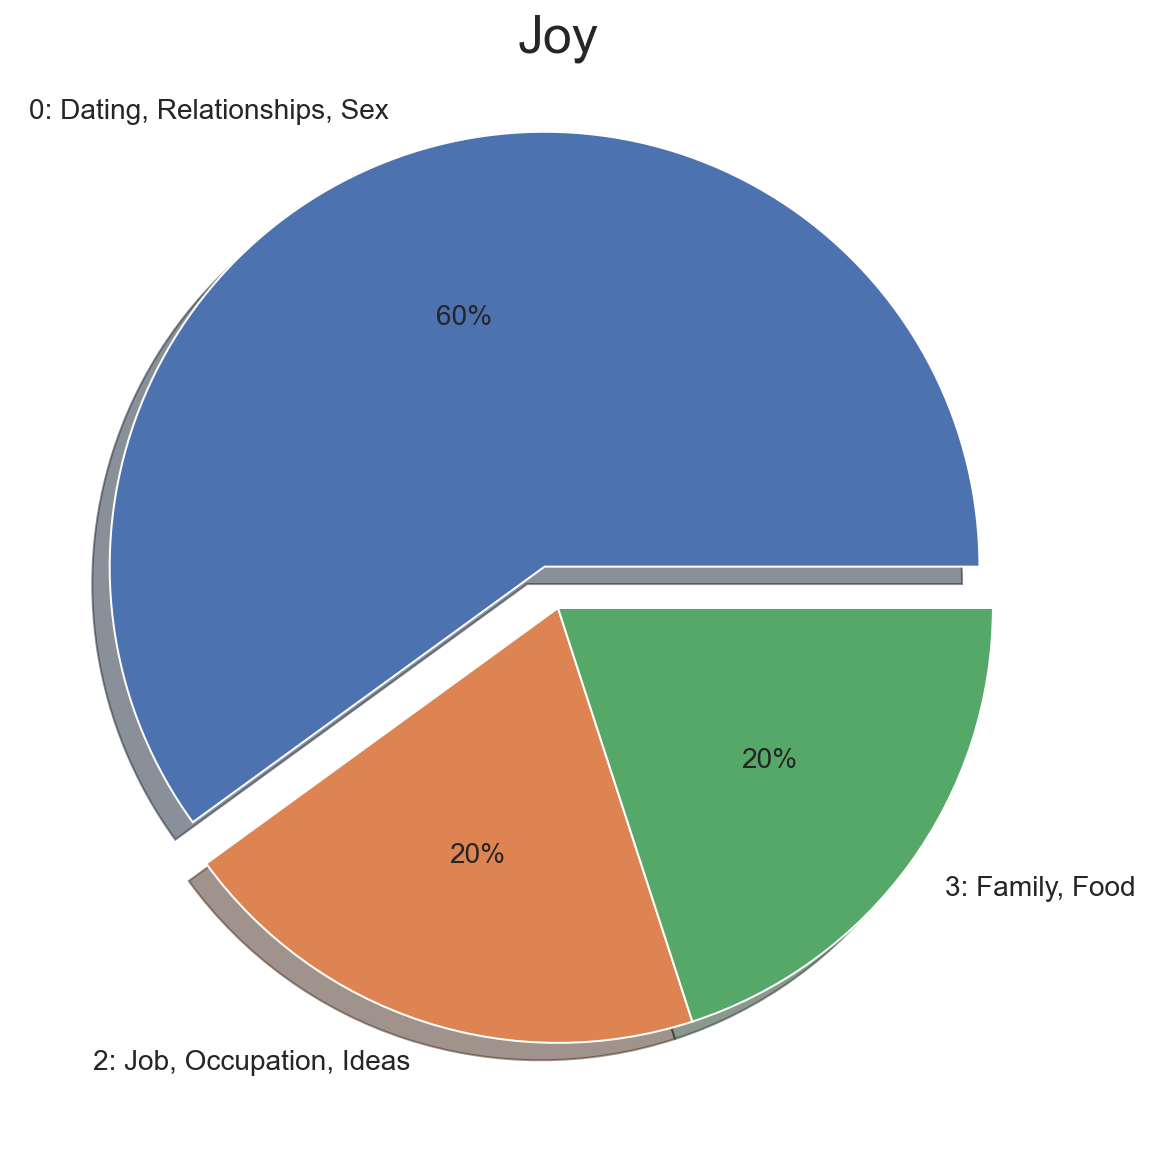

In [1375]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_joy.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0.1, 0, 0)  ,textprops={'fontsize': 14} ,legend=None) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Joy",fontsize=26)
plt.savefig('pie_grg_joy.svg')
plt.show()

**POSITIVE**

In [1226]:
df_pos = df_grg_top[df_grg_top["positive"] > 0.000085]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1227]:
df_pos.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


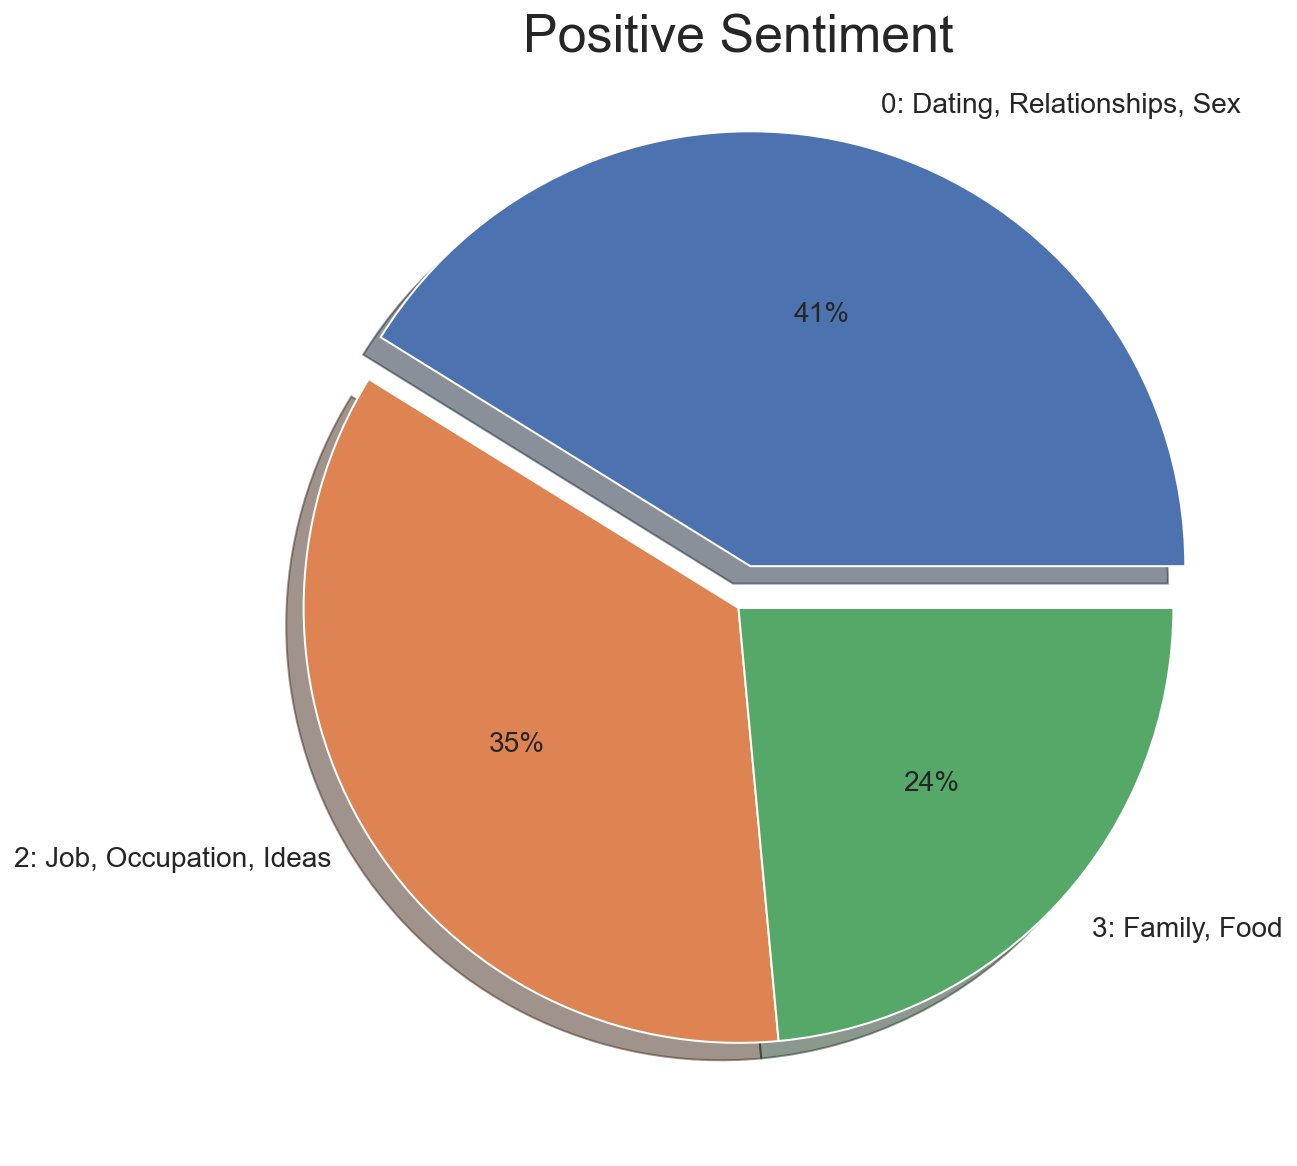

In [1376]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_pos.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0.1, 0, 0)  ,textprops={'fontsize': 14} ,legend=None) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Positive Sentiment",fontsize=26)
plt.savefig('pie_grg_pos.svg')
plt.show()

**NEGATIVE**

In [1245]:
df_neg = df_grg_top[df_grg_top["negative"] > 0.000080]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1246]:
df_neg.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(17, 23)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


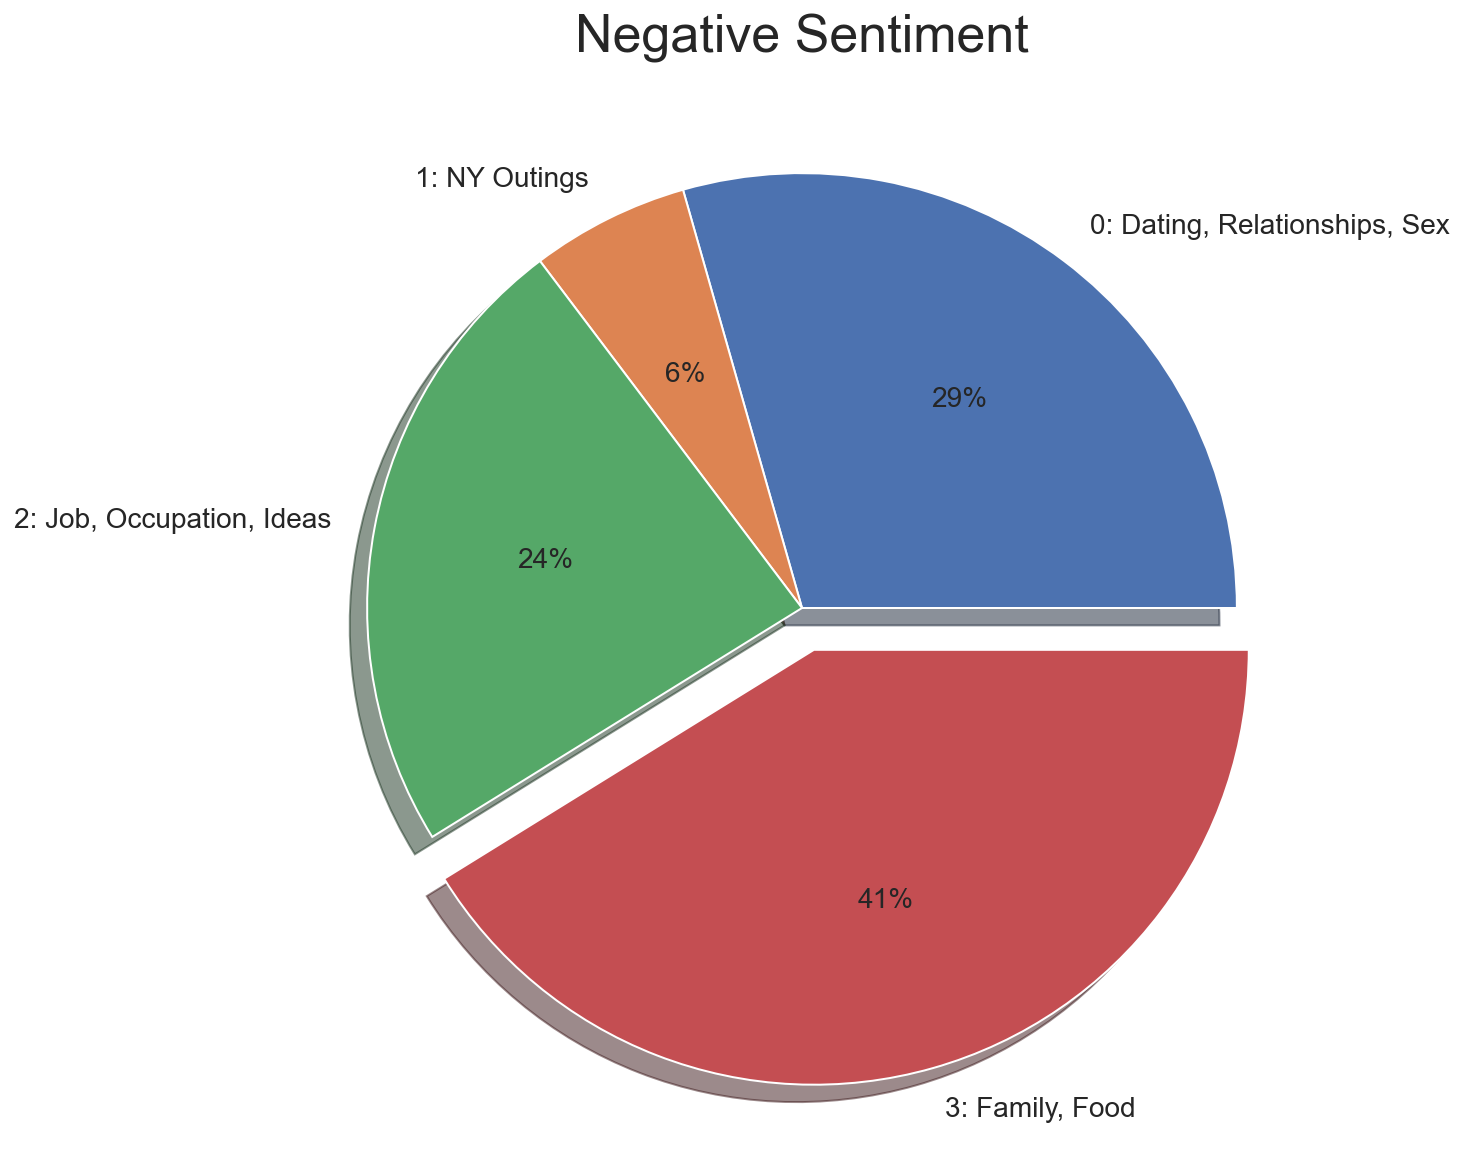

In [1377]:
#df_neg.groupby(['topic_label']).count().plot(kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%')
%matplotlib inline
plt.rcParams['font.size'] = 14
#plt.hist(df_anger, x="topic_label")
ax=df_neg.groupby(['topic_label']).count().plot(kind='pie', y="topic", figsize=(15,10), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0,0.1)  ,textprops={'fontsize': 14} ,legend=None) #, labels=['','','',''])
plt.ylabel('')
#ax.legend( labels=df_neg.topic_label)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Negative Sentiment",fontsize=26)
plt.savefig('pie_grg_neg.svg')
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


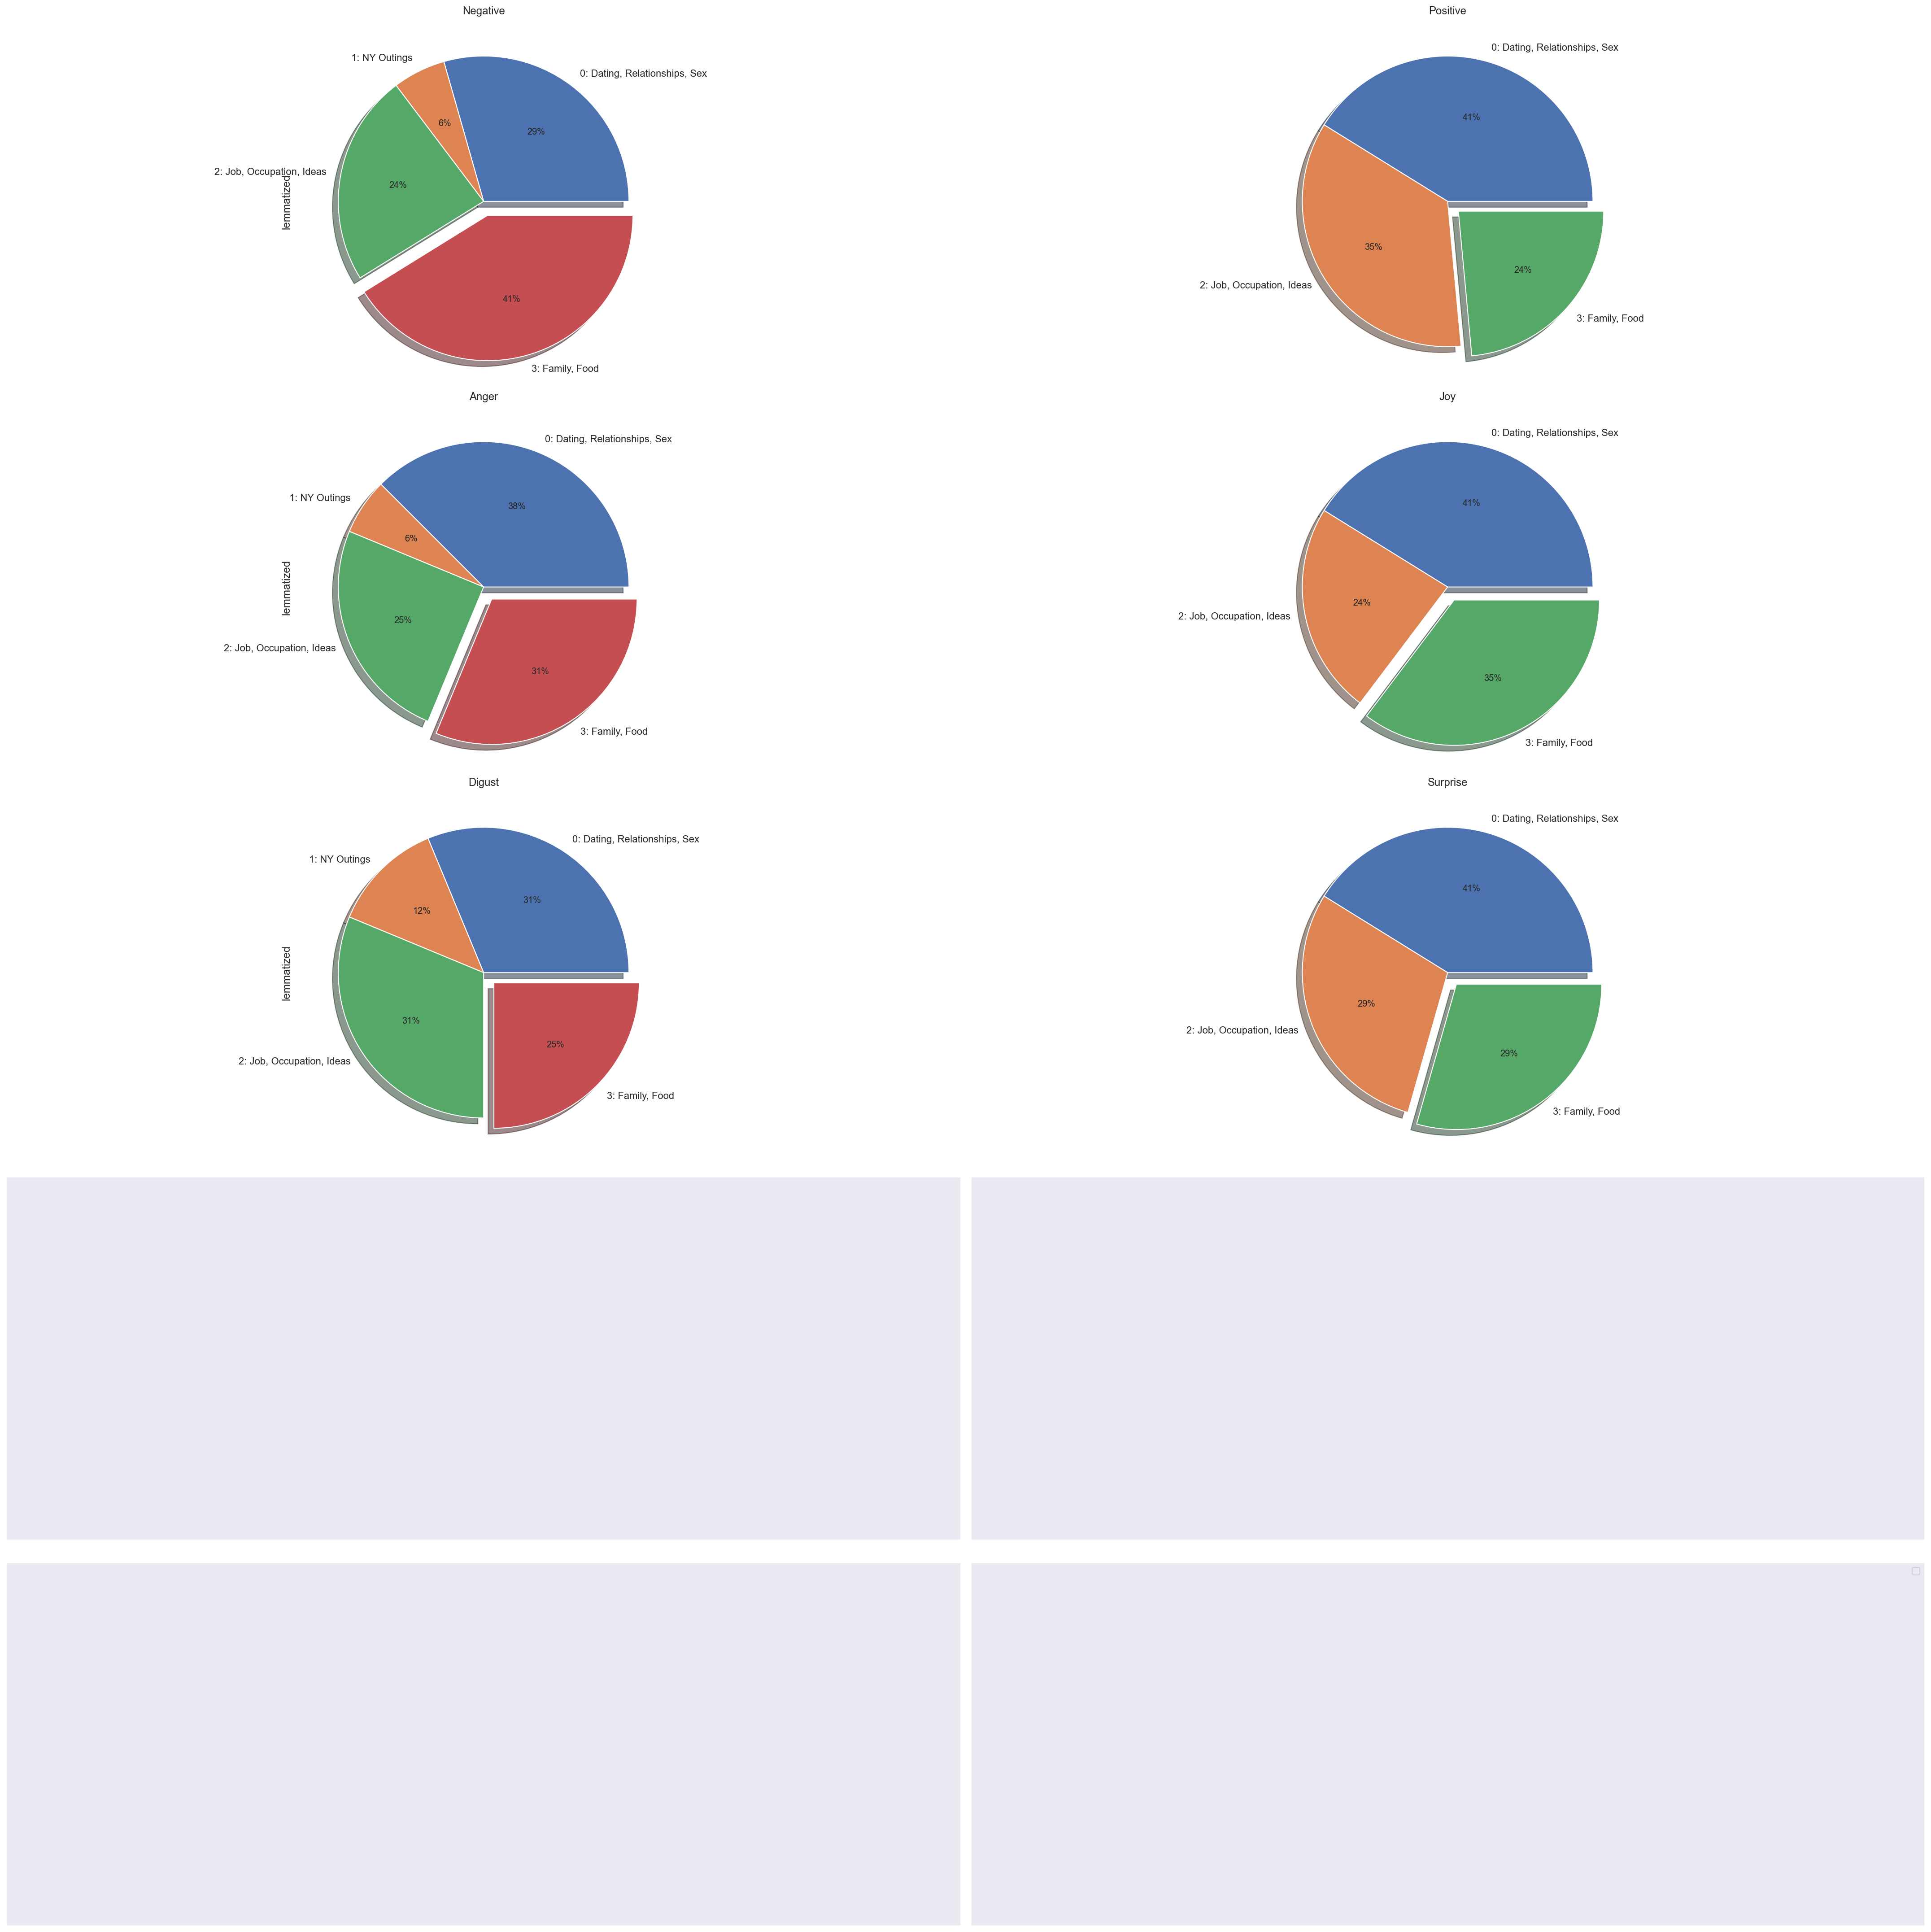

In [1143]:
%matplotlib inline

fig, axes = plt.subplots(5,2, figsize=(40, 20), facecolor='white',sharex=True ,sharey=True)


#df_neg.groupby(['topic_label']).count().plot(ax=axes[0,0], kind='pie', y='lemmatized',figsize=(15,10), autopct='%1.1f%%',legend=None)
ax1=df_neg.groupby(['topic_label']).count().plot(ax=axes[0,0], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0, 0.1),legend=None)
 
ax2=df_pos.groupby(['topic_label']).count().plot(ax=axes[0,1], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0,0.1),legend=None)

ax3=df_anger.groupby(['topic_label']).count().plot(ax=axes[1,0], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0, 0.1),legend=None)

ax4=df_joy.groupby(['topic_label']).count().plot(ax=axes[1,1], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0.1),legend=None)

ax5=df_disg.groupby(['topic_label']).count().plot(ax=axes[2,0], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0, 0.1),legend=None)

ax6=df_surprise.groupby(['topic_label']).count().plot(ax=axes[2,1], kind='pie', y='lemmatized',figsize=(30,30), autopct='%.0f%%', shadow=True,
              explode=(0, 0, 0.1),legend=None)

ax1.title.set_text('Negative')
ax2.title.set_text('Positive')
ax3.title.set_text('Anger')
ax4.title.set_text('Joy')
ax5.title.set_text('Digust')
ax6.title.set_text('Surprise')

# axs[0, 1].pie(fracs, labels=labels, autopct='%.0f%%', shadow=True,
#               explode=(0, 0.1, 0, 0))

#sns.set(rc={'figure.figsize':(40,20)})
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
plt.legend(labels=labels)
plt.tight_layout()
plt.savefig('pie_sent_george.png')
ax.grid(False)
plt.show()

## WORD CLOUD - POS/NEG George

In [1312]:
df_grg_top.describe(percentiles=[.01,.05,.10,.25,.5,.75,.90,.95])


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


polarity  subjectivity    compound         neg         neu  \
count  172.000000    172.000000  172.000000  172.000000  172.000000   
mean     0.089802      0.524959    0.603806    0.089924    0.764878   
std      0.076422      0.061854    0.712031    0.033395    0.046487   
min     -0.120168      0.375029   -0.994500    0.033000    0.622000   
1%      -0.090191      0.381275   -0.991883    0.033710    0.638650   
5%      -0.041658      0.427815   -0.972175    0.041550    0.684550   
10%     -0.004402      0.438669   -0.942220    0.050100    0.705000   
25%      0.043134      0.483603    0.780275    0.065000    0.737000   
50%      0.090967      0.526130    0.980550    0.086500    0.768000   
75%      0.148314      0.561902    0.995300    0.112250    0.796250   
90%      0.188341      0.609875    0.998260    0.131800    0.823900   
95%      0.204636      0.638147    0.998645    0.149350    0.833450   
max      0.258146      0.676512    0.999500    0.206000    0.885000   

             pos       anger  anticipation     disgust        fear  \
count  172.00000  172.000000    172.000000  172.000000  172.000000   
mean     0.14518    0.000021      0.000036    0.000017    0.000026   
std      0.04035    0.000015      0.000020    0.000014    0.000018   
min      0.05800    0.000000      0.000007    0.000000    0.000005   
1%       0.07571    0.000002      0.000011    0.000003    0.000007   
5%       0.08555    0.000006      0.000014    0.000005    0.000009   
10%      0.09810    0.000008      0.000017    0.000006    0.000011   
25%      0.11550    0.000012      0.000023    0.000009    0.000015   
50%      0.14100    0.000017      0.000030    0.000013    0.000021   
75%      0.17025    0.000025      0.000045    0.000020    0.000031   
90%      0.19290    0.000040      0.000064    0.000031    0.000047   
95%      0.21550    0.000052      0.000077    0.000039    0.000062   
max      0.27500    0.000100      0.000128    0.000119    0.000116   

              joy    negative    positive     sadness    surprise       trust  \
count  172.000000  172.000000  172.000000  172.000000  172.000000  172.000000   
mean     0.000029    0.000045    0.000056    0.000023    0.000021    0.000035   
std      0.000020    0.000025    0.000030    0.000017    0.000014    0.000020   
min      0.000000    0.000011    0.000012    0.000000    0.000000    0.000006   
1%       0.000006    0.000015    0.000014    0.000001    0.000003    0.000007   
5%       0.000009    0.000018    0.000025    0.000008    0.000006    0.000013   
10%      0.000012    0.000021    0.000028    0.000009    0.000007    0.000016   
25%      0.000017    0.000028    0.000036    0.000013    0.000011    0.000020   
50%      0.000025    0.000038    0.000049    0.000018    0.000018    0.000029   
75%      0.000036    0.000053    0.000067    0.000028    0.000027    0.000047   
90%      0.000051    0.000077    0.000085    0.000042    0.000036    0.000060   
95%      0.000061    0.000091    0.000103    0.000052    0.000050    0.000071   
max      0.000154    0.000181    0.000210    0.000116    0.000088    0.000145   

        word_count       topic  
count   172.000000  172.000000  
mean    650.011628    1.505814  
std     210.832435    1.258873  
min     161.000000    0.000000  
1%      261.070000    0.000000  
5%      356.050000    0.000000  
10%     400.400000    0.000000  
25%     501.750000    0.000000  
50%     632.000000    2.000000  
75%     774.250000    3.000000  
90%     918.500000    3.000000  
95%     996.200000    3.000000  
max    1576.000000    3.000000

In [1318]:
base_stop_words = nltk.corpus.stopwords.words('english')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1364]:
base_add = ['think','need','move','happen','even','ta','na','oh','hey','ca','nt','mr',
            'uh','yeah','gon','thing','come','take','know','make','bubble','ya','go','let','ill',
            'goback','huh','yada','guy','two','look','back','well','one','see','wanna',
           'talk','right','pick','yes','long','give','way','really','see','tell','good','bad','big','say','farku','costanza','want','little']
base_stop_words.extend(base_add)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1365]:
#df_pos_grg = df_grg_top[df_grg_top["positive"] > 0.000085]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


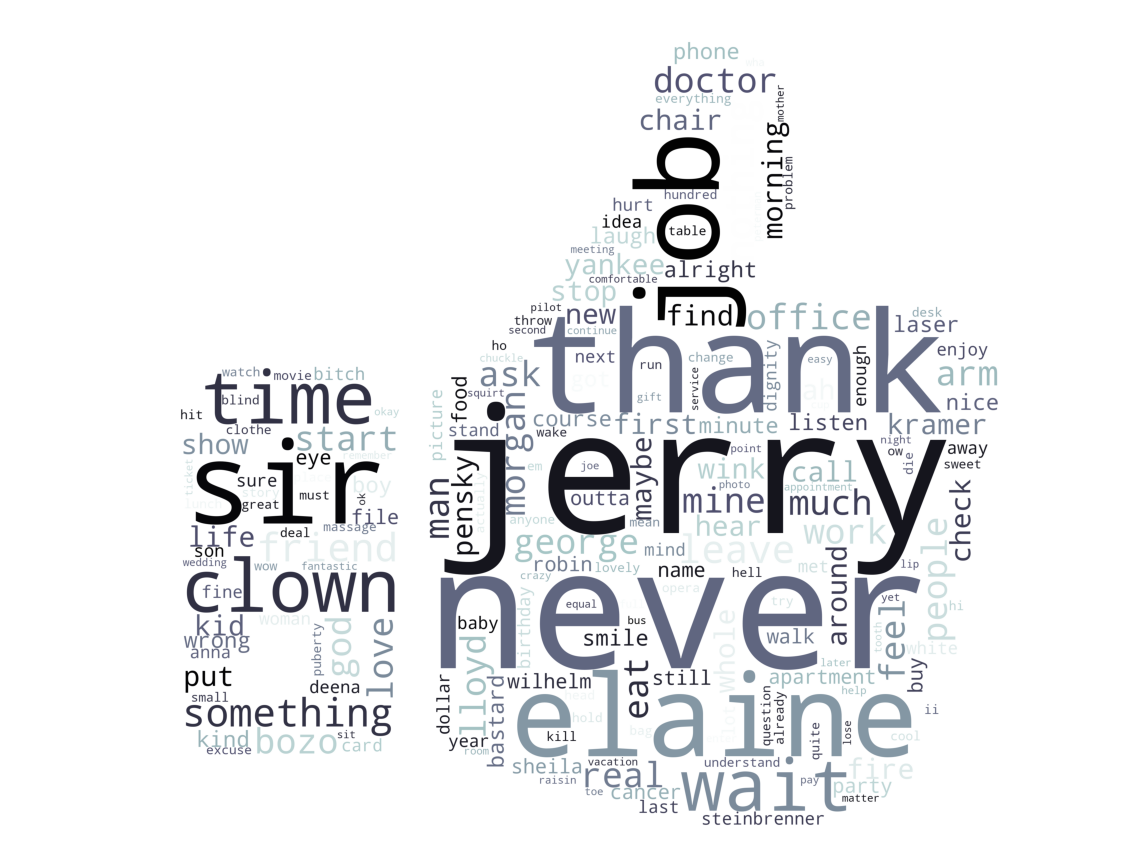

<Figure size 432x288 with 0 Axes>

In [1366]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt


# Import packages
import numpy as np
from PIL import Image

# remove stopwords 

#def wcloud(data):
df_cloudp = df_pos.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloudp['lemmatized']=df_pos['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_stop_words]))

split_title = [x.split(" ") for x in df_cloudp['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


mask = np.array(Image.open('upvote.png'))

wordcloud = WordCloud(background_color='white', colormap='bone', collocations=False,  #max_font_size=40 max_words= ,scale=10,
                      width = 3000, height = 2000, mask=mask, random_state=1).generate((listCounts[listCounts > 1]).to_string())

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)#, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_pos_costanza.png')
plt.show()

In [1367]:
'yada','guy','two','look','back','well','one'

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('yada', 'guy', 'two', 'look', 'back', 'well', 'one')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


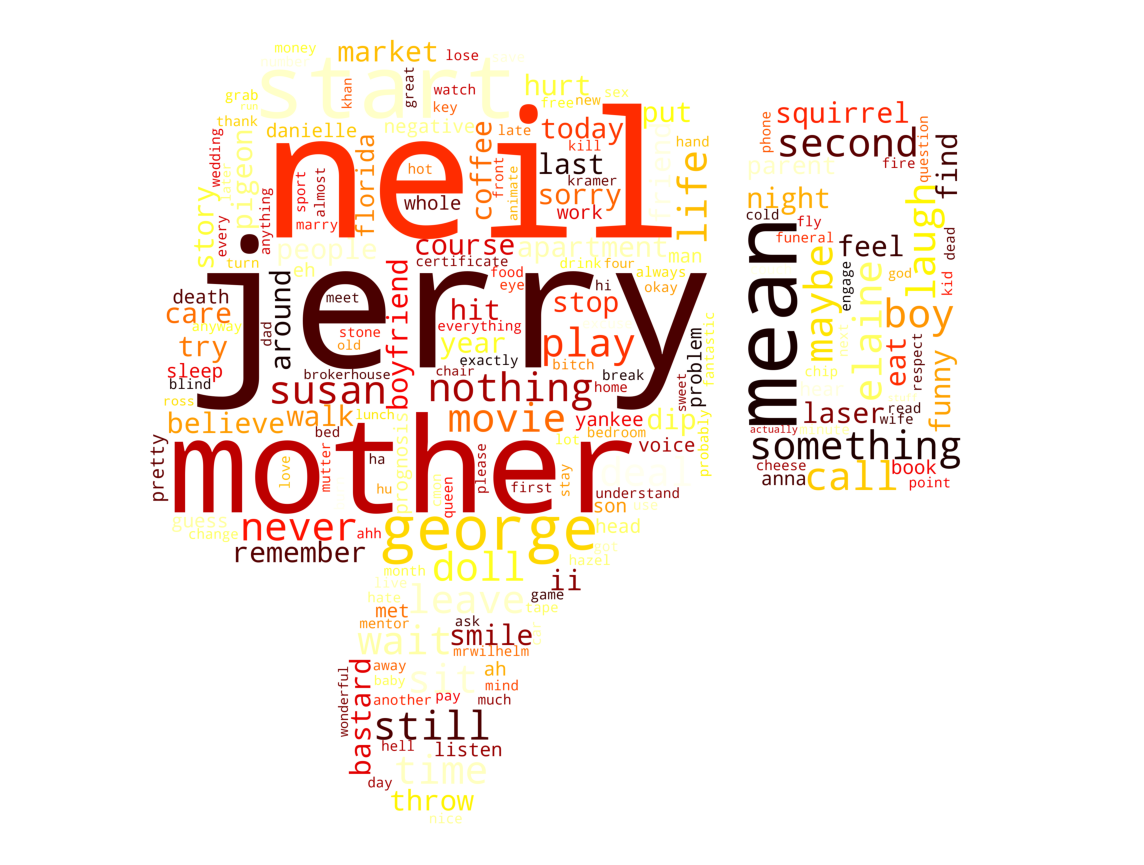

<Figure size 432x288 with 0 Axes>

In [1368]:
# Visualise using word cloud
from wordcloud import WordCloud
import matplotlib as plt
import matplotlib.pyplot as plt

# Import packages
import numpy as np
from PIL import Image
# remove stopwords 

#def wcloud(data):
df_cloudn = df_neg.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloudn['lemmatized']=df_neg['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_stop_words]))

split_title = [x.split(" ") for x in df_cloudn['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()
#listCounts.to_csv('listcounts.csv')


mask = np.array(Image.open('downote.png'))

wordcloud = WordCloud(background_color='white', colormap='hot', collocations=False,  #max_font_size=40 max_words= ,scale=10,
                      width = 3000, height = 2000, mask=mask, random_state=1).generate((listCounts[listCounts > 1]).to_string())


# Generate wordcloud
#wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(text)


plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)# , interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_neg_costanza.png')
plt.show()

In [ ]:
'talk','right','pick','way','really','see','tell

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


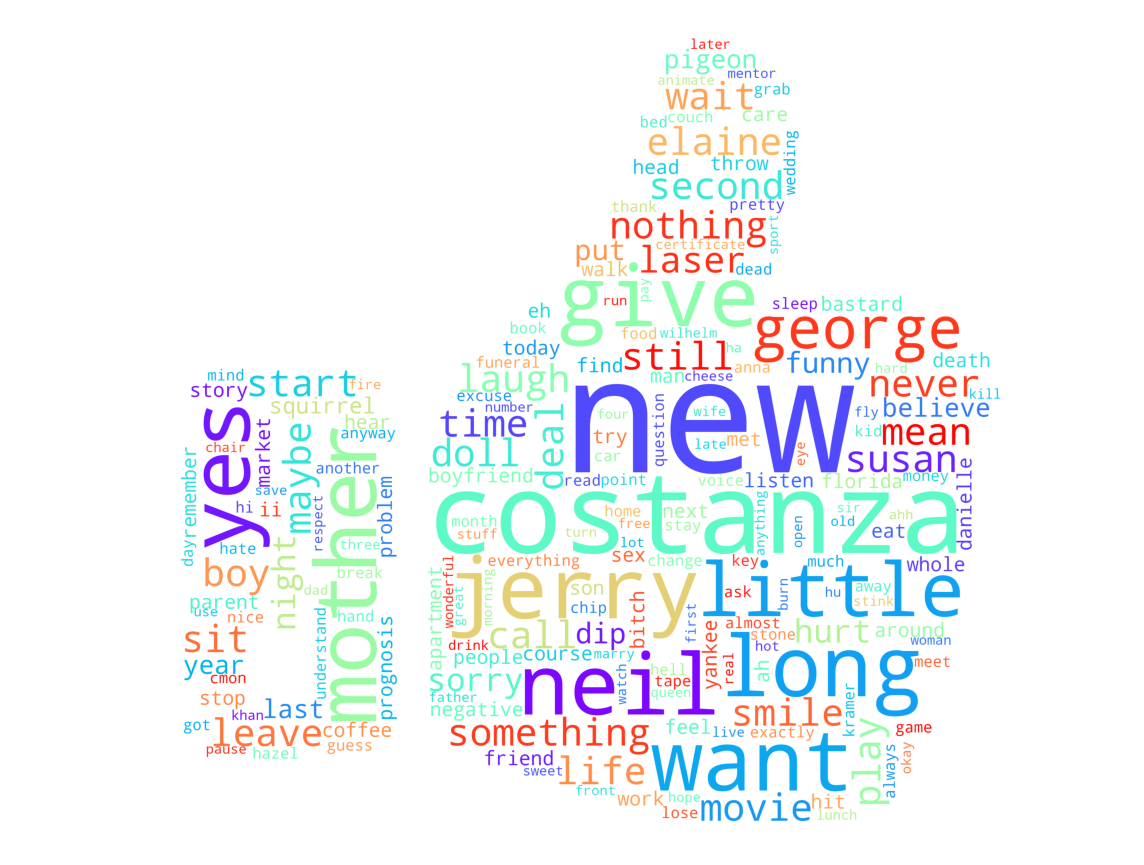

<Figure size 432x288 with 0 Axes>

In [1353]:
# Import packages
import numpy as np
from PIL import Image
# Import image to np.array

# Generate wordcloud
# wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='white',
#                       colormap='Set2', collocations=False, stopwords = STOPWORDS, mask=mask).generate(text)
# # Plot
# plot_cloud(wordcloud)


df_cloud = df_neg.copy()
    #df_cloud["textmod"] = df_nosp.drop([[my_stop_words]],axis=1)
df_cloud['lemmatized']=df_neg['lemmatized'].apply(lambda x: ' '.join([item for item in x.split() if item not in base_stop_words]))

split_title = [x.split(" ") for x in df_cloud['lemmatized'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

mask = np.array(Image.open('downote.png'))

wordcloud = WordCloud(background_color='white', colormap='Reds', collocations=False,  #max_font_size=40 max_words= ,scale=10,
                      width = 3000, height = 2000, mask=mask, random_state=1).generate((listCounts[listCounts > 0]).to_string())


plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)#, interpolation="bilinear")
plt.axis("off")
plt.show()
plt.tight_layout()
#plt.savefig('cloud_costanza.pdf')
wordcloud.to_file('cloud_neg_costanza.png')
plt.show()





## Scattertext

In [268]:
import spacy
nlp = spacy.load('en_core_web_sm')

**bring pos and neg george text together**

In [792]:
df_sent_grg_pos["character_grg"] = "george_positive" 
df_sent_grg_neg["character_grg"] = "george_negative" 
df_sent_grg_all=pd.concat([df_sent_grg_pos,df_sent_grg_neg],ignore_index=True)

In [793]:
df_sent_grg_all['parsed'] = df_sent_grg_all.lemmatized.apply(nlp)

In [794]:
df_sent_grg_all.head()

character    seid                                         lemmatized  \
0    george  S02E05  thank see you later donna what happen to you w...   
1    george  S07E17  resent the fact nodding I be aware a billiard ...   
2    george  S05E17  can I come upstairs please elaine push the but...   
3    george  S09E01  what be holland no that s the netherland then ...   
4    george  S02E02  you know I ve be think I can not envision any ...   

   polarity  subjectivity  compound    neg    neu    pos     anger  ...  \
0 -0.032807      0.444065    0.7102  0.086  0.825  0.090  0.000030  ...   
1  0.078831      0.399330    0.9797  0.076  0.805  0.118  0.000039  ...   
2 -0.089356      0.526400   -0.6936  0.091  0.829  0.079  0.000040  ...   
3  0.139846      0.569873    0.9948  0.103  0.704  0.193  0.000034  ...   
4 -0.003385      0.430990   -0.9703  0.151  0.791  0.058  0.000028  ...   

       fear       joy  negative  positive   sadness  surprise     trust  \
0  0.000022  0.000043  0.000087  0.000069  0.000035  0.000022  0.000061   
1  0.000022  0.000074  0.000092  0.000070  0.000052  0.000017  0.000048   
2  0.000060  0.000040  0.000050  0.000071  0.000040  0.000030  0.000030   
3  0.000039  0.000041  0.000063  0.000071  0.000032  0.000027  0.000041   
4  0.000028  0.000028  0.000085  0.000071  0.000028  0.000028  0.000042   

   word_count    character_grg  \
0         480  george_positive   
1         479  george_positive   
2         315  george_positive   
3         641  george_positive   
4         266  george_positive   

                                              parsed  
0  (thank, see, you, later, donna, what, happen, ...  
1  (resent, the, fact, nodding, I, be, aware, a, ...  
2  (can, I, come, upstairs, please, elaine, push,...  
3  (what, be, holland, no, that, s, the, netherla...  
4  (you, know, I, ve, be, think, I, can, not, env...  

[5 rows x 22 columns]

In [795]:
print("Document Count")
print(df_sent_grg_all.groupby('seid')['lemmatized'].count())
print("Word Count")
df_sent_grg_all.groupby('seid').apply(lambda x: x.lemmatized.apply(lambda x: len(x.split())).sum())

Document Count
seid
S02E02    2
S02E05    2
S02E06    1
S02E10    1
S03E04    1
S03E05    1
S03E11    1
S03E13    1
S03E15    1
S03E20    2
S04E05    2
S04E09    1
S04E17    1
S04E19    2
S04E23    2
S05E04    1
S05E07    1
S05E08    1
S05E10    1
S05E11    1
S05E17    1
S05E20    1
S06E01    2
S06E04    1
S06E06    2
S06E10    1
S06E18    2
S06E22    1
S06E24    2
S07E04    2
S07E05    2
S07E07    1
S07E16    2
S07E17    2
S07E19    2
S07E21    1
S07E22    1
S08E01    1
S08E04    2
S08E05    1
S08E06    2
S08E07    1
S08E09    1
S08E13    1
S08E16    1
S08E17    2
S08E18    1
S08E19    2
S08E20    2
S08E21    1
S09E01    2
S09E06    1
S09E10    1
S09E12    1
S09E17    1
S09E18    1
S09E19    1
S09E20    2
Name: lemmatized, dtype: int64
Word Count


seid
S02E02     530
S02E05     960
S02E06     589
S02E10     720
S03E04     363
S03E05     412
S03E11     395
S03E13     543
S03E15     553
S03E20    1088
S04E05     694
S04E09     458
S04E17     613
S04E19     842
S04E23    1272
S05E04     342
S05E07     475
S05E08     501
S05E10     392
S05E11     618
S05E17     315
S05E20     661
S06E01    1034
S06E04     495
S06E06    1290
S06E10     633
S06E18     756
S06E22     407
S06E24     322
S07E04     902
S07E05     800
S07E07     559
S07E16     754
S07E17     958
S07E19    1000
S07E21     507
S07E22     249
S08E01     500
S08E04     742
S08E05     452
S08E06     700
S08E07     564
S08E09     587
S08E13     521
S08E16     426
S08E17     900
S08E18     443
S08E19     560
S08E20     800
S08E21     470
S09E01    1282
S09E06     495
S09E10     708
S09E12     428
S09E17     361
S09E18     539
S09E19     344
S09E20     932
dtype: int64

In [ ]:
#corpus = st.CorpusFromParsedDocuments(df_nosp, category_col='season', parsed_col='parsed').build()


In [796]:
%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer
display(HTML("<style>.container { width:68% !important; }</style>"))

In [802]:
corpus = st.CorpusFromParsedDocuments(df_sent_grg_all, category_col='character_grg', parsed_col='parsed').build()
corpus

In [799]:
html = st.produce_scattertext_explorer(
        corpus,
        category='george_positive',
        category_name='george_positive',
        not_category_name='george_negative',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=df_sent_grg_all['character_grg'],
        )
file_name = 'samplexcattertextScale.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1200, height=700)